In [93]:
# Import the libraries
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from xml.dom import minidom
from collections import defaultdict
import shutil
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from collections import defaultdict
from pthflops import count_ops
import math
import seaborn as sns
import itertools


In [94]:
# dataset class for train, val and test data
class MyDataset(Dataset):

    def __init__(self, inputs, labels):

        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, i):
        result = {'inputs' : self.inputs[i], 'label': self.labels[i]}
        return result

    def __len__(self):
        return len(self.labels)



# Extract appropriate label information regarding the 11 vehicle types
# parse the xml file for label data

root = "./"
typeID_dict = defaultdict(list)
labels = minidom.parse("finegrained_label.xml")
items = labels.getElementsByTagName('Item')

type_id = {}

for label in items:
    type_id[label.attributes['imageName'].value] = label.attributes['typeID'].value

# create datasets for train, val and test, extracting the npy files
# and creating corresponding label dataset
x_dict = defaultdict(list)
y_dict = defaultdict(list)
file_name = defaultdict(list)
typeID_dict = defaultdict(list)
dirs = ['train', 'val', 'test']
for directory in dirs:
    for file in os.listdir("./" + directory):
        data = np.load("./" + directory + "/" + file )
        x_dict[directory].append(data)
        vehicle_id = file.split('_')
        vehicle_id = vehicle_id[0].lstrip('0')
        file_name[directory].append(file)
        typeID_dict[directory].append(int(type_id[file]))
        y_dict[directory].append(int(vehicle_id)-1)




In [95]:
# create dataloaders for the train, val and test sets
data_dict = {}    

train_dataset = MyDataset(x_dict['train'], typeID_dict['train'])
val_dataset = MyDataset(x_dict['val'], typeID_dict['val'])
test_dataset = MyDataset(x_dict['test'], typeID_dict['test'])
data_dict['train'] = train_dataset
data_dict['val'] = val_dataset
data_dict['test'] = test_dataset

In [96]:
batch_size= 1024
# Dataloader for the sub datasets
dataloader = {x: torch.utils.data.DataLoader(data_dict[x], batch_size=batch_size, shuffle=True) 
                    for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the structure of the Neural Network
# 1 hidden layer with dropout and relu 
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, p):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout(self.relu(out))
        out = self.fc2(out)
        return out


# conduct one train of the neural network 

def train(net, optimizer):

    # Loss
    criterion = nn.CrossEntropyLoss()

    # store all losses for visualisation and early stopping
    all_train_losses = []
    all_val_losses = []
    lowest_val_loss = 999
    # train the model by batch
    for epoch in range(num_epochs):
        net.train()
        train_total = 0
        train_correct = 0
        total_loss = 0
        train_batches = 0
        for _, batch in enumerate(dataloader['train']):
            X = batch['inputs'].to(device)
            Y = batch['label'].to(device)

            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = net(X)
            loss = criterion(outputs, Y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            train_batches += 1
            _, predicted = torch.max(outputs, 1)
            # calculate and print accuracy
            train_total = train_total + predicted.size(0)
            train_correct = train_correct + sum(predicted.data.cpu().numpy() == Y.data.cpu().numpy())
            total_loss += loss.item()

        
        print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %%'
                  % (epoch + 1, num_epochs,
                     total_loss, 100 * train_correct/train_total))
        all_train_losses.append(total_loss)
        # Calculate validation loss for early stopping and model analysis
        net.eval()
        val_total_loss = 0
        val_total = 0
        val_correct = 0
        val_batches = 0
        for _, batch in enumerate(dataloader['val']):
            X = batch['inputs'].to(device)
            Y = batch['label'].to(device)
            outputs = net(X)
            loss = criterion(outputs, Y)

            val_total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += predicted.size(0)
            val_correct += sum(predicted.data.cpu().numpy() == Y.data.cpu().numpy())
            val_batches += 1
        val_total_loss = (train_batches/val_batches) * val_total_loss
        all_val_losses.append(val_total_loss)
        print('Validation Accuracy: %.2f %%' % (100 * val_correct/val_total))
        print("Validation Loss: ", val_total_loss)
        
        # early stopping, if the validation loss doesnt decrease from its lowest after 20 epochs then stop training
        if val_total_loss < lowest_val_loss:
            lowest_val_loss = val_total_loss
            early_stopping_patience = 0
        else:
            early_stopping_patience += 1
            if early_stopping_patience == patience:
                break

        
    # Evaluation on test set
    test_input = x_dict['test']
    test_target = typeID_dict['test']

    test_inputs = torch.Tensor(test_input).float().to(device)
    test_targets = torch.Tensor(test_target).long().to(device)

    test_outputs = net(test_inputs)


    _, test_predicted = torch.max(test_outputs, 1)

    test_total = test_predicted.size(0)
    test_correct = test_predicted.data.cpu().numpy() == test_targets.data.cpu().numpy()
    test_acc = 100 * (sum(test_correct)/test_total)
    print('Testing Accuracy: %.2f %%' % test_acc)
    return test_acc        

#     plt.figure()
#     plt.plot(all_train_losses)
#     plt.plot(all_test_losses)
#     plt.show()



In [97]:
def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [99]:
# Pruning method for the pruning of the most similar neuron and most complementary neuron

def prune_two_sim_comp(neural_net, hidden_size):
    smallest_ang = 999
    smallest_ang_pair = ()
    largest_ang_pair = ()
    largest_ang = 0
    print("pruning hidden size: ", hidden_size)
    print("with hidden layer: ", neural_net.fc1.weight.shape[0])
    # iterate through for each neuron pair
    for a in range(0, neural_net.fc1.weight.shape[0]):
        for b in range(0, neural_net.fc1.weight.shape[0]):
            if a != b:
                neuron_a = neural_net.fc1.weight[a]
                neuron_b = neural_net.fc1.weight[b]
                # normalise the output of the neuron and calculate the angle 
                angle = np.degrees(angle_between(neuron_a.detach().cpu() -neuron_a.detach().cpu().mean(), 
                                                 neuron_b.detach().cpu() -neuron_b.detach().cpu().mean()))
                # Store the smallest and largest
                if angle < smallest_ang:
                    smallest_ang = angle
                    smallest_ang_pair = (a, b)
                if angle > largest_ang:
                    largest_ang = angle
                    largest_ang_pair = (a, b)
    
    print("removing: ", smallest_ang_pair, " and ", largest_ang_pair)
    neurons_to_keep = list(range(0, hidden_size))
    # Add one of the smallest and largest angle pairs to the other and remove it
    neural_net.fc1.weight.data[smallest_ang_pair[1]] += neural_net.fc1.weight.data[smallest_ang_pair[0]]
    neural_net.fc1.weight.data[largest_ang_pair[1]] += neural_net.fc1.weight.data[largest_ang_pair[0]] 
    neurons_to_keep.pop(smallest_ang_pair[0])
    neurons_to_keep.pop(largest_ang_pair[0])
    
    neural_net.fc1.weight.data = neural_net.fc1.weight.data[neurons_to_keep]
    neural_net.fc2.weight.data = neural_net.fc2.weight.data[:, neurons_to_keep]
    # update the bias matrix
    neural_net.fc1.bias.data = neural_net.fc1.bias.data[neurons_to_keep]

In [100]:
# Pruning of only 1 of the most similar neurons
def prune_one_sim(neural_net, hidden_size):
    smallest_ang = 999
    smallest_ang_pair = ()

    print("pruning hidden size: ", hidden_size)
    print("with hidden layer: ", neural_net.fc1.weight.shape[0])
    for a in range(0, neural_net.fc1.weight.shape[0]):
        for b in range(0, neural_net.fc1.weight.shape[0]):
            if a != b:
                neuron_a = neural_net.fc1.weight[a]
                neuron_b = neural_net.fc1.weight[b]

                angle = np.degrees(angle_between(neuron_a.detach().cpu() -neuron_a.detach().cpu().mean(), 
                                                 neuron_b.detach().cpu() -neuron_b.detach().cpu().mean()))
                # store the smallest angle pair
                if angle < smallest_ang:
                    smallest_ang = angle
                    smallest_ang_pair = (a, b)

    # Add one of the smallest to the other and remove it
    # update the bias and layer weight matrices
    print("removing: ", smallest_ang_pair)
    neurons_to_keep = list(range(0, hidden_size))
    neural_net.fc1.weight.data[smallest_ang_pair[1]] += neural_net.fc1.weight.data[smallest_ang_pair[0]]

    neurons_to_keep.pop(smallest_ang_pair[0])

    neural_net.fc1.weight.data = neural_net.fc1.weight.data[neurons_to_keep]
    neural_net.fc2.weight.data = neural_net.fc2.weight.data[:, neurons_to_keep]

    neural_net.fc1.bias.data = neural_net.fc1.bias.data[neurons_to_keep]

In [101]:
# Pruning for 2 similar neurons from a set of 3, find a neuron with the most similarity with 2 others, remove those 2 and 
# add them to the neuron
def batch_prune_two_sim(neural_net, hidden_size):
    smallest_ang = 999
    smallest_ang_trio = ()

    print("pruning hidden size: ", hidden_size)
    print("with hidden layer: ", neural_net.fc1.weight.shape[0])
    neuron_angle_dict = defaultdict(list)
    smallest_angle = 999
    smallest_angles = ()
    middle = 0
    for a in range(0, neural_net.fc1.weight.shape[0]):
        neuron_angle_dict[a].append((0,999))
        neuron_angle_dict[a].append((0,999))
        for b in range(0, neural_net.fc1.weight.shape[0]):
            
            neuron_a = neural_net.fc1.weight[a]
            neuron_b = neural_net.fc1.weight[b]
            

            angle = np.degrees(angle_between(neuron_a.detach().cpu() -neuron_a.detach().cpu().mean(), 
                                                   neuron_b.detach().cpu() -neuron_b.detach().cpu().mean()
                                                   ))
            # store the smallest 2 angle pairs for each neuron
            if angle < neuron_angle_dict[a][0][1]:
                if angle < neuron_angle_dict[a][1][1]:
                    neuron_angle_dict[a][1] = (b, angle)
                else:
                    neuron_angle_dict[a][0] = (b, angle)
    # find the smallest angle set                
    for key, values in neuron_angle_dict.items():
        angle = values[0][1] + values[1][1]
        if angle < smallest_angle:
            smallest_angle = angle
            smallest_angles = (values[0][0], values[1][0])
            middle = key

    # remove the pair of smallest angles and add them to the remaining neuron, update the weight matrices
    print("removing: ", smallest_angles)
    neurons_to_keep = list(range(0, hidden_size))
    neural_net.fc1.weight.data[middle] += neural_net.fc1.weight.data[smallest_angles[0]]
    neural_net.fc1.weight.data[middle] += neural_net.fc1.weight.data[smallest_angles[1]]
    neurons_to_keep.pop(smallest_angles[0])
    neurons_to_keep.pop(smallest_angles[1])

    neural_net.fc1.weight.data = neural_net.fc1.weight.data[neurons_to_keep]
    neural_net.fc2.weight.data = neural_net.fc2.weight.data[:, neurons_to_keep]

    neural_net.fc1.bias.data = neural_net.fc1.bias.data[neurons_to_keep]

In [102]:
# Train the base model with tuned hyper-parameters
input_size = 2048
hidden_size = 500
num_classes = 11
num_epochs = 500
batch_size = 1024
learning_rate = 0.01
patience = 20
dropout = 0.2
neural_net = Net(input_size, hidden_size, num_classes, dropout).to(device)
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate, momentum=0.9)
train(neural_net, optimizer)

Epoch [1/500], Loss: 96.9242, Accuracy: 20.62 %
Validation Accuracy: 21.20 %
Validation Loss:  94.29285907745361
Epoch [2/500], Loss: 93.4041, Accuracy: 23.02 %
Validation Accuracy: 25.78 %
Validation Loss:  91.41974651813507
Epoch [3/500], Loss: 90.5132, Accuracy: 26.46 %
Validation Accuracy: 27.72 %
Validation Loss:  88.71852672100067
Epoch [4/500], Loss: 88.2619, Accuracy: 28.71 %
Validation Accuracy: 30.61 %
Validation Loss:  86.9157246351242
Epoch [5/500], Loss: 86.5979, Accuracy: 30.44 %
Validation Accuracy: 31.33 %
Validation Loss:  85.3935899734497
Epoch [6/500], Loss: 85.3232, Accuracy: 31.72 %
Validation Accuracy: 32.14 %
Validation Loss:  84.52500700950623
Epoch [7/500], Loss: 84.4219, Accuracy: 32.29 %
Validation Accuracy: 32.40 %
Validation Loss:  83.68267714977264
Epoch [8/500], Loss: 83.4492, Accuracy: 33.48 %
Validation Accuracy: 34.63 %
Validation Loss:  82.56753873825073
Epoch [9/500], Loss: 82.6507, Accuracy: 34.24 %
Validation Accuracy: 34.75 %
Validation Loss:  82.

46.843217540615505

In [42]:

# input_size = 2048
# hidden_size = 500
# num_classes = 11
# num_epochs = 500
# batch_size = 1024
# learning_rate = 0.01
# patience = 20
# dropout = 0.2

# Iterative pruning process, train a base model, prune, fine-tune, 
# repeat steps 2 and 3 until there are no more suitable neurons to prune
# store data for visualisation and analysis 
test_accs = []
hidden_neurons = []
flops = []

neural_net = Net(input_size, hidden_size, num_classes, dropout).to(device)
optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate, momentum=0.9)
hidden_neurons.append(hidden_size)
test_accs.append(train(neural_net, optimizer))
# Calculate the number of FLOPs via 1 example evaluation on the model
inp = torch.rand(1,2048).to(device)
flops.append(count_ops(neural_net, inp))
# while we have neurons to prune
while hidden_size > 2:
    # Modify the following two lines to use different pruning methods
    # either: batch_prune_two_sim, prune_one_sim, or prune_two_sim_comp
    batch_prune_two_sim(neural_net, hidden_size)
    # 1 for single similarity neuron pruning otherwise 2
    hidden_size -= 2
    hidden_neurons.append(hidden_size)
    optimizer = torch.optim.SGD(neural_net.parameters(), lr=learning_rate, momentum=0.9)
    test_accs.append(train(neural_net, optimizer))
    
    flops.append(count_ops(neural_net, inp))
    print("test accuracies: ", test_accs)
print(hidden_neurons)
print(test_accs)
plt.figure()
plt.plot(hidden_neurons)
plt.plot(test_accs)
plt.show()




Epoch [1/500], Loss: 97.1663, Accuracy: 20.14 %
Testing Accuracy: 23.03 %
Test Loss:  94.49194550514221
Epoch [2/500], Loss: 93.7913, Accuracy: 22.86 %
Testing Accuracy: 25.14 %
Test Loss:  91.8515875339508
Epoch [3/500], Loss: 90.8308, Accuracy: 25.89 %
Testing Accuracy: 27.49 %
Test Loss:  88.78058230876923
Epoch [4/500], Loss: 88.4299, Accuracy: 28.25 %
Testing Accuracy: 30.74 %
Test Loss:  86.87129259109497
Epoch [5/500], Loss: 86.7042, Accuracy: 30.38 %
Testing Accuracy: 31.44 %
Test Loss:  85.44707643985748
Epoch [6/500], Loss: 85.5796, Accuracy: 31.08 %
Testing Accuracy: 32.33 %
Test Loss:  84.15449595451355
Epoch [7/500], Loss: 84.5567, Accuracy: 32.15 %
Testing Accuracy: 34.24 %
Test Loss:  83.23789036273956
Epoch [8/500], Loss: 83.6804, Accuracy: 32.72 %
Testing Accuracy: 34.10 %
Test Loss:  82.47943782806396
Epoch [9/500], Loss: 82.6946, Accuracy: 33.90 %
Testing Accuracy: 33.41 %
Test Loss:  81.90673577785492
Epoch [10/500], Loss: 82.1035, Accuracy: 34.55 %
Testing Accuracy

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS       
--------------------------------  --------  
Net/Linear[fc1]/onnx::Gemm        1024000   
Net/Dropout[dropout]/onnx::Relu   1000      
Net/Linear[fc2]/onnx::Gemm        5500      
-------------------------------   -------   
Input size: (1, 2048)
1,030,500 FLOPs or approx. 0.00 GFLOPs
pruning hidden size:  500
with hidden layer:  500
removing:  (499, 254, 220)
--- 73.38346552848816 seconds ---
Epoch [1/500], Loss: 50.8277, Accuracy: 60.09 %
Testing Accuracy: 46.84 %
Test Loss:  66.06661319732666
Epoch [2/500], Loss: 50.6901, Accuracy: 60.47 %
Testing Accuracy: 47.22 %
Test Loss:  66.04057431221008
Epoch [3/500], Loss: 50.4530, Accuracy: 60.08 %
Testing Accuracy: 48.09 %
Test Loss:  65.30411159992218
Epoch [4/500], Loss: 49.8087, Accuracy: 61.22 %
Testing Accuracy: 46.70 %
Test Loss:  66.81214320659637
Epoch [5/500], Loss: 49.5255, Accuracy: 61.33 %
Testing Accuracy: 46.99 %
Test Loss:  66.66231858730316
Epoch [6/500], Loss: 49.6243, Accuracy

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS       
--------------------------------  --------  
Net/Linear[fc1]/onnx::Gemm        1017856   
Net/Dropout[dropout]/onnx::Relu   994       
Net/Linear[fc2]/onnx::Gemm        5467      
-------------------------------   -------   
Input size: (1, 2048)
1,024,317 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989]
pruning hidden size:  497
with hidden layer:  497
removing:  (479, 449, 124)
--- 72.81164836883545 seconds ---
Epoch [1/500], Loss: 47.1652, Accuracy: 63.43 %
Testing Accuracy: 47.97 %
Test Loss:  66.04170048236847
Epoch [2/500], Loss: 47.5059, Accuracy: 62.86 %
Testing Accuracy: 46.84 %
Test Loss:  66.68557012081146
Epoch [3/500], Loss: 47.5828, Accuracy: 62.63 %
Testing Accuracy: 46.69 %
Test Loss:  66.79269540309906
Epoch [4/500], Loss: 47.0450, Accuracy: 63.33 %
Testing Accuracy: 47.13 %
Test Loss:  66.53073048591614
Epoch [5/500], Loss: 47.2776, Accuracy: 63.19 %
Testing Accuracy: 45.93 %
Test Loss: 

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS       
--------------------------------  --------  
Net/Linear[fc1]/onnx::Gemm        1011712   
Net/Dropout[dropout]/onnx::Relu   988       
Net/Linear[fc2]/onnx::Gemm        5434      
-------------------------------   -------   
Input size: (1, 2048)
1,018,134 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796]
pruning hidden size:  494
with hidden layer:  494
removing:  (416, 319, 242)
--- 73.6481921672821 seconds ---
Epoch [1/500], Loss: 45.3672, Accuracy: 64.58 %
Testing Accuracy: 45.69 %
Test Loss:  68.91765940189362
Epoch [2/500], Loss: 45.5205, Accuracy: 64.55 %
Testing Accuracy: 47.22 %
Test Loss:  67.25472736358643
Epoch [3/500], Loss: 45.2299, Accuracy: 64.46 %
Testing Accuracy: 47.13 %
Test Loss:  66.81203377246857
Epoch [4/500], Loss: 45.0915, Accuracy: 64.78 %
Testing Accuracy: 46.87 %
Test Loss:  66.97941219806671
Epoch [5/500], Loss: 44.9519, Accuracy: 65.03 %
Testing Accuracy: 4

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS       
--------------------------------  --------  
Net/Linear[fc1]/onnx::Gemm        1005568   
Net/Dropout[dropout]/onnx::Relu   982       
Net/Linear[fc2]/onnx::Gemm        5401      
-------------------------------   -------   
Input size: (1, 2048)
1,011,951 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966]
pruning hidden size:  491
with hidden layer:  491
removing:  (427, 335, 211)
--- 71.00053381919861 seconds ---
Epoch [1/500], Loss: 42.1984, Accuracy: 67.04 %
Testing Accuracy: 47.05 %
Test Loss:  68.29665863513947
Epoch [2/500], Loss: 42.8931, Accuracy: 66.68 %
Testing Accuracy: 44.87 %
Test Loss:  71.46440935134888
Epoch [3/500], Loss: 43.2387, Accuracy: 66.26 %
Testing Accuracy: 46.53 %
Test Loss:  68.25204992294312
Epoch [4/500], Loss: 42.7318, Accuracy: 67.01 %
Testing Accuracy: 47.01 %
Test Loss:  67.83751881122589
Epoch [5/500], Loss: 42.5362, Accuracy: 66.65 %

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        999424   
Net/Dropout[dropout]/onnx::Relu   976      
Net/Linear[fc2]/onnx::Gemm        5368     
-------------------------------   ------   
Input size: (1, 2048)
1,005,768 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302]
pruning hidden size:  488
with hidden layer:  488
removing:  (298, 132, 13)
--- 70.447518825531 seconds ---
Epoch [1/500], Loss: 40.0211, Accuracy: 68.93 %
Testing Accuracy: 47.22 %
Test Loss:  68.93111050128937
Epoch [2/500], Loss: 40.3907, Accuracy: 68.58 %
Testing Accuracy: 47.25 %
Test Loss:  67.7397780418396
Epoch [3/500], Loss: 40.2344, Accuracy: 68.96 %
Testing Accuracy: 47.42 %
Test Loss:  67.56756842136383
Epoch [4/500], Loss: 39.9671, Accuracy: 68.82 %
Testing Accuracy: 47.99 %
Test Loss:  67.44242584705353
Epoch [5/500], Loss: 40.1129, Accuracy

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        993280   
Net/Dropout[dropout]/onnx::Relu   970      
Net/Linear[fc2]/onnx::Gemm        5335     
-------------------------------   ------   
Input size: (1, 2048)
999,585 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471]
pruning hidden size:  485
with hidden layer:  485
removing:  (248, 164, 8)
--- 69.77896690368652 seconds ---
Epoch [1/500], Loss: 40.3789, Accuracy: 68.31 %
Testing Accuracy: 46.20 %
Test Loss:  69.89473950862885
Epoch [2/500], Loss: 38.6993, Accuracy: 69.84 %
Testing Accuracy: 46.86 %
Test Loss:  69.25233113765717
Epoch [3/500], Loss: 38.2404, Accuracy: 70.64 %
Testing Accuracy: 45.74 %
Test Loss:  71.37566041946411
Epoch [4/500], Loss: 37.8844, Accuracy: 70.79 %
Testing Accuracy: 47.19 %
Test Loss:  68.44471299648285
Epoch [5/500], Loss

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        987136   
Net/Dropout[dropout]/onnx::Relu   964      
Net/Linear[fc2]/onnx::Gemm        5302     
-------------------------------   ------   
Input size: (1, 2048)
993,402 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877]
pruning hidden size:  482
with hidden layer:  482
removing:  (449, 368, 345)
--- 67.7921667098999 seconds ---
Epoch [1/500], Loss: 34.7258, Accuracy: 73.28 %
Testing Accuracy: 45.85 %
Test Loss:  72.44215214252472
Epoch [2/500], Loss: 34.7478, Accuracy: 73.24 %
Testing Accuracy: 47.23 %
Test Loss:  69.63633012771606
Epoch [3/500], Loss: 34.5981, Accuracy: 73.39 %
Testing Accuracy: 47.03 %
Test Loss:  69.22196137905121
Epoch [4/500], Loss: 34.8150, Accuracy: 73.22 %
Testing Accuracy: 45.69 %
Test Loss:  71.72252261638641

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        980992   
Net/Dropout[dropout]/onnx::Relu   958      
Net/Linear[fc2]/onnx::Gemm        5269     
-------------------------------   ------   
Input size: (1, 2048)
987,219 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737]
pruning hidden size:  479
with hidden layer:  479
removing:  (341, 283, 69)
--- 68.73071670532227 seconds ---
Epoch [1/500], Loss: 33.4816, Accuracy: 74.18 %
Testing Accuracy: 46.69 %
Test Loss:  70.31127798557281
Epoch [2/500], Loss: 33.0178, Accuracy: 74.80 %
Testing Accuracy: 45.82 %
Test Loss:  71.93580508232117
Epoch [3/500], Loss: 33.6549, Accuracy: 74.13 %
Testing Accuracy: 46.57 %
Test Loss:  70.48378622531891
Epoch [4/500], Loss: 33.8213, Accuracy: 73.77 %
Testing Accuracy: 42.48 %
Test Loss:

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        974848   
Net/Dropout[dropout]/onnx::Relu   952      
Net/Linear[fc2]/onnx::Gemm        5236     
-------------------------------   ------   
Input size: (1, 2048)
981,036 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655]
pruning hidden size:  476
with hidden layer:  476
removing:  (458, 262, 405)
--- 67.42638611793518 seconds ---
Epoch [1/500], Loss: 32.6638, Accuracy: 74.91 %
Testing Accuracy: 46.41 %
Test Loss:  72.2653648853302
Epoch [2/500], Loss: 33.1204, Accuracy: 74.06 %
Testing Accuracy: 44.33 %
Test Loss:  75.2609885931015
Epoch [3/500], Loss: 32.2380, Accuracy: 75.16 %
Testing Accuracy: 46.08 %
Test Loss:  72.54341447353363
Epoch [4/500], Loss: 32.2706, Accuracy: 75.23 %
Testing Accuracy:

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        968704   
Net/Dropout[dropout]/onnx::Relu   946      
Net/Linear[fc2]/onnx::Gemm        5203     
-------------------------------   ------   
Input size: (1, 2048)
974,853 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199]
pruning hidden size:  473
with hidden layer:  473
removing:  (377, 268, 404)
--- 66.28223013877869 seconds ---
Epoch [1/500], Loss: 31.3875, Accuracy: 75.66 %
Testing Accuracy: 46.34 %
Test Loss:  74.28895425796509
Epoch [2/500], Loss: 30.6999, Accuracy: 76.34 %
Testing Accuracy: 46.39 %
Test Loss:  73.31185841560364
Epoch [3/500], Loss: 30.5337, Accuracy: 76.59 %
Testing Accuracy: 45.48 %
Test Loss:  75.48768746852875
Epoch [4/500], Loss: 30.6701, Accuracy: 76.3

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        962560   
Net/Dropout[dropout]/onnx::Relu   940      
Net/Linear[fc2]/onnx::Gemm        5170     
-------------------------------   ------   
Input size: (1, 2048)
968,670 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222]
pruning hidden size:  470
with hidden layer:  470
removing:  (458, 262, 402)
--- 65.28826594352722 seconds ---
Epoch [1/500], Loss: 29.9253, Accuracy: 77.06 %
Testing Accuracy: 45.62 %
Test Loss:  77.4229588508606
Epoch [2/500], Loss: 30.2439, Accuracy: 76.78 %
Testing Accuracy: 45.46 %
Test Loss:  75.16120791435242
Epoch [3/500], Loss: 28.8306, Accuracy: 78.09 %
Testing Accuracy: 45.05 %
Test Loss:  75.00603747367859
Epoch [4/500], Loss: 29.00

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        956416   
Net/Dropout[dropout]/onnx::Relu   934      
Net/Linear[fc2]/onnx::Gemm        5137     
-------------------------------   ------   
Input size: (1, 2048)
962,487 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471]
pruning hidden size:  467
with hidden layer:  467
removing:  (456, 401, 64)
--- 64.36741614341736 seconds ---
Epoch [1/500], Loss: 27.7292, Accuracy: 78.76 %
Testing Accuracy: 45.68 %
Test Loss:  76.11509156227112
Epoch [2/500], Loss: 27.8191, Accuracy: 78.46 %
Testing Accuracy: 45.53 %
Test Loss:  75.94068717956543
Epoch [3/500], Loss: 27.0998, Accuracy: 79.31 %
Testing Accuracy: 45.71 %
Test Loss:  76.50948464870453
Epoch [

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        950272   
Net/Dropout[dropout]/onnx::Relu   928      
Net/Linear[fc2]/onnx::Gemm        5104     
-------------------------------   ------   
Input size: (1, 2048)
956,304 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294]
pruning hidden size:  464
with hidden layer:  464
removing:  (251, 157, 7)
--- 63.509101152420044 seconds ---
Epoch [1/500], Loss: 24.1509, Accuracy: 81.91 %
Testing Accuracy: 45.80 %
Test Loss:  78.18067502975464
Epoch [2/500], Loss: 24.3634, Accuracy: 81.64 %
Testing Accuracy: 45.52 %
Test Loss:  78.69488275051117
Epoch [3/500], Loss: 25.1019, Accuracy: 80.99 %
Testing Accuracy: 45.59 %
Test Loss:  78.347

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        944128   
Net/Dropout[dropout]/onnx::Relu   922      
Net/Linear[fc2]/onnx::Gemm        5071     
-------------------------------   ------   
Input size: (1, 2048)
950,121 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068]
pruning hidden size:  461
with hidden layer:  461
removing:  (241, 439, 296)
--- 64.29516792297363 seconds ---
Epoch [1/500], Loss: 24.2375, Accuracy: 81.57 %
Testing Accuracy: 44.89 %
Test Loss:  79.59173476696014
Epoch [2/500], Loss: 23.5329, Accuracy: 82.28 %
Testing Accuracy: 45.60 %
Test Loss:  78.99910962581635
Epoch [3/500], Loss: 23.5109, Accuracy: 82.07 %
Testing Accuracy: 44.91 

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        937984   
Net/Dropout[dropout]/onnx::Relu   916      
Net/Linear[fc2]/onnx::Gemm        5038     
-------------------------------   ------   
Input size: (1, 2048)
943,938 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835]
pruning hidden size:  458
with hidden layer:  458
removing:  (422, 437, 295)
--- 62.27610182762146 seconds ---
Epoch [1/500], Loss: 21.5936, Accuracy: 84.07 %
Testing Accuracy: 45.28 %
Test Loss:  80.44570934772491
Epoch [2/500], Loss: 22.7601, Accuracy: 82.86 %
Testing Accuracy: 45.28 %
Test Loss:  79.95042479038239
Epoch [3/500], Loss: 22.2250, Accuracy: 83.48 %
Test

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        931840   
Net/Dropout[dropout]/onnx::Relu   910      
Net/Linear[fc2]/onnx::Gemm        5005     
-------------------------------   ------   
Input size: (1, 2048)
937,755 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253]
pruning hidden size:  455
with hidden layer:  455
removing:  (249, 225, 161)
--- 60.88614749908447 seconds ---
Epoch [1/500], Loss: 21.0024, Accuracy: 84.43 %
Testing Accuracy: 45.56 %
Test Loss:  81.40045773983002
Epoch [2/500], Loss: 21.4621, Accuracy: 83.85 %
Testing Accuracy: 45.13 %
Test Loss:  81.85149335861206
Epoch [3/500], Loss: 21.6852, Acc

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        925696   
Net/Dropout[dropout]/onnx::Relu   904      
Net/Linear[fc2]/onnx::Gemm        4972     
-------------------------------   ------   
Input size: (1, 2048)
931,572 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294]
pruning hidden size:  452
with hidden layer:  452
removing:  (386, 321, 227)
--- 61.05142092704773 seconds ---
Epoch [1/500], Loss: 20.2288, Accuracy: 85.04 %
Testing Accuracy: 45.52 %
Test Loss:  82.55792534351349
Epoch [2/500], Loss: 20.4181, Accuracy: 84.81 %
Testing Accuracy: 45.60 %
Test Loss:  81.8089828491211
Epoch [3/500], 

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        919552   
Net/Dropout[dropout]/onnx::Relu   898      
Net/Linear[fc2]/onnx::Gemm        4939     
-------------------------------   ------   
Input size: (1, 2048)
925,389 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941]
pruning hidden size:  449
with hidden layer:  449
removing:  (353, 283, 168)
--- 59.985373735427856 seconds ---
Epoch [1/500], Loss: 18.4466, Accuracy: 86.63 %
Testing Accuracy: 45.25 %
Test Loss:  83.10355067253113
Epoch [2/500], Loss: 19.5169, Accuracy: 85.67 %
Testing Accuracy: 45.68 %
Test Loss:  83.917464137

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        913408   
Net/Dropout[dropout]/onnx::Relu   892      
Net/Linear[fc2]/onnx::Gemm        4906     
-------------------------------   ------   
Input size: (1, 2048)
919,206 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815]
pruning hidden size:  446
with hidden layer:  446
removing:  (344, 317, 121)
--- 59.11492395401001 seconds ---
Epoch [1/500], Loss: 17.8297, Accuracy: 86.92 %
Testing Accuracy: 45.69 %
Test Loss:  85.3398048877716
Epoch [2/500], Loss: 17.4714, Accuracy: 87.31 %
Testing Accuracy: 44.82 %
Test Lo

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        907264   
Net/Dropout[dropout]/onnx::Relu   886      
Net/Linear[fc2]/onnx::Gemm        4873     
-------------------------------   ------   
Input size: (1, 2048)
913,023 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906]
pruning hidden size:  443
with hidden layer:  443
removing:  (184, 227, 31)
--- 58.438151836395264 seconds ---
Epoch [1/500], Loss: 16.8936, Accuracy: 87.74 %
Testing Accuracy: 45.32 %
Test Loss:  87.05474066734314
Epoch [2/500], Loss: 17.9808, Accuracy: 86.62 %
Testing Accur

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        901120   
Net/Dropout[dropout]/onnx::Relu   880      
Net/Linear[fc2]/onnx::Gemm        4840     
-------------------------------   ------   
Input size: (1, 2048)
906,840 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348]
pruning hidden size:  440
with hidden layer:  440
removing:  (409, 402, 357)
--- 57.7730438709259 seconds ---
Epoch [1/500], Loss: 15.9720, Accuracy: 88.74 %
Testing Accuracy: 45.03 %
Test Loss:  87.29618990421295
Epoch [2/500], Loss: 16.8108, Accuracy: 87.

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        894976   
Net/Dropout[dropout]/onnx::Relu   874      
Net/Linear[fc2]/onnx::Gemm        4807     
-------------------------------   ------   
Input size: (1, 2048)
900,657 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363]
pruning hidden size:  437
with hidden layer:  437
removing:  (409, 405, 225)
--- 57.11010670661926 seconds ---
Epoch [1/500], Loss: 17.7257, Accuracy: 86.75 %
Testing Accuracy: 45.23 %
Test Loss:  87.54875242710114
Epoch [2/500], Loss: 17

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        888832   
Net/Dropout[dropout]/onnx::Relu   868      
Net/Linear[fc2]/onnx::Gemm        4774     
-------------------------------   ------   
Input size: (1, 2048)
894,474 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127]
pruning hidden size:  434
with hidden layer:  434
removing:  (300, 424, 85)
--- 56.93152403831482 seconds ---
Epoch [1/500], Loss: 15.5458, Accuracy: 88.83 %
Testing Accuracy: 45.35 %
Test Loss:  89.37997734546661
Epoch

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        882688   
Net/Dropout[dropout]/onnx::Relu   862      
Net/Linear[fc2]/onnx::Gemm        4741     
-------------------------------   ------   
Input size: (1, 2048)
888,291 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466]
pruning hidden size:  431
with hidden layer:  431
removing:  (274, 181, 368)
--- 54.61352825164795 seconds ---
Epoch [1/500], Loss: 15.1305, Accuracy: 89.18 %
Testing Accuracy: 44.56 %
Test Loss:  89.

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        876544   
Net/Dropout[dropout]/onnx::Relu   856      
Net/Linear[fc2]/onnx::Gemm        4708     
-------------------------------   ------   
Input size: (1, 2048)
882,108 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864]
pruning hidden size:  428
with hidden layer:  428
removing:  (297, 262, 94)
--- 54.78119683265686 seconds ---
Epoch [1/500], Loss: 14.5058, Accuracy: 89.88 %
Testing Accuracy: 45.19

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        870400   
Net/Dropout[dropout]/onnx::Relu   850      
Net/Linear[fc2]/onnx::Gemm        4675     
-------------------------------   ------   
Input size: (1, 2048)
875,925 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025]
pruning hidden size:  425
with hidden layer:  425
removing:  (406, 342, 214)
--- 54.196927547454834 seconds ---
Epoch [1/500], Loss: 14.3673, Accuracy: 89.87 %
T

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        864256   
Net/Dropout[dropout]/onnx::Relu   844      
Net/Linear[fc2]/onnx::Gemm        4642     
-------------------------------   ------   
Input size: (1, 2048)
869,742 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336]
pruning hidden size:  422
with hidden layer:  422
removing:  (187, 166, 40)
--- 54.37392711639404 seconds ---
Epoch [1/500], Loss: 15.0921, A

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        858112   
Net/Dropout[dropout]/onnx::Relu   838      
Net/Linear[fc2]/onnx::Gemm        4609     
-------------------------------   ------   
Input size: (1, 2048)
863,559 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211]
pruning hidden size:  419
with hidden layer:  419
removing:  (383, 239, 168)
--- 51.969979763031006 seconds ---
Epoch [1/50

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        851968   
Net/Dropout[dropout]/onnx::Relu   832      
Net/Linear[fc2]/onnx::Gemm        4576     
-------------------------------   ------   
Input size: (1, 2048)
857,376 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289]
pruning hidden size:  416
with hidden layer:  416
removing:  (127, 118, 109)
--- 53.11803364753723 secon

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        845824   
Net/Dropout[dropout]/onnx::Relu   826      
Net/Linear[fc2]/onnx::Gemm        4543     
-------------------------------   ------   
Input size: (1, 2048)
851,193 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852]
pruning hidden size:  413
with hidden layer:  413
removing:  (358, 255, 17)
--- 50.33

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        839680   
Net/Dropout[dropout]/onnx::Relu   820      
Net/Linear[fc2]/onnx::Gemm        4510     
-------------------------------   ------   
Input size: (1, 2048)
845,010 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485]
pruning hidden size:  410
with hidden layer:  410
removing:  (251,

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        833536   
Net/Dropout[dropout]/onnx::Relu   814      
Net/Linear[fc2]/onnx::Gemm        4477     
-------------------------------   ------   
Input size: (1, 2048)
838,827 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641]
pruning hidden size:  407
with hidden layer:  407

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        827392   
Net/Dropout[dropout]/onnx::Relu   808      
Net/Linear[fc2]/onnx::Gemm        4444     
-------------------------------   ------   
Input size: (1, 2048)
832,644 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582]
pruning hidden size:  404
with 

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        821248   
Net/Dropout[dropout]/onnx::Relu   802      
Net/Linear[fc2]/onnx::Gemm        4411     
-------------------------------   ------   
Input size: (1, 2048)
826,461 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352]
pruning hidden

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        815104   
Net/Dropout[dropout]/onnx::Relu   796      
Net/Linear[fc2]/onnx::Gemm        4378     
-------------------------------   ------   
Input size: (1, 2048)
820,278 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        808960   
Net/Dropout[dropout]/onnx::Relu   790      
Net/Linear[fc2]/onnx::Gemm        4345     
-------------------------------   ------   
Input size: (1, 2048)
814,095 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        802816   
Net/Dropout[dropout]/onnx::Relu   784      
Net/Linear[fc2]/onnx::Gemm        4312     
-------------------------------   ------   
Input size: (1, 2048)
807,912 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        796672   
Net/Dropout[dropout]/onnx::Relu   778      
Net/Linear[fc2]/onnx::Gemm        4279     
-------------------------------   ------   
Input size: (1, 2048)
801,729 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        790528   
Net/Dropout[dropout]/onnx::Relu   772      
Net/Linear[fc2]/onnx::Gemm        4246     
-------------------------------   ------   
Input size: (1, 2048)
795,546 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        784384   
Net/Dropout[dropout]/onnx::Relu   766      
Net/Linear[fc2]/onnx::Gemm        4213     
-------------------------------   ------   
Input size: (1, 2048)
789,363 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        778240   
Net/Dropout[dropout]/onnx::Relu   760      
Net/Linear[fc2]/onnx::Gemm        4180     
-------------------------------   ------   
Input size: (1, 2048)
783,180 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        772096   
Net/Dropout[dropout]/onnx::Relu   754      
Net/Linear[fc2]/onnx::Gemm        4147     
-------------------------------   ------   
Input size: (1, 2048)
776,997 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        765952   
Net/Dropout[dropout]/onnx::Relu   748      
Net/Linear[fc2]/onnx::Gemm        4114     
-------------------------------   ------   
Input size: (1, 2048)
770,814 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        759808   
Net/Dropout[dropout]/onnx::Relu   742      
Net/Linear[fc2]/onnx::Gemm        4081     
-------------------------------   ------   
Input size: (1, 2048)
764,631 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        753664   
Net/Dropout[dropout]/onnx::Relu   736      
Net/Linear[fc2]/onnx::Gemm        4048     
-------------------------------   ------   
Input size: (1, 2048)
758,448 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        747520   
Net/Dropout[dropout]/onnx::Relu   730      
Net/Linear[fc2]/onnx::Gemm        4015     
-------------------------------   ------   
Input size: (1, 2048)
752,265 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        741376   
Net/Dropout[dropout]/onnx::Relu   724      
Net/Linear[fc2]/onnx::Gemm        3982     
-------------------------------   ------   
Input size: (1, 2048)
746,082 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        735232   
Net/Dropout[dropout]/onnx::Relu   718      
Net/Linear[fc2]/onnx::Gemm        3949     
-------------------------------   ------   
Input size: (1, 2048)
739,899 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        729088   
Net/Dropout[dropout]/onnx::Relu   712      
Net/Linear[fc2]/onnx::Gemm        3916     
-------------------------------   ------   
Input size: (1, 2048)
733,716 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        722944   
Net/Dropout[dropout]/onnx::Relu   706      
Net/Linear[fc2]/onnx::Gemm        3883     
-------------------------------   ------   
Input size: (1, 2048)
727,533 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        716800   
Net/Dropout[dropout]/onnx::Relu   700      
Net/Linear[fc2]/onnx::Gemm        3850     
-------------------------------   ------   
Input size: (1, 2048)
721,350 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        710656   
Net/Dropout[dropout]/onnx::Relu   694      
Net/Linear[fc2]/onnx::Gemm        3817     
-------------------------------   ------   
Input size: (1, 2048)
715,167 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        704512   
Net/Dropout[dropout]/onnx::Relu   688      
Net/Linear[fc2]/onnx::Gemm        3784     
-------------------------------   ------   
Input size: (1, 2048)
708,984 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        698368   
Net/Dropout[dropout]/onnx::Relu   682      
Net/Linear[fc2]/onnx::Gemm        3751     
-------------------------------   ------   
Input size: (1, 2048)
702,801 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        692224   
Net/Dropout[dropout]/onnx::Relu   676      
Net/Linear[fc2]/onnx::Gemm        3718     
-------------------------------   ------   
Input size: (1, 2048)
696,618 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        686080   
Net/Dropout[dropout]/onnx::Relu   670      
Net/Linear[fc2]/onnx::Gemm        3685     
-------------------------------   ------   
Input size: (1, 2048)
690,435 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        679936   
Net/Dropout[dropout]/onnx::Relu   664      
Net/Linear[fc2]/onnx::Gemm        3652     
-------------------------------   ------   
Input size: (1, 2048)
684,252 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        673792   
Net/Dropout[dropout]/onnx::Relu   658      
Net/Linear[fc2]/onnx::Gemm        3619     
-------------------------------   ------   
Input size: (1, 2048)
678,069 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        667648   
Net/Dropout[dropout]/onnx::Relu   652      
Net/Linear[fc2]/onnx::Gemm        3586     
-------------------------------   ------   
Input size: (1, 2048)
671,886 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        661504   
Net/Dropout[dropout]/onnx::Relu   646      
Net/Linear[fc2]/onnx::Gemm        3553     
-------------------------------   ------   
Input size: (1, 2048)
665,703 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        655360   
Net/Dropout[dropout]/onnx::Relu   640      
Net/Linear[fc2]/onnx::Gemm        3520     
-------------------------------   ------   
Input size: (1, 2048)
659,520 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        649216   
Net/Dropout[dropout]/onnx::Relu   634      
Net/Linear[fc2]/onnx::Gemm        3487     
-------------------------------   ------   
Input size: (1, 2048)
653,337 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        643072   
Net/Dropout[dropout]/onnx::Relu   628      
Net/Linear[fc2]/onnx::Gemm        3454     
-------------------------------   ------   
Input size: (1, 2048)
647,154 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        636928   
Net/Dropout[dropout]/onnx::Relu   622      
Net/Linear[fc2]/onnx::Gemm        3421     
-------------------------------   ------   
Input size: (1, 2048)
640,971 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        630784   
Net/Dropout[dropout]/onnx::Relu   616      
Net/Linear[fc2]/onnx::Gemm        3388     
-------------------------------   ------   
Input size: (1, 2048)
634,788 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        624640   
Net/Dropout[dropout]/onnx::Relu   610      
Net/Linear[fc2]/onnx::Gemm        3355     
-------------------------------   ------   
Input size: (1, 2048)
628,605 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        618496   
Net/Dropout[dropout]/onnx::Relu   604      
Net/Linear[fc2]/onnx::Gemm        3322     
-------------------------------   ------   
Input size: (1, 2048)
622,422 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        612352   
Net/Dropout[dropout]/onnx::Relu   598      
Net/Linear[fc2]/onnx::Gemm        3289     
-------------------------------   ------   
Input size: (1, 2048)
616,239 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

C:\Users\guest11\Anaconda3\lib\site-packages\pthflops\__init__.py:33: DeprecationWarning: Call to deprecated function count_ops_jit (JIT mode is deprecated, please update to pytorch 1.8.0 or newer and use FX.).
  *args)
C:\Users\guest11\Anaconda3\lib\site-packages\torch\onnx\symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


Operation                         OPS      
--------------------------------  -------  
Net/Linear[fc1]/onnx::Gemm        606208   
Net/Dropout[dropout]/onnx::Relu   592      
Net/Linear[fc2]/onnx::Gemm        3256     
-------------------------------   ------   
Input size: (1, 2048)
610,056 FLOPs or approx. 0.00 GFLOPs
test accuracies:  [47.54325716549994, 47.77440232465989, 46.03751155725796, 47.47061154404966, 46.42055210672302, 45.16576409985471, 46.25544842160877, 46.12336547351737, 46.103553031303655, 45.89882446176199, 44.74309866596222, 45.16576409985471, 45.42332584863294, 45.30445119535068, 45.271430458327835, 46.04411570466253, 45.42332584863294, 45.93844934618941, 45.11293092061815, 44.86857746664906, 45.56861709153348, 44.87518161405363, 45.21859727909127, 45.39690925901466, 45.48936732267864, 45.007264562145025, 44.894994056267336, 44.6836613393211, 45.65447100779289, 44.72328622374852, 44.47232862237485, 45.145951657641, 44.8817857614582, 44.439307885352, 44.27420420023

IndexError: pop index out of range

In [54]:
# Previously run data, added here for visualisation purposes


test_accs = [44.15532954695549, 45.81297054550257, 45.37709681680095, 44.98745211993131, 44.604411570466254, 44.544974243825116, 41.86369039756968, 44.32703737947431, 44.58459912825254, 41.79764892352397, 44.87518161405363, 40.43719455818254, 44.23457931581033, 42.755250297186635, 44.20816272619204, 44.96103553031304, 41.573107911768595, 43.059041077796856, 42.365605600317, 42.57033416985867, 41.20327565711266, 41.7910447761194, 40.32492405230485, 39.77017567032096, 41.26931713115837, 41.40800422665434, 41.758024039096554, 36.283185840707965, 40.82683925505217, 41.41460837405891, 40.24567428345001, 41.196671509708096, 41.5268788799366, 40.46361114780082, 40.85985999207502, 39.12296922467309, 39.64469686963413, 40.78721437062475, 40.13340377757231, 40.384361378945975, 38.35688812574297, 40.42398626337339, 39.65790516444327, 40.49663188482367, 40.357944789327696, 39.823008849557525, 40.06075815612205, 40.126799630167746, 38.317263241315544, 39.836217144366664, 39.00409457139084, 40.0475498613129, 38.89182406551314, 38.66067890635319, 38.488971073834364, 38.69369964337604, 38.80597014925373, 38.97767798177255, 39.472989037115305, 37.511557257958, 38.82578259146744, 39.129573372077665, 37.72949412230881, 38.171971998415, 37.92101439704134, 38.145555408796724, 36.26337339849425, 38.58142913749835, 38.304054946506405, 36.91057984414212, 38.25782591467441, 39.01730286619997, 38.08611808215559, 38.204992735437855, 38.64086646413948, 38.60124157971206, 36.309602430326244, 37.86818121780478, 37.06907938185181, 37.84836877559108, 37.63703605864483, 35.127460044908204, 36.441685378417645, 37.38607845727117, 38.317263241315544, 36.88416325452384, 38.27103420948356, 35.774666490556065, 37.478536520935144, 38.08611808215559, 37.34645357284375, 36.989829612996964, 37.465328226126005, 37.670056795667676, 37.83516048078193, 36.92378813895127, 37.854972922995636, 37.452119931316865, 37.16153744551578, 36.818121780478144, 37.03605864482895, 37.709681680095095, 37.108704266279226, 37.075683529256374, 36.369039756967375, 37.25399550917977, 35.1935015189539, 36.43508123101308, 37.26059965658434, 36.758684453837006, 36.62660150574561, 37.656848500858544, 37.207766477347775, 37.656848500858544, 36.963413023378685, 37.51816140536256, 38.304054946506405, 36.20393607185312, 36.68603883238674, 35.61616695284639, 35.87372870162462, 36.514330999867916, 35.32558446704531, 34.07740060758156, 34.26892088231409, 34.374587240787214, 35.16708492933562, 35.028397833839655, 33.60190199445252, 31.87821952185973, 36.61999735834104, 34.62554484216088, 36.05864482895258, 34.823669264297976, 35.31898031964074, 29.929996037511557, 29.540351340641923, 23.127724210804384, 23.827763835688813, 23.761722361643113, 24.699511293092062, 22.975828820499274, 24.686302998282923, 22.678642187293622, 24.49478272355039, 24.36269977545899, 21.62858274996698, 21.61537445515784, 21.549332981112137, 21.82010302469951, 22.48712191256109, 24.924052304847443, 23.78813895126139, 24.5145951657641, 24.924052304847443, 24.197596090344735, 23.966450931184784, 24.666490556069213, 24.138158763703608, 23.52397305507859, 22.467309470347377, 23.365473517368905, 23.768326509047682, 24.4485536917184, 22.58618412362964, 23.391890106987187, 22.48051776515652, 24.29005415400872, 21.549332981112137, 21.54272883370757, 21.54272883370757, 21.549332981112137, 21.54272883370757, 21.522916391493858, 21.522916391493858, 21.522916391493858, 21.522916391493858, 21.51631224408929, 21.51631224408929, 21.51631224408929, 21.51631224408929, 21.51631224408929, 21.50970809668472, 21.51631224408929, 21.522916391493858, 21.51631224408929, 21.522916391493858, 21.522916391493858, 21.522916391493858, 21.522916391493858, 21.522916391493858, 21.51631224408929, 21.51631224408929, 21.51631224408929, 21.529520538898428, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998]

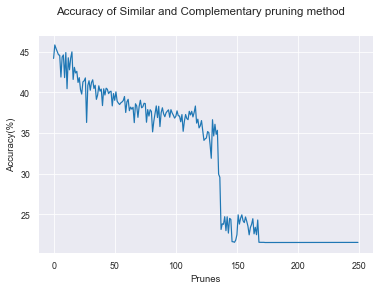

In [92]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure()
plt.plot(test_accs)

plt.suptitle('Accuracy of Similar and Complementary pruning method')
plt.xlabel('Prunes')
plt.ylabel('Accuracy(%)')
fig.savefig('similarandcomp.png', dpi=300, bbox_inches='tight', pad_inches = 0)

In [22]:
test_accs_small_only = [45.62145027077004, 45.225201426495836, 46.796988508783514, 43.54774798573504, 43.55435213313961, 44.58459912825254, 42.88072909787346, 43.94399683000925, 44.71668207634394, 44.67045304451195, 44.776119402985074, 44.51195350680227, 42.16087703077533, 43.521331396116764, 41.005151234975564, 43.158103288865405, 42.464667811385546, 42.57033416985867, 41.52027473253203, 44.07607977810065, 43.072249372605995, 41.23629639413552, 40.397569673755115, 40.59569409589222, 38.984282129177124, 41.903315281997095, 40.879672434288736, 41.21648395192181, 40.77400607581561, 38.81917844406287, 39.98811253467177, 40.84004754986131, 39.9154669132215, 40.50984017963281, 38.898428212917715, 38.218201030246995, 40.47021529520539, 40.63531898031964, 40.648527275128785, 41.077796856425834, 40.19284110421344, 40.98533879276186, 39.7173424910844, 39.28146876238278, 40.42398626337339, 39.882446176198656, 38.96446968696342, 39.836217144366664, 38.60784572711663, 40.84004754986131, 40.19284110421344, 40.1598203671906, 39.18240655131422, 39.88905032360322, 39.71073834367983, 39.24844802535993, 39.52582221635187, 39.96169594505349, 41.051380266807556, 38.64086646413948, 36.804913485669, 37.670056795667676, 37.425703341698586, 39.61828028001585, 36.97001717078325, 37.947430986659626, 38.56822084268921, 40.30511161009114, 37.280412098798045, 37.095495971470086, 39.45317659490159, 39.03711530841368, 39.189010698718796, 38.488971073834364, 37.86818121780478, 39.06353189803197, 39.7173424910844, 38.80597014925373, 38.91824065513143, 39.40034341566504, 37.8417646281865, 37.37287016246202, 38.04649319772817, 38.93144894994056, 36.17751948223484, 39.968300092458065, 39.34090608902391, 39.142781666886805, 38.594637432307486, 36.77189274864615, 37.45872407872144, 38.42292959978867, 38.11253467177387, 38.50878351604808, 37.934222691850486, 37.96063928146876, 39.48619733192445, 37.71628582749967, 38.27103420948356, 38.70690793818518, 39.103156782459386, 38.17857614581958, 38.119138819178445, 37.81534803856822, 38.2842425042927, 37.438911636507726, 38.99088627658169, 37.353057720248316, 38.39651301017039, 38.03988905032361, 38.19838858803328, 38.244617619865274, 36.62660150574561, 37.425703341698586, 36.97001717078325, 36.85114251750099, 36.77849689605072, 38.65407475894862, 37.062475234447234, 38.713512085589755, 37.72288997490424, 36.600184916127326, 37.914410249636774, 38.449346189406945, 38.06630563994188, 37.26059965658434, 36.369039756967375, 37.075683529256374, 36.283185840707965, 35.35200105666358, 37.41909919429401, 36.67943468498217, 36.23035266147141, 36.963413023378685, 36.91718399154669, 36.56056003169991, 37.34645357284375, 37.38607845727117, 37.0030379078061, 36.184123629639416, 36.223748514066834, 33.60190199445252, 37.27380795139347, 37.92761854444591, 36.28978998811254, 37.306828688416324, 35.60956280544182, 36.39545634658566, 36.804913485669, 35.71522916391494, 36.8709549597147, 35.5699379210144, 35.86712455422005, 35.55672962620526, 36.28978998811254, 35.13406419231278, 36.098269713380006, 35.87372870162462, 35.70862501651037, 35.45106326773214, 35.51050059437327, 35.47087570994585, 36.23695680887597, 36.26337339849425, 36.58037247391362, 36.197331924448555, 37.06907938185181, 35.58314621582353, 34.55289922071061, 33.27169462422401, 34.850085853916255, 35.39823008849557, 35.36520935147273, 35.47087570994585, 35.9001452912429, 35.99920750231146, 35.25293884559503, 33.23206973979659, 32.19521859727909, 33.04054946506406, 34.01135913353586, 33.07357020208691, 33.839651301017035, 33.364152687887994, 34.57271166292431, 36.04543653414344, 34.13683793422269, 33.11319508651433, 32.78298771628583, 32.57825914674415, 33.740589089948486, 33.14621582353718, 33.324527803460576, 32.99432043323207, 33.46981904636112, 34.189671113459255, 34.737815348038566, 34.94914806498481, 35.53691718399155, 34.87650244353454, 34.12362963941355, 34.47364945185576, 34.361378945978075, 33.925505217276445, 34.62554484216088, 34.83027341170255, 32.888654074758946, 33.95192180689473, 33.31131950865143, 33.4301941619337, 33.99154669132215, 33.41698586712455, 33.265090476819445, 33.60190199445252, 34.301941619336944, 34.4868577466649, 33.839651301017035, 33.88588033284903, 33.01413287544578, 32.55184255712587, 32.11596882842425, 32.57825914674415, 32.88204992735438, 31.376304319112403, 28.767666094307227, 28.985602958658035, 25.64390437194558, 24.996697926297713, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998]


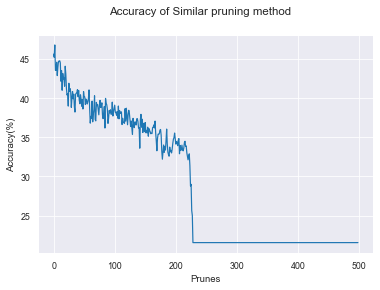

In [91]:
fig = plt.figure()
plt.plot(test_accs_small_only)
plt.suptitle('Accuracy of Similar pruning method')
plt.xlabel('Prunes')
plt.ylabel('Accuracy(%)')
fig.savefig('justsimilar.png', dpi=300, bbox_inches='tight', pad_inches = 0)

In [64]:
test_accs_3 = [43.4024567428345, 45.04688944657245, 45.65447100779289, 46.12336547351737, 45.35068022718267, 43.158103288865405, 43.924184387795535, 44.74309866596222, 43.996830009245805, 43.44208162726192, 42.54391758024039, 44.42609959054286, 41.08440100383041, 42.827895918636905, 43.607185312376174, 42.0353982300885, 43.48831065909391, 43.23074891031568, 39.80980055474838, 39.869237881389516, 42.12785629375247, 40.5560692114648, 42.45145951657641, 41.7910447761194, 40.291903315282, 42.19389776779818, 42.6297714964998, 41.01175538238013, 41.22969224673095, 40.483423590014525, 41.07119270902126, 40.69475630696077, 39.585259542993, 40.43719455818254, 39.71073834367983, 39.869237881389516, 40.648527275128785, 39.75036322810725, 38.11253467177387, 39.94848765024435, 38.70030379078061, 39.591863690397574, 40.32492405230485, 39.116365077268526, 39.71073834367983, 38.64747061154405, 37.478536520935144, 38.2842425042927, 37.755910711927086, 38.158763703605864, 39.18240655131422, 39.26165632016907, 40.12019548276318, 38.70030379078061, 39.50600977413816, 38.33707568352926, 40.27209087306829, 38.81917844406287, 38.70030379078061, 38.25122176726985, 38.27103420948356, 38.88521991810857, 38.82578259146744, 37.63043191124026, 38.70690793818518, 38.62765816933034, 37.2011623299432, 39.677717606656984, 38.33707568352926, 38.23801347246071, 36.137894597807424, 37.9078061022322, 37.537973847576275, 38.449346189406945, 39.189010698718796, 37.92761854444591, 37.24739136177519, 38.7465328226126, 38.99088627658169, 39.72394663848897, 37.65024435345397, 38.488971073834364, 37.108704266279226, 38.38330471536125, 38.21159688284242, 36.963413023378685, 38.19838858803328, 38.944657244749706, 39.3871351208559, 37.438911636507726, 38.059701492537314, 39.30788535200105, 37.67666094307225, 36.98322546559239, 37.59080702681284, 38.350283978338396, 37.41909919429401, 37.50495311055343, 38.49557522123894, 38.44274204200238, 39.274864614978206, 35.31898031964074, 36.88416325452384, 37.914410249636774, 36.25676925108968, 36.01241579712059, 35.16708492933562, 35.41143838330471, 37.564390437194554, 36.98322546559239, 36.89076740192841, 36.454893673226785, 38.317263241315544, 36.71245542200502, 36.976621318187824, 37.392682604675734, 35.00858539162594, 36.07185312376172, 36.10487386078457, 34.275525029718665, 36.54735173689077, 35.94637432307489, 35.979395060097744, 36.82472592788271, 37.03605864482895, 35.919957733456606, 37.22757891956148, 36.89076740192841, 35.59635451063268, 36.34922731475366, 36.098269713380006, 37.379474309866595, 36.44828952582221, 35.0614185708625, 35.39823008849557, 35.48408400475498, 36.11147800818914, 35.62277110025096, 36.74547615902787, 34.94254391758024, 35.834103817197196, 35.13406419231278, 35.85391625941091, 35.345396909259016, 35.173689076740196, 35.444459120327565, 36.296394135517104, 35.71522916391494, 35.60956280544182, 35.90674943864747, 36.00581164971602, 35.85391625941091, 36.40206049399023, 35.33879276185444, 35.5699379210144, 35.79447893276978, 34.35477479857351, 34.85669000132083, 34.493461894069476, 34.9293356227711, 35.07462686567165, 33.278298771628585, 32.8094043059041, 31.779157310791177, 35.345396909259016, 35.503896446968696, 32.598071588957865, 25.45238409721305, 26.05336151102893, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998, 21.536124686302998]

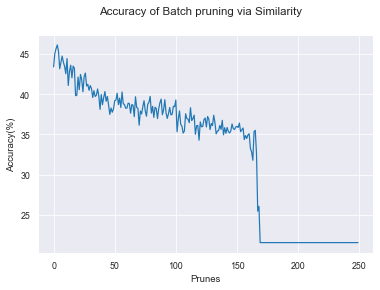

In [90]:
fig = plt.figure()
plt.plot(test_accs_3)
plt.suptitle('Accuracy of Batch pruning via Similarity')
plt.xlabel('Prunes')
plt.ylabel('Accuracy(%)')
fig.savefig('batchprune2.png', dpi=300, bbox_inches='tight', pad_inches = 0)

In [67]:
inflection_sim_comp = 0
for index, value in enumerate(test_accs):
    if value < 30:
        print(index)
        inflection_sim_comp = index
        break


135


In [68]:
inflection_sim = 0
for index, value in enumerate(test_accs_small_only):
    if value < 30:
        print(index)
        inflection_sim = index
        break

224


In [69]:
inflection_2_sim = 0
for index, value in enumerate(test_accs_3):
    if value < 30:
        print(index)
        inflection_2_sim = index
        break

167


In [59]:
flops_2 = [(1030500, [['Net/Linear[fc1]/onnx::Gemm', 1024000], ['Net/ReLU[relu]/onnx::Relu', 1000], ['Net/Linear[fc2]/onnx::Gemm', 5500]]), (1026378, [['Net/Linear[fc1]/onnx::Gemm', 1019904], ['Net/ReLU[relu]/onnx::Relu', 996], ['Net/Linear[fc2]/onnx::Gemm', 5478]]), (1022256, [['Net/Linear[fc1]/onnx::Gemm', 1015808], ['Net/ReLU[relu]/onnx::Relu', 992], ['Net/Linear[fc2]/onnx::Gemm', 5456]]), (1018134, [['Net/Linear[fc1]/onnx::Gemm', 1011712], ['Net/ReLU[relu]/onnx::Relu', 988], ['Net/Linear[fc2]/onnx::Gemm', 5434]]), (1014012, [['Net/Linear[fc1]/onnx::Gemm', 1007616], ['Net/ReLU[relu]/onnx::Relu', 984], ['Net/Linear[fc2]/onnx::Gemm', 5412]]), (1009890, [['Net/Linear[fc1]/onnx::Gemm', 1003520], ['Net/ReLU[relu]/onnx::Relu', 980], ['Net/Linear[fc2]/onnx::Gemm', 5390]]), (1005768, [['Net/Linear[fc1]/onnx::Gemm', 999424], ['Net/ReLU[relu]/onnx::Relu', 976], ['Net/Linear[fc2]/onnx::Gemm', 5368]]), (1001646, [['Net/Linear[fc1]/onnx::Gemm', 995328], ['Net/ReLU[relu]/onnx::Relu', 972], ['Net/Linear[fc2]/onnx::Gemm', 5346]]), (997524, [['Net/Linear[fc1]/onnx::Gemm', 991232], ['Net/ReLU[relu]/onnx::Relu', 968], ['Net/Linear[fc2]/onnx::Gemm', 5324]]), (993402, [['Net/Linear[fc1]/onnx::Gemm', 987136], ['Net/ReLU[relu]/onnx::Relu', 964], ['Net/Linear[fc2]/onnx::Gemm', 5302]]), (989280, [['Net/Linear[fc1]/onnx::Gemm', 983040], ['Net/ReLU[relu]/onnx::Relu', 960], ['Net/Linear[fc2]/onnx::Gemm', 5280]]), (985158, [['Net/Linear[fc1]/onnx::Gemm', 978944], ['Net/ReLU[relu]/onnx::Relu', 956], ['Net/Linear[fc2]/onnx::Gemm', 5258]]), (981036, [['Net/Linear[fc1]/onnx::Gemm', 974848], ['Net/ReLU[relu]/onnx::Relu', 952], ['Net/Linear[fc2]/onnx::Gemm', 5236]]), (976914, [['Net/Linear[fc1]/onnx::Gemm', 970752], ['Net/ReLU[relu]/onnx::Relu', 948], ['Net/Linear[fc2]/onnx::Gemm', 5214]]), (972792, [['Net/Linear[fc1]/onnx::Gemm', 966656], ['Net/ReLU[relu]/onnx::Relu', 944], ['Net/Linear[fc2]/onnx::Gemm', 5192]]), (968670, [['Net/Linear[fc1]/onnx::Gemm', 962560], ['Net/ReLU[relu]/onnx::Relu', 940], ['Net/Linear[fc2]/onnx::Gemm', 5170]]), (964548, [['Net/Linear[fc1]/onnx::Gemm', 958464], ['Net/ReLU[relu]/onnx::Relu', 936], ['Net/Linear[fc2]/onnx::Gemm', 5148]]), (960426, [['Net/Linear[fc1]/onnx::Gemm', 954368], ['Net/ReLU[relu]/onnx::Relu', 932], ['Net/Linear[fc2]/onnx::Gemm', 5126]]), (956304, [['Net/Linear[fc1]/onnx::Gemm', 950272], ['Net/ReLU[relu]/onnx::Relu', 928], ['Net/Linear[fc2]/onnx::Gemm', 5104]]), (952182, [['Net/Linear[fc1]/onnx::Gemm', 946176], ['Net/ReLU[relu]/onnx::Relu', 924], ['Net/Linear[fc2]/onnx::Gemm', 5082]]), (948060, [['Net/Linear[fc1]/onnx::Gemm', 942080], ['Net/ReLU[relu]/onnx::Relu', 920], ['Net/Linear[fc2]/onnx::Gemm', 5060]]), (943938, [['Net/Linear[fc1]/onnx::Gemm', 937984], ['Net/ReLU[relu]/onnx::Relu', 916], ['Net/Linear[fc2]/onnx::Gemm', 5038]]), (939816, [['Net/Linear[fc1]/onnx::Gemm', 933888], ['Net/ReLU[relu]/onnx::Relu', 912], ['Net/Linear[fc2]/onnx::Gemm', 5016]]), (935694, [['Net/Linear[fc1]/onnx::Gemm', 929792], ['Net/ReLU[relu]/onnx::Relu', 908], ['Net/Linear[fc2]/onnx::Gemm', 4994]]), (931572, [['Net/Linear[fc1]/onnx::Gemm', 925696], ['Net/ReLU[relu]/onnx::Relu', 904], ['Net/Linear[fc2]/onnx::Gemm', 4972]]), (927450, [['Net/Linear[fc1]/onnx::Gemm', 921600], ['Net/ReLU[relu]/onnx::Relu', 900], ['Net/Linear[fc2]/onnx::Gemm', 4950]]), (923328, [['Net/Linear[fc1]/onnx::Gemm', 917504], ['Net/ReLU[relu]/onnx::Relu', 896], ['Net/Linear[fc2]/onnx::Gemm', 4928]]), (919206, [['Net/Linear[fc1]/onnx::Gemm', 913408], ['Net/ReLU[relu]/onnx::Relu', 892], ['Net/Linear[fc2]/onnx::Gemm', 4906]]), (915084, [['Net/Linear[fc1]/onnx::Gemm', 909312], ['Net/ReLU[relu]/onnx::Relu', 888], ['Net/Linear[fc2]/onnx::Gemm', 4884]]), (910962, [['Net/Linear[fc1]/onnx::Gemm', 905216], ['Net/ReLU[relu]/onnx::Relu', 884], ['Net/Linear[fc2]/onnx::Gemm', 4862]]), (906840, [['Net/Linear[fc1]/onnx::Gemm', 901120], ['Net/ReLU[relu]/onnx::Relu', 880], ['Net/Linear[fc2]/onnx::Gemm', 4840]]), (902718, [['Net/Linear[fc1]/onnx::Gemm', 897024], ['Net/ReLU[relu]/onnx::Relu', 876], ['Net/Linear[fc2]/onnx::Gemm', 4818]]), (898596, [['Net/Linear[fc1]/onnx::Gemm', 892928], ['Net/ReLU[relu]/onnx::Relu', 872], ['Net/Linear[fc2]/onnx::Gemm', 4796]]), (894474, [['Net/Linear[fc1]/onnx::Gemm', 888832], ['Net/ReLU[relu]/onnx::Relu', 868], ['Net/Linear[fc2]/onnx::Gemm', 4774]]), (890352, [['Net/Linear[fc1]/onnx::Gemm', 884736], ['Net/ReLU[relu]/onnx::Relu', 864], ['Net/Linear[fc2]/onnx::Gemm', 4752]]), (886230, [['Net/Linear[fc1]/onnx::Gemm', 880640], ['Net/ReLU[relu]/onnx::Relu', 860], ['Net/Linear[fc2]/onnx::Gemm', 4730]]), (882108, [['Net/Linear[fc1]/onnx::Gemm', 876544], ['Net/ReLU[relu]/onnx::Relu', 856], ['Net/Linear[fc2]/onnx::Gemm', 4708]]), (877986, [['Net/Linear[fc1]/onnx::Gemm', 872448], ['Net/ReLU[relu]/onnx::Relu', 852], ['Net/Linear[fc2]/onnx::Gemm', 4686]]), (873864, [['Net/Linear[fc1]/onnx::Gemm', 868352], ['Net/ReLU[relu]/onnx::Relu', 848], ['Net/Linear[fc2]/onnx::Gemm', 4664]]), (869742, [['Net/Linear[fc1]/onnx::Gemm', 864256], ['Net/ReLU[relu]/onnx::Relu', 844], ['Net/Linear[fc2]/onnx::Gemm', 4642]]), (865620, [['Net/Linear[fc1]/onnx::Gemm', 860160], ['Net/ReLU[relu]/onnx::Relu', 840], ['Net/Linear[fc2]/onnx::Gemm', 4620]]), (861498, [['Net/Linear[fc1]/onnx::Gemm', 856064], ['Net/ReLU[relu]/onnx::Relu', 836], ['Net/Linear[fc2]/onnx::Gemm', 4598]]), (857376, [['Net/Linear[fc1]/onnx::Gemm', 851968], ['Net/ReLU[relu]/onnx::Relu', 832], ['Net/Linear[fc2]/onnx::Gemm', 4576]]), (853254, [['Net/Linear[fc1]/onnx::Gemm', 847872], ['Net/ReLU[relu]/onnx::Relu', 828], ['Net/Linear[fc2]/onnx::Gemm', 4554]]), (849132, [['Net/Linear[fc1]/onnx::Gemm', 843776], ['Net/ReLU[relu]/onnx::Relu', 824], ['Net/Linear[fc2]/onnx::Gemm', 4532]]), (845010, [['Net/Linear[fc1]/onnx::Gemm', 839680], ['Net/ReLU[relu]/onnx::Relu', 820], ['Net/Linear[fc2]/onnx::Gemm', 4510]]), (840888, [['Net/Linear[fc1]/onnx::Gemm', 835584], ['Net/ReLU[relu]/onnx::Relu', 816], ['Net/Linear[fc2]/onnx::Gemm', 4488]]), (836766, [['Net/Linear[fc1]/onnx::Gemm', 831488], ['Net/ReLU[relu]/onnx::Relu', 812], ['Net/Linear[fc2]/onnx::Gemm', 4466]]), (832644, [['Net/Linear[fc1]/onnx::Gemm', 827392], ['Net/ReLU[relu]/onnx::Relu', 808], ['Net/Linear[fc2]/onnx::Gemm', 4444]]), (828522, [['Net/Linear[fc1]/onnx::Gemm', 823296], ['Net/ReLU[relu]/onnx::Relu', 804], ['Net/Linear[fc2]/onnx::Gemm', 4422]]), (824400, [['Net/Linear[fc1]/onnx::Gemm', 819200], ['Net/ReLU[relu]/onnx::Relu', 800], ['Net/Linear[fc2]/onnx::Gemm', 4400]]), (820278, [['Net/Linear[fc1]/onnx::Gemm', 815104], ['Net/ReLU[relu]/onnx::Relu', 796], ['Net/Linear[fc2]/onnx::Gemm', 4378]]), (816156, [['Net/Linear[fc1]/onnx::Gemm', 811008], ['Net/ReLU[relu]/onnx::Relu', 792], ['Net/Linear[fc2]/onnx::Gemm', 4356]]), (812034, [['Net/Linear[fc1]/onnx::Gemm', 806912], ['Net/ReLU[relu]/onnx::Relu', 788], ['Net/Linear[fc2]/onnx::Gemm', 4334]]), (807912, [['Net/Linear[fc1]/onnx::Gemm', 802816], ['Net/ReLU[relu]/onnx::Relu', 784], ['Net/Linear[fc2]/onnx::Gemm', 4312]]), (803790, [['Net/Linear[fc1]/onnx::Gemm', 798720], ['Net/ReLU[relu]/onnx::Relu', 780], ['Net/Linear[fc2]/onnx::Gemm', 4290]]), (799668, [['Net/Linear[fc1]/onnx::Gemm', 794624], ['Net/ReLU[relu]/onnx::Relu', 776], ['Net/Linear[fc2]/onnx::Gemm', 4268]]), (795546, [['Net/Linear[fc1]/onnx::Gemm', 790528], ['Net/ReLU[relu]/onnx::Relu', 772], ['Net/Linear[fc2]/onnx::Gemm', 4246]]), (791424, [['Net/Linear[fc1]/onnx::Gemm', 786432], ['Net/ReLU[relu]/onnx::Relu', 768], ['Net/Linear[fc2]/onnx::Gemm', 4224]]), (787302, [['Net/Linear[fc1]/onnx::Gemm', 782336], ['Net/ReLU[relu]/onnx::Relu', 764], ['Net/Linear[fc2]/onnx::Gemm', 4202]]), (783180, [['Net/Linear[fc1]/onnx::Gemm', 778240], ['Net/ReLU[relu]/onnx::Relu', 760], ['Net/Linear[fc2]/onnx::Gemm', 4180]]), (779058, [['Net/Linear[fc1]/onnx::Gemm', 774144], ['Net/ReLU[relu]/onnx::Relu', 756], ['Net/Linear[fc2]/onnx::Gemm', 4158]]), (774936, [['Net/Linear[fc1]/onnx::Gemm', 770048], ['Net/ReLU[relu]/onnx::Relu', 752], ['Net/Linear[fc2]/onnx::Gemm', 4136]]), (770814, [['Net/Linear[fc1]/onnx::Gemm', 765952], ['Net/ReLU[relu]/onnx::Relu', 748], ['Net/Linear[fc2]/onnx::Gemm', 4114]]), (766692, [['Net/Linear[fc1]/onnx::Gemm', 761856], ['Net/ReLU[relu]/onnx::Relu', 744], ['Net/Linear[fc2]/onnx::Gemm', 4092]]), (762570, [['Net/Linear[fc1]/onnx::Gemm', 757760], ['Net/ReLU[relu]/onnx::Relu', 740], ['Net/Linear[fc2]/onnx::Gemm', 4070]]), (758448, [['Net/Linear[fc1]/onnx::Gemm', 753664], ['Net/ReLU[relu]/onnx::Relu', 736], ['Net/Linear[fc2]/onnx::Gemm', 4048]]), (754326, [['Net/Linear[fc1]/onnx::Gemm', 749568], ['Net/ReLU[relu]/onnx::Relu', 732], ['Net/Linear[fc2]/onnx::Gemm', 4026]]), (750204, [['Net/Linear[fc1]/onnx::Gemm', 745472], ['Net/ReLU[relu]/onnx::Relu', 728], ['Net/Linear[fc2]/onnx::Gemm', 4004]]), (746082, [['Net/Linear[fc1]/onnx::Gemm', 741376], ['Net/ReLU[relu]/onnx::Relu', 724], ['Net/Linear[fc2]/onnx::Gemm', 3982]]), (741960, [['Net/Linear[fc1]/onnx::Gemm', 737280], ['Net/ReLU[relu]/onnx::Relu', 720], ['Net/Linear[fc2]/onnx::Gemm', 3960]]), (737838, [['Net/Linear[fc1]/onnx::Gemm', 733184], ['Net/ReLU[relu]/onnx::Relu', 716], ['Net/Linear[fc2]/onnx::Gemm', 3938]]), (733716, [['Net/Linear[fc1]/onnx::Gemm', 729088], ['Net/ReLU[relu]/onnx::Relu', 712], ['Net/Linear[fc2]/onnx::Gemm', 3916]]), (729594, [['Net/Linear[fc1]/onnx::Gemm', 724992], ['Net/ReLU[relu]/onnx::Relu', 708], ['Net/Linear[fc2]/onnx::Gemm', 3894]]), (725472, [['Net/Linear[fc1]/onnx::Gemm', 720896], ['Net/ReLU[relu]/onnx::Relu', 704], ['Net/Linear[fc2]/onnx::Gemm', 3872]]), (721350, [['Net/Linear[fc1]/onnx::Gemm', 716800], ['Net/ReLU[relu]/onnx::Relu', 700], ['Net/Linear[fc2]/onnx::Gemm', 3850]]), (717228, [['Net/Linear[fc1]/onnx::Gemm', 712704], ['Net/ReLU[relu]/onnx::Relu', 696], ['Net/Linear[fc2]/onnx::Gemm', 3828]]), (713106, [['Net/Linear[fc1]/onnx::Gemm', 708608], ['Net/ReLU[relu]/onnx::Relu', 692], ['Net/Linear[fc2]/onnx::Gemm', 3806]]), (708984, [['Net/Linear[fc1]/onnx::Gemm', 704512], ['Net/ReLU[relu]/onnx::Relu', 688], ['Net/Linear[fc2]/onnx::Gemm', 3784]]), (704862, [['Net/Linear[fc1]/onnx::Gemm', 700416], ['Net/ReLU[relu]/onnx::Relu', 684], ['Net/Linear[fc2]/onnx::Gemm', 3762]]), (700740, [['Net/Linear[fc1]/onnx::Gemm', 696320], ['Net/ReLU[relu]/onnx::Relu', 680], ['Net/Linear[fc2]/onnx::Gemm', 3740]]), (696618, [['Net/Linear[fc1]/onnx::Gemm', 692224], ['Net/ReLU[relu]/onnx::Relu', 676], ['Net/Linear[fc2]/onnx::Gemm', 3718]]), (692496, [['Net/Linear[fc1]/onnx::Gemm', 688128], ['Net/ReLU[relu]/onnx::Relu', 672], ['Net/Linear[fc2]/onnx::Gemm', 3696]]), (688374, [['Net/Linear[fc1]/onnx::Gemm', 684032], ['Net/ReLU[relu]/onnx::Relu', 668], ['Net/Linear[fc2]/onnx::Gemm', 3674]]), (684252, [['Net/Linear[fc1]/onnx::Gemm', 679936], ['Net/ReLU[relu]/onnx::Relu', 664], ['Net/Linear[fc2]/onnx::Gemm', 3652]]), (680130, [['Net/Linear[fc1]/onnx::Gemm', 675840], ['Net/ReLU[relu]/onnx::Relu', 660], ['Net/Linear[fc2]/onnx::Gemm', 3630]]), (676008, [['Net/Linear[fc1]/onnx::Gemm', 671744], ['Net/ReLU[relu]/onnx::Relu', 656], ['Net/Linear[fc2]/onnx::Gemm', 3608]]), (671886, [['Net/Linear[fc1]/onnx::Gemm', 667648], ['Net/ReLU[relu]/onnx::Relu', 652], ['Net/Linear[fc2]/onnx::Gemm', 3586]]), (667764, [['Net/Linear[fc1]/onnx::Gemm', 663552], ['Net/ReLU[relu]/onnx::Relu', 648], ['Net/Linear[fc2]/onnx::Gemm', 3564]]), (663642, [['Net/Linear[fc1]/onnx::Gemm', 659456], ['Net/ReLU[relu]/onnx::Relu', 644], ['Net/Linear[fc2]/onnx::Gemm', 3542]]), (659520, [['Net/Linear[fc1]/onnx::Gemm', 655360], ['Net/ReLU[relu]/onnx::Relu', 640], ['Net/Linear[fc2]/onnx::Gemm', 3520]]), (655398, [['Net/Linear[fc1]/onnx::Gemm', 651264], ['Net/ReLU[relu]/onnx::Relu', 636], ['Net/Linear[fc2]/onnx::Gemm', 3498]]), (651276, [['Net/Linear[fc1]/onnx::Gemm', 647168], ['Net/ReLU[relu]/onnx::Relu', 632], ['Net/Linear[fc2]/onnx::Gemm', 3476]]), (647154, [['Net/Linear[fc1]/onnx::Gemm', 643072], ['Net/ReLU[relu]/onnx::Relu', 628], ['Net/Linear[fc2]/onnx::Gemm', 3454]]), (643032, [['Net/Linear[fc1]/onnx::Gemm', 638976], ['Net/ReLU[relu]/onnx::Relu', 624], ['Net/Linear[fc2]/onnx::Gemm', 3432]]), (638910, [['Net/Linear[fc1]/onnx::Gemm', 634880], ['Net/ReLU[relu]/onnx::Relu', 620], ['Net/Linear[fc2]/onnx::Gemm', 3410]]), (634788, [['Net/Linear[fc1]/onnx::Gemm', 630784], ['Net/ReLU[relu]/onnx::Relu', 616], ['Net/Linear[fc2]/onnx::Gemm', 3388]]), (630666, [['Net/Linear[fc1]/onnx::Gemm', 626688], ['Net/ReLU[relu]/onnx::Relu', 612], ['Net/Linear[fc2]/onnx::Gemm', 3366]]), (626544, [['Net/Linear[fc1]/onnx::Gemm', 622592], ['Net/ReLU[relu]/onnx::Relu', 608], ['Net/Linear[fc2]/onnx::Gemm', 3344]]), (622422, [['Net/Linear[fc1]/onnx::Gemm', 618496], ['Net/ReLU[relu]/onnx::Relu', 604], ['Net/Linear[fc2]/onnx::Gemm', 3322]]), (618300, [['Net/Linear[fc1]/onnx::Gemm', 614400], ['Net/ReLU[relu]/onnx::Relu', 600], ['Net/Linear[fc2]/onnx::Gemm', 3300]]), (614178, [['Net/Linear[fc1]/onnx::Gemm', 610304], ['Net/ReLU[relu]/onnx::Relu', 596], ['Net/Linear[fc2]/onnx::Gemm', 3278]]), (610056, [['Net/Linear[fc1]/onnx::Gemm', 606208], ['Net/ReLU[relu]/onnx::Relu', 592], ['Net/Linear[fc2]/onnx::Gemm', 3256]]), (605934, [['Net/Linear[fc1]/onnx::Gemm', 602112], ['Net/ReLU[relu]/onnx::Relu', 588], ['Net/Linear[fc2]/onnx::Gemm', 3234]]), (601812, [['Net/Linear[fc1]/onnx::Gemm', 598016], ['Net/ReLU[relu]/onnx::Relu', 584], ['Net/Linear[fc2]/onnx::Gemm', 3212]]), (597690, [['Net/Linear[fc1]/onnx::Gemm', 593920], ['Net/ReLU[relu]/onnx::Relu', 580], ['Net/Linear[fc2]/onnx::Gemm', 3190]]), (593568, [['Net/Linear[fc1]/onnx::Gemm', 589824], ['Net/ReLU[relu]/onnx::Relu', 576], ['Net/Linear[fc2]/onnx::Gemm', 3168]]), (589446, [['Net/Linear[fc1]/onnx::Gemm', 585728], ['Net/ReLU[relu]/onnx::Relu', 572], ['Net/Linear[fc2]/onnx::Gemm', 3146]]), (585324, [['Net/Linear[fc1]/onnx::Gemm', 581632], ['Net/ReLU[relu]/onnx::Relu', 568], ['Net/Linear[fc2]/onnx::Gemm', 3124]]), (581202, [['Net/Linear[fc1]/onnx::Gemm', 577536], ['Net/ReLU[relu]/onnx::Relu', 564], ['Net/Linear[fc2]/onnx::Gemm', 3102]]), (577080, [['Net/Linear[fc1]/onnx::Gemm', 573440], ['Net/ReLU[relu]/onnx::Relu', 560], ['Net/Linear[fc2]/onnx::Gemm', 3080]]), (572958, [['Net/Linear[fc1]/onnx::Gemm', 569344], ['Net/ReLU[relu]/onnx::Relu', 556], ['Net/Linear[fc2]/onnx::Gemm', 3058]]), (568836, [['Net/Linear[fc1]/onnx::Gemm', 565248], ['Net/ReLU[relu]/onnx::Relu', 552], ['Net/Linear[fc2]/onnx::Gemm', 3036]]), (564714, [['Net/Linear[fc1]/onnx::Gemm', 561152], ['Net/ReLU[relu]/onnx::Relu', 548], ['Net/Linear[fc2]/onnx::Gemm', 3014]]), (560592, [['Net/Linear[fc1]/onnx::Gemm', 557056], ['Net/ReLU[relu]/onnx::Relu', 544], ['Net/Linear[fc2]/onnx::Gemm', 2992]]), (556470, [['Net/Linear[fc1]/onnx::Gemm', 552960], ['Net/ReLU[relu]/onnx::Relu', 540], ['Net/Linear[fc2]/onnx::Gemm', 2970]]), (552348, [['Net/Linear[fc1]/onnx::Gemm', 548864], ['Net/ReLU[relu]/onnx::Relu', 536], ['Net/Linear[fc2]/onnx::Gemm', 2948]]), (548226, [['Net/Linear[fc1]/onnx::Gemm', 544768], ['Net/ReLU[relu]/onnx::Relu', 532], ['Net/Linear[fc2]/onnx::Gemm', 2926]]), (544104, [['Net/Linear[fc1]/onnx::Gemm', 540672], ['Net/ReLU[relu]/onnx::Relu', 528], ['Net/Linear[fc2]/onnx::Gemm', 2904]]), (539982, [['Net/Linear[fc1]/onnx::Gemm', 536576], ['Net/ReLU[relu]/onnx::Relu', 524], ['Net/Linear[fc2]/onnx::Gemm', 2882]]), (535860, [['Net/Linear[fc1]/onnx::Gemm', 532480], ['Net/ReLU[relu]/onnx::Relu', 520], ['Net/Linear[fc2]/onnx::Gemm', 2860]]), (531738, [['Net/Linear[fc1]/onnx::Gemm', 528384], ['Net/ReLU[relu]/onnx::Relu', 516], ['Net/Linear[fc2]/onnx::Gemm', 2838]]), (527616, [['Net/Linear[fc1]/onnx::Gemm', 524288], ['Net/ReLU[relu]/onnx::Relu', 512], ['Net/Linear[fc2]/onnx::Gemm', 2816]]), (523494, [['Net/Linear[fc1]/onnx::Gemm', 520192], ['Net/ReLU[relu]/onnx::Relu', 508], ['Net/Linear[fc2]/onnx::Gemm', 2794]]), (519372, [['Net/Linear[fc1]/onnx::Gemm', 516096], ['Net/ReLU[relu]/onnx::Relu', 504], ['Net/Linear[fc2]/onnx::Gemm', 2772]]), (515250, [['Net/Linear[fc1]/onnx::Gemm', 512000], ['Net/ReLU[relu]/onnx::Relu', 500], ['Net/Linear[fc2]/onnx::Gemm', 2750]]), (511128, [['Net/Linear[fc1]/onnx::Gemm', 507904], ['Net/ReLU[relu]/onnx::Relu', 496], ['Net/Linear[fc2]/onnx::Gemm', 2728]]), (507006, [['Net/Linear[fc1]/onnx::Gemm', 503808], ['Net/ReLU[relu]/onnx::Relu', 492], ['Net/Linear[fc2]/onnx::Gemm', 2706]]), (502884, [['Net/Linear[fc1]/onnx::Gemm', 499712], ['Net/ReLU[relu]/onnx::Relu', 488], ['Net/Linear[fc2]/onnx::Gemm', 2684]]), (498762, [['Net/Linear[fc1]/onnx::Gemm', 495616], ['Net/ReLU[relu]/onnx::Relu', 484], ['Net/Linear[fc2]/onnx::Gemm', 2662]]), (494640, [['Net/Linear[fc1]/onnx::Gemm', 491520], ['Net/ReLU[relu]/onnx::Relu', 480], ['Net/Linear[fc2]/onnx::Gemm', 2640]]), (490518, [['Net/Linear[fc1]/onnx::Gemm', 487424], ['Net/ReLU[relu]/onnx::Relu', 476], ['Net/Linear[fc2]/onnx::Gemm', 2618]]), (486396, [['Net/Linear[fc1]/onnx::Gemm', 483328], ['Net/ReLU[relu]/onnx::Relu', 472], ['Net/Linear[fc2]/onnx::Gemm', 2596]]), (482274, [['Net/Linear[fc1]/onnx::Gemm', 479232], ['Net/ReLU[relu]/onnx::Relu', 468], ['Net/Linear[fc2]/onnx::Gemm', 2574]]), (478152, [['Net/Linear[fc1]/onnx::Gemm', 475136], ['Net/ReLU[relu]/onnx::Relu', 464], ['Net/Linear[fc2]/onnx::Gemm', 2552]]), (474030, [['Net/Linear[fc1]/onnx::Gemm', 471040], ['Net/ReLU[relu]/onnx::Relu', 460], ['Net/Linear[fc2]/onnx::Gemm', 2530]]), (469908, [['Net/Linear[fc1]/onnx::Gemm', 466944], ['Net/ReLU[relu]/onnx::Relu', 456], ['Net/Linear[fc2]/onnx::Gemm', 2508]]), (465786, [['Net/Linear[fc1]/onnx::Gemm', 462848], ['Net/ReLU[relu]/onnx::Relu', 452], ['Net/Linear[fc2]/onnx::Gemm', 2486]]), (461664, [['Net/Linear[fc1]/onnx::Gemm', 458752], ['Net/ReLU[relu]/onnx::Relu', 448], ['Net/Linear[fc2]/onnx::Gemm', 2464]]), (457542, [['Net/Linear[fc1]/onnx::Gemm', 454656], ['Net/ReLU[relu]/onnx::Relu', 444], ['Net/Linear[fc2]/onnx::Gemm', 2442]]), (453420, [['Net/Linear[fc1]/onnx::Gemm', 450560], ['Net/ReLU[relu]/onnx::Relu', 440], ['Net/Linear[fc2]/onnx::Gemm', 2420]]), (449298, [['Net/Linear[fc1]/onnx::Gemm', 446464], ['Net/ReLU[relu]/onnx::Relu', 436], ['Net/Linear[fc2]/onnx::Gemm', 2398]]), (445176, [['Net/Linear[fc1]/onnx::Gemm', 442368], ['Net/ReLU[relu]/onnx::Relu', 432], ['Net/Linear[fc2]/onnx::Gemm', 2376]]), (441054, [['Net/Linear[fc1]/onnx::Gemm', 438272], ['Net/ReLU[relu]/onnx::Relu', 428], ['Net/Linear[fc2]/onnx::Gemm', 2354]]), (436932, [['Net/Linear[fc1]/onnx::Gemm', 434176], ['Net/ReLU[relu]/onnx::Relu', 424], ['Net/Linear[fc2]/onnx::Gemm', 2332]]), (432810, [['Net/Linear[fc1]/onnx::Gemm', 430080], ['Net/ReLU[relu]/onnx::Relu', 420], ['Net/Linear[fc2]/onnx::Gemm', 2310]]), (428688, [['Net/Linear[fc1]/onnx::Gemm', 425984], ['Net/ReLU[relu]/onnx::Relu', 416], ['Net/Linear[fc2]/onnx::Gemm', 2288]]), (424566, [['Net/Linear[fc1]/onnx::Gemm', 421888], ['Net/ReLU[relu]/onnx::Relu', 412], ['Net/Linear[fc2]/onnx::Gemm', 2266]]), (420444, [['Net/Linear[fc1]/onnx::Gemm', 417792], ['Net/ReLU[relu]/onnx::Relu', 408], ['Net/Linear[fc2]/onnx::Gemm', 2244]]), (416322, [['Net/Linear[fc1]/onnx::Gemm', 413696], ['Net/ReLU[relu]/onnx::Relu', 404], ['Net/Linear[fc2]/onnx::Gemm', 2222]]), (412200, [['Net/Linear[fc1]/onnx::Gemm', 409600], ['Net/ReLU[relu]/onnx::Relu', 400], ['Net/Linear[fc2]/onnx::Gemm', 2200]]), (408078, [['Net/Linear[fc1]/onnx::Gemm', 405504], ['Net/ReLU[relu]/onnx::Relu', 396], ['Net/Linear[fc2]/onnx::Gemm', 2178]]), (403956, [['Net/Linear[fc1]/onnx::Gemm', 401408], ['Net/ReLU[relu]/onnx::Relu', 392], ['Net/Linear[fc2]/onnx::Gemm', 2156]]), (399834, [['Net/Linear[fc1]/onnx::Gemm', 397312], ['Net/ReLU[relu]/onnx::Relu', 388], ['Net/Linear[fc2]/onnx::Gemm', 2134]]), (395712, [['Net/Linear[fc1]/onnx::Gemm', 393216], ['Net/ReLU[relu]/onnx::Relu', 384], ['Net/Linear[fc2]/onnx::Gemm', 2112]]), (391590, [['Net/Linear[fc1]/onnx::Gemm', 389120], ['Net/ReLU[relu]/onnx::Relu', 380], ['Net/Linear[fc2]/onnx::Gemm', 2090]]), (387468, [['Net/Linear[fc1]/onnx::Gemm', 385024], ['Net/ReLU[relu]/onnx::Relu', 376], ['Net/Linear[fc2]/onnx::Gemm', 2068]]), (383346, [['Net/Linear[fc1]/onnx::Gemm', 380928], ['Net/ReLU[relu]/onnx::Relu', 372], ['Net/Linear[fc2]/onnx::Gemm', 2046]]), (379224, [['Net/Linear[fc1]/onnx::Gemm', 376832], ['Net/ReLU[relu]/onnx::Relu', 368], ['Net/Linear[fc2]/onnx::Gemm', 2024]]), (375102, [['Net/Linear[fc1]/onnx::Gemm', 372736], ['Net/ReLU[relu]/onnx::Relu', 364], ['Net/Linear[fc2]/onnx::Gemm', 2002]]), (370980, [['Net/Linear[fc1]/onnx::Gemm', 368640], ['Net/ReLU[relu]/onnx::Relu', 360], ['Net/Linear[fc2]/onnx::Gemm', 1980]]), (366858, [['Net/Linear[fc1]/onnx::Gemm', 364544], ['Net/ReLU[relu]/onnx::Relu', 356], ['Net/Linear[fc2]/onnx::Gemm', 1958]]), (362736, [['Net/Linear[fc1]/onnx::Gemm', 360448], ['Net/ReLU[relu]/onnx::Relu', 352], ['Net/Linear[fc2]/onnx::Gemm', 1936]]), (358614, [['Net/Linear[fc1]/onnx::Gemm', 356352], ['Net/ReLU[relu]/onnx::Relu', 348], ['Net/Linear[fc2]/onnx::Gemm', 1914]]), (354492, [['Net/Linear[fc1]/onnx::Gemm', 352256], ['Net/ReLU[relu]/onnx::Relu', 344], ['Net/Linear[fc2]/onnx::Gemm', 1892]]), (350370, [['Net/Linear[fc1]/onnx::Gemm', 348160], ['Net/ReLU[relu]/onnx::Relu', 340], ['Net/Linear[fc2]/onnx::Gemm', 1870]]), (346248, [['Net/Linear[fc1]/onnx::Gemm', 344064], ['Net/ReLU[relu]/onnx::Relu', 336], ['Net/Linear[fc2]/onnx::Gemm', 1848]]), (342126, [['Net/Linear[fc1]/onnx::Gemm', 339968], ['Net/ReLU[relu]/onnx::Relu', 332], ['Net/Linear[fc2]/onnx::Gemm', 1826]]), (338004, [['Net/Linear[fc1]/onnx::Gemm', 335872], ['Net/ReLU[relu]/onnx::Relu', 328], ['Net/Linear[fc2]/onnx::Gemm', 1804]]), (333882, [['Net/Linear[fc1]/onnx::Gemm', 331776], ['Net/ReLU[relu]/onnx::Relu', 324], ['Net/Linear[fc2]/onnx::Gemm', 1782]]), (329760, [['Net/Linear[fc1]/onnx::Gemm', 327680], ['Net/ReLU[relu]/onnx::Relu', 320], ['Net/Linear[fc2]/onnx::Gemm', 1760]]), (325638, [['Net/Linear[fc1]/onnx::Gemm', 323584], ['Net/ReLU[relu]/onnx::Relu', 316], ['Net/Linear[fc2]/onnx::Gemm', 1738]]), (321516, [['Net/Linear[fc1]/onnx::Gemm', 319488], ['Net/ReLU[relu]/onnx::Relu', 312], ['Net/Linear[fc2]/onnx::Gemm', 1716]]), (317394, [['Net/Linear[fc1]/onnx::Gemm', 315392], ['Net/ReLU[relu]/onnx::Relu', 308], ['Net/Linear[fc2]/onnx::Gemm', 1694]]), (313272, [['Net/Linear[fc1]/onnx::Gemm', 311296], ['Net/ReLU[relu]/onnx::Relu', 304], ['Net/Linear[fc2]/onnx::Gemm', 1672]]), (309150, [['Net/Linear[fc1]/onnx::Gemm', 307200], ['Net/ReLU[relu]/onnx::Relu', 300], ['Net/Linear[fc2]/onnx::Gemm', 1650]]), (305028, [['Net/Linear[fc1]/onnx::Gemm', 303104], ['Net/ReLU[relu]/onnx::Relu', 296], ['Net/Linear[fc2]/onnx::Gemm', 1628]]), (300906, [['Net/Linear[fc1]/onnx::Gemm', 299008], ['Net/ReLU[relu]/onnx::Relu', 292], ['Net/Linear[fc2]/onnx::Gemm', 1606]]), (296784, [['Net/Linear[fc1]/onnx::Gemm', 294912], ['Net/ReLU[relu]/onnx::Relu', 288], ['Net/Linear[fc2]/onnx::Gemm', 1584]]), (292662, [['Net/Linear[fc1]/onnx::Gemm', 290816], ['Net/ReLU[relu]/onnx::Relu', 284], ['Net/Linear[fc2]/onnx::Gemm', 1562]]), (288540, [['Net/Linear[fc1]/onnx::Gemm', 286720], ['Net/ReLU[relu]/onnx::Relu', 280], ['Net/Linear[fc2]/onnx::Gemm', 1540]]), (284418, [['Net/Linear[fc1]/onnx::Gemm', 282624], ['Net/ReLU[relu]/onnx::Relu', 276], ['Net/Linear[fc2]/onnx::Gemm', 1518]]), (280296, [['Net/Linear[fc1]/onnx::Gemm', 278528], ['Net/ReLU[relu]/onnx::Relu', 272], ['Net/Linear[fc2]/onnx::Gemm', 1496]]), (276174, [['Net/Linear[fc1]/onnx::Gemm', 274432], ['Net/ReLU[relu]/onnx::Relu', 268], ['Net/Linear[fc2]/onnx::Gemm', 1474]]), (272052, [['Net/Linear[fc1]/onnx::Gemm', 270336], ['Net/ReLU[relu]/onnx::Relu', 264], ['Net/Linear[fc2]/onnx::Gemm', 1452]]), (267930, [['Net/Linear[fc1]/onnx::Gemm', 266240], ['Net/ReLU[relu]/onnx::Relu', 260], ['Net/Linear[fc2]/onnx::Gemm', 1430]]), (263808, [['Net/Linear[fc1]/onnx::Gemm', 262144], ['Net/ReLU[relu]/onnx::Relu', 256], ['Net/Linear[fc2]/onnx::Gemm', 1408]]), (259686, [['Net/Linear[fc1]/onnx::Gemm', 258048], ['Net/ReLU[relu]/onnx::Relu', 252], ['Net/Linear[fc2]/onnx::Gemm', 1386]]), (255564, [['Net/Linear[fc1]/onnx::Gemm', 253952], ['Net/ReLU[relu]/onnx::Relu', 248], ['Net/Linear[fc2]/onnx::Gemm', 1364]]), (251442, [['Net/Linear[fc1]/onnx::Gemm', 249856], ['Net/ReLU[relu]/onnx::Relu', 244], ['Net/Linear[fc2]/onnx::Gemm', 1342]]), (247320, [['Net/Linear[fc1]/onnx::Gemm', 245760], ['Net/ReLU[relu]/onnx::Relu', 240], ['Net/Linear[fc2]/onnx::Gemm', 1320]]), (243198, [['Net/Linear[fc1]/onnx::Gemm', 241664], ['Net/ReLU[relu]/onnx::Relu', 236], ['Net/Linear[fc2]/onnx::Gemm', 1298]]), (239076, [['Net/Linear[fc1]/onnx::Gemm', 237568], ['Net/ReLU[relu]/onnx::Relu', 232], ['Net/Linear[fc2]/onnx::Gemm', 1276]]), (234954, [['Net/Linear[fc1]/onnx::Gemm', 233472], ['Net/ReLU[relu]/onnx::Relu', 228], ['Net/Linear[fc2]/onnx::Gemm', 1254]]), (230832, [['Net/Linear[fc1]/onnx::Gemm', 229376], ['Net/ReLU[relu]/onnx::Relu', 224], ['Net/Linear[fc2]/onnx::Gemm', 1232]]), (226710, [['Net/Linear[fc1]/onnx::Gemm', 225280], ['Net/ReLU[relu]/onnx::Relu', 220], ['Net/Linear[fc2]/onnx::Gemm', 1210]]), (222588, [['Net/Linear[fc1]/onnx::Gemm', 221184], ['Net/ReLU[relu]/onnx::Relu', 216], ['Net/Linear[fc2]/onnx::Gemm', 1188]]), (218466, [['Net/Linear[fc1]/onnx::Gemm', 217088], ['Net/ReLU[relu]/onnx::Relu', 212], ['Net/Linear[fc2]/onnx::Gemm', 1166]]), (214344, [['Net/Linear[fc1]/onnx::Gemm', 212992], ['Net/ReLU[relu]/onnx::Relu', 208], ['Net/Linear[fc2]/onnx::Gemm', 1144]]), (210222, [['Net/Linear[fc1]/onnx::Gemm', 208896], ['Net/ReLU[relu]/onnx::Relu', 204], ['Net/Linear[fc2]/onnx::Gemm', 1122]]), (206100, [['Net/Linear[fc1]/onnx::Gemm', 204800], ['Net/ReLU[relu]/onnx::Relu', 200], ['Net/Linear[fc2]/onnx::Gemm', 1100]]), (201978, [['Net/Linear[fc1]/onnx::Gemm', 200704], ['Net/ReLU[relu]/onnx::Relu', 196], ['Net/Linear[fc2]/onnx::Gemm', 1078]]), (197856, [['Net/Linear[fc1]/onnx::Gemm', 196608], ['Net/ReLU[relu]/onnx::Relu', 192], ['Net/Linear[fc2]/onnx::Gemm', 1056]]), (193734, [['Net/Linear[fc1]/onnx::Gemm', 192512], ['Net/ReLU[relu]/onnx::Relu', 188], ['Net/Linear[fc2]/onnx::Gemm', 1034]]), (189612, [['Net/Linear[fc1]/onnx::Gemm', 188416], ['Net/ReLU[relu]/onnx::Relu', 184], ['Net/Linear[fc2]/onnx::Gemm', 1012]]), (185490, [['Net/Linear[fc1]/onnx::Gemm', 184320], ['Net/ReLU[relu]/onnx::Relu', 180], ['Net/Linear[fc2]/onnx::Gemm', 990]]), (181368, [['Net/Linear[fc1]/onnx::Gemm', 180224], ['Net/ReLU[relu]/onnx::Relu', 176], ['Net/Linear[fc2]/onnx::Gemm', 968]]), (177246, [['Net/Linear[fc1]/onnx::Gemm', 176128], ['Net/ReLU[relu]/onnx::Relu', 172], ['Net/Linear[fc2]/onnx::Gemm', 946]]), (173124, [['Net/Linear[fc1]/onnx::Gemm', 172032], ['Net/ReLU[relu]/onnx::Relu', 168], ['Net/Linear[fc2]/onnx::Gemm', 924]]), (169002, [['Net/Linear[fc1]/onnx::Gemm', 167936], ['Net/ReLU[relu]/onnx::Relu', 164], ['Net/Linear[fc2]/onnx::Gemm', 902]]), (164880, [['Net/Linear[fc1]/onnx::Gemm', 163840], ['Net/ReLU[relu]/onnx::Relu', 160], ['Net/Linear[fc2]/onnx::Gemm', 880]]), (160758, [['Net/Linear[fc1]/onnx::Gemm', 159744], ['Net/ReLU[relu]/onnx::Relu', 156], ['Net/Linear[fc2]/onnx::Gemm', 858]]), (156636, [['Net/Linear[fc1]/onnx::Gemm', 155648], ['Net/ReLU[relu]/onnx::Relu', 152], ['Net/Linear[fc2]/onnx::Gemm', 836]]), (152514, [['Net/Linear[fc1]/onnx::Gemm', 151552], ['Net/ReLU[relu]/onnx::Relu', 148], ['Net/Linear[fc2]/onnx::Gemm', 814]]), (148392, [['Net/Linear[fc1]/onnx::Gemm', 147456], ['Net/ReLU[relu]/onnx::Relu', 144], ['Net/Linear[fc2]/onnx::Gemm', 792]]), (144270, [['Net/Linear[fc1]/onnx::Gemm', 143360], ['Net/ReLU[relu]/onnx::Relu', 140], ['Net/Linear[fc2]/onnx::Gemm', 770]]), (140148, [['Net/Linear[fc1]/onnx::Gemm', 139264], ['Net/ReLU[relu]/onnx::Relu', 136], ['Net/Linear[fc2]/onnx::Gemm', 748]]), (136026, [['Net/Linear[fc1]/onnx::Gemm', 135168], ['Net/ReLU[relu]/onnx::Relu', 132], ['Net/Linear[fc2]/onnx::Gemm', 726]]), (131904, [['Net/Linear[fc1]/onnx::Gemm', 131072], ['Net/ReLU[relu]/onnx::Relu', 128], ['Net/Linear[fc2]/onnx::Gemm', 704]]), (127782, [['Net/Linear[fc1]/onnx::Gemm', 126976], ['Net/ReLU[relu]/onnx::Relu', 124], ['Net/Linear[fc2]/onnx::Gemm', 682]]), (123660, [['Net/Linear[fc1]/onnx::Gemm', 122880], ['Net/ReLU[relu]/onnx::Relu', 120], ['Net/Linear[fc2]/onnx::Gemm', 660]]), (119538, [['Net/Linear[fc1]/onnx::Gemm', 118784], ['Net/ReLU[relu]/onnx::Relu', 116], ['Net/Linear[fc2]/onnx::Gemm', 638]]), (115416, [['Net/Linear[fc1]/onnx::Gemm', 114688], ['Net/ReLU[relu]/onnx::Relu', 112], ['Net/Linear[fc2]/onnx::Gemm', 616]]), (111294, [['Net/Linear[fc1]/onnx::Gemm', 110592], ['Net/ReLU[relu]/onnx::Relu', 108], ['Net/Linear[fc2]/onnx::Gemm', 594]]), (107172, [['Net/Linear[fc1]/onnx::Gemm', 106496], ['Net/ReLU[relu]/onnx::Relu', 104], ['Net/Linear[fc2]/onnx::Gemm', 572]]), (103050, [['Net/Linear[fc1]/onnx::Gemm', 102400], ['Net/ReLU[relu]/onnx::Relu', 100], ['Net/Linear[fc2]/onnx::Gemm', 550]]), (98928, [['Net/Linear[fc1]/onnx::Gemm', 98304], ['Net/ReLU[relu]/onnx::Relu', 96], ['Net/Linear[fc2]/onnx::Gemm', 528]]), (94806, [['Net/Linear[fc1]/onnx::Gemm', 94208], ['Net/ReLU[relu]/onnx::Relu', 92], ['Net/Linear[fc2]/onnx::Gemm', 506]]), (90684, [['Net/Linear[fc1]/onnx::Gemm', 90112], ['Net/ReLU[relu]/onnx::Relu', 88], ['Net/Linear[fc2]/onnx::Gemm', 484]]), (86562, [['Net/Linear[fc1]/onnx::Gemm', 86016], ['Net/ReLU[relu]/onnx::Relu', 84], ['Net/Linear[fc2]/onnx::Gemm', 462]]), (82440, [['Net/Linear[fc1]/onnx::Gemm', 81920], ['Net/ReLU[relu]/onnx::Relu', 80], ['Net/Linear[fc2]/onnx::Gemm', 440]]), (78318, [['Net/Linear[fc1]/onnx::Gemm', 77824], ['Net/ReLU[relu]/onnx::Relu', 76], ['Net/Linear[fc2]/onnx::Gemm', 418]]), (74196, [['Net/Linear[fc1]/onnx::Gemm', 73728], ['Net/ReLU[relu]/onnx::Relu', 72], ['Net/Linear[fc2]/onnx::Gemm', 396]]), (70074, [['Net/Linear[fc1]/onnx::Gemm', 69632], ['Net/ReLU[relu]/onnx::Relu', 68], ['Net/Linear[fc2]/onnx::Gemm', 374]]), (65952, [['Net/Linear[fc1]/onnx::Gemm', 65536], ['Net/ReLU[relu]/onnx::Relu', 64], ['Net/Linear[fc2]/onnx::Gemm', 352]]), (61830, [['Net/Linear[fc1]/onnx::Gemm', 61440], ['Net/ReLU[relu]/onnx::Relu', 60], ['Net/Linear[fc2]/onnx::Gemm', 330]]), (57708, [['Net/Linear[fc1]/onnx::Gemm', 57344], ['Net/ReLU[relu]/onnx::Relu', 56], ['Net/Linear[fc2]/onnx::Gemm', 308]]), (53586, [['Net/Linear[fc1]/onnx::Gemm', 53248], ['Net/ReLU[relu]/onnx::Relu', 52], ['Net/Linear[fc2]/onnx::Gemm', 286]]), (49464, [['Net/Linear[fc1]/onnx::Gemm', 49152], ['Net/ReLU[relu]/onnx::Relu', 48], ['Net/Linear[fc2]/onnx::Gemm', 264]]), (45342, [['Net/Linear[fc1]/onnx::Gemm', 45056], ['Net/ReLU[relu]/onnx::Relu', 44], ['Net/Linear[fc2]/onnx::Gemm', 242]]), (41220, [['Net/Linear[fc1]/onnx::Gemm', 40960], ['Net/ReLU[relu]/onnx::Relu', 40], ['Net/Linear[fc2]/onnx::Gemm', 220]]), (37098, [['Net/Linear[fc1]/onnx::Gemm', 36864], ['Net/ReLU[relu]/onnx::Relu', 36], ['Net/Linear[fc2]/onnx::Gemm', 198]]), (32976, [['Net/Linear[fc1]/onnx::Gemm', 32768], ['Net/ReLU[relu]/onnx::Relu', 32], ['Net/Linear[fc2]/onnx::Gemm', 176]]), (28854, [['Net/Linear[fc1]/onnx::Gemm', 28672], ['Net/ReLU[relu]/onnx::Relu', 28], ['Net/Linear[fc2]/onnx::Gemm', 154]]), (24732, [['Net/Linear[fc1]/onnx::Gemm', 24576], ['Net/ReLU[relu]/onnx::Relu', 24], ['Net/Linear[fc2]/onnx::Gemm', 132]]), (20610, [['Net/Linear[fc1]/onnx::Gemm', 20480], ['Net/ReLU[relu]/onnx::Relu', 20], ['Net/Linear[fc2]/onnx::Gemm', 110]]), (16488, [['Net/Linear[fc1]/onnx::Gemm', 16384], ['Net/ReLU[relu]/onnx::Relu', 16], ['Net/Linear[fc2]/onnx::Gemm', 88]]), (12366, [['Net/Linear[fc1]/onnx::Gemm', 12288], ['Net/ReLU[relu]/onnx::Relu', 12], ['Net/Linear[fc2]/onnx::Gemm', 66]]), (8244, [['Net/Linear[fc1]/onnx::Gemm', 8192], ['Net/ReLU[relu]/onnx::Relu', 8], ['Net/Linear[fc2]/onnx::Gemm', 44]]), (4122, [['Net/Linear[fc1]/onnx::Gemm', 4096], ['Net/ReLU[relu]/onnx::Relu', 4], ['Net/Linear[fc2]/onnx::Gemm', 22]])]
flops_3 = [(1030500, [['Net/Linear[fc1]/onnx::Gemm', 1024000], ['Net/ReLU[relu]/onnx::Relu', 1000], ['Net/Linear[fc2]/onnx::Gemm', 5500]]), (1026378, [['Net/Linear[fc1]/onnx::Gemm', 1019904], ['Net/ReLU[relu]/onnx::Relu', 996], ['Net/Linear[fc2]/onnx::Gemm', 5478]]), (1022256, [['Net/Linear[fc1]/onnx::Gemm', 1015808], ['Net/ReLU[relu]/onnx::Relu', 992], ['Net/Linear[fc2]/onnx::Gemm', 5456]]), (1018134, [['Net/Linear[fc1]/onnx::Gemm', 1011712], ['Net/ReLU[relu]/onnx::Relu', 988], ['Net/Linear[fc2]/onnx::Gemm', 5434]]), (1014012, [['Net/Linear[fc1]/onnx::Gemm', 1007616], ['Net/ReLU[relu]/onnx::Relu', 984], ['Net/Linear[fc2]/onnx::Gemm', 5412]]), (1009890, [['Net/Linear[fc1]/onnx::Gemm', 1003520], ['Net/ReLU[relu]/onnx::Relu', 980], ['Net/Linear[fc2]/onnx::Gemm', 5390]]), (1005768, [['Net/Linear[fc1]/onnx::Gemm', 999424], ['Net/ReLU[relu]/onnx::Relu', 976], ['Net/Linear[fc2]/onnx::Gemm', 5368]]), (1001646, [['Net/Linear[fc1]/onnx::Gemm', 995328], ['Net/ReLU[relu]/onnx::Relu', 972], ['Net/Linear[fc2]/onnx::Gemm', 5346]]), (997524, [['Net/Linear[fc1]/onnx::Gemm', 991232], ['Net/ReLU[relu]/onnx::Relu', 968], ['Net/Linear[fc2]/onnx::Gemm', 5324]]), (993402, [['Net/Linear[fc1]/onnx::Gemm', 987136], ['Net/ReLU[relu]/onnx::Relu', 964], ['Net/Linear[fc2]/onnx::Gemm', 5302]]), (989280, [['Net/Linear[fc1]/onnx::Gemm', 983040], ['Net/ReLU[relu]/onnx::Relu', 960], ['Net/Linear[fc2]/onnx::Gemm', 5280]]), (985158, [['Net/Linear[fc1]/onnx::Gemm', 978944], ['Net/ReLU[relu]/onnx::Relu', 956], ['Net/Linear[fc2]/onnx::Gemm', 5258]]), (981036, [['Net/Linear[fc1]/onnx::Gemm', 974848], ['Net/ReLU[relu]/onnx::Relu', 952], ['Net/Linear[fc2]/onnx::Gemm', 5236]]), (976914, [['Net/Linear[fc1]/onnx::Gemm', 970752], ['Net/ReLU[relu]/onnx::Relu', 948], ['Net/Linear[fc2]/onnx::Gemm', 5214]]), (972792, [['Net/Linear[fc1]/onnx::Gemm', 966656], ['Net/ReLU[relu]/onnx::Relu', 944], ['Net/Linear[fc2]/onnx::Gemm', 5192]]), (968670, [['Net/Linear[fc1]/onnx::Gemm', 962560], ['Net/ReLU[relu]/onnx::Relu', 940], ['Net/Linear[fc2]/onnx::Gemm', 5170]]), (964548, [['Net/Linear[fc1]/onnx::Gemm', 958464], ['Net/ReLU[relu]/onnx::Relu', 936], ['Net/Linear[fc2]/onnx::Gemm', 5148]]), (960426, [['Net/Linear[fc1]/onnx::Gemm', 954368], ['Net/ReLU[relu]/onnx::Relu', 932], ['Net/Linear[fc2]/onnx::Gemm', 5126]]), (956304, [['Net/Linear[fc1]/onnx::Gemm', 950272], ['Net/ReLU[relu]/onnx::Relu', 928], ['Net/Linear[fc2]/onnx::Gemm', 5104]]), (952182, [['Net/Linear[fc1]/onnx::Gemm', 946176], ['Net/ReLU[relu]/onnx::Relu', 924], ['Net/Linear[fc2]/onnx::Gemm', 5082]]), (948060, [['Net/Linear[fc1]/onnx::Gemm', 942080], ['Net/ReLU[relu]/onnx::Relu', 920], ['Net/Linear[fc2]/onnx::Gemm', 5060]]), (943938, [['Net/Linear[fc1]/onnx::Gemm', 937984], ['Net/ReLU[relu]/onnx::Relu', 916], ['Net/Linear[fc2]/onnx::Gemm', 5038]]), (939816, [['Net/Linear[fc1]/onnx::Gemm', 933888], ['Net/ReLU[relu]/onnx::Relu', 912], ['Net/Linear[fc2]/onnx::Gemm', 5016]]), (935694, [['Net/Linear[fc1]/onnx::Gemm', 929792], ['Net/ReLU[relu]/onnx::Relu', 908], ['Net/Linear[fc2]/onnx::Gemm', 4994]]), (931572, [['Net/Linear[fc1]/onnx::Gemm', 925696], ['Net/ReLU[relu]/onnx::Relu', 904], ['Net/Linear[fc2]/onnx::Gemm', 4972]]), (927450, [['Net/Linear[fc1]/onnx::Gemm', 921600], ['Net/ReLU[relu]/onnx::Relu', 900], ['Net/Linear[fc2]/onnx::Gemm', 4950]]), (923328, [['Net/Linear[fc1]/onnx::Gemm', 917504], ['Net/ReLU[relu]/onnx::Relu', 896], ['Net/Linear[fc2]/onnx::Gemm', 4928]]), (919206, [['Net/Linear[fc1]/onnx::Gemm', 913408], ['Net/ReLU[relu]/onnx::Relu', 892], ['Net/Linear[fc2]/onnx::Gemm', 4906]]), (915084, [['Net/Linear[fc1]/onnx::Gemm', 909312], ['Net/ReLU[relu]/onnx::Relu', 888], ['Net/Linear[fc2]/onnx::Gemm', 4884]]), (910962, [['Net/Linear[fc1]/onnx::Gemm', 905216], ['Net/ReLU[relu]/onnx::Relu', 884], ['Net/Linear[fc2]/onnx::Gemm', 4862]]), (906840, [['Net/Linear[fc1]/onnx::Gemm', 901120], ['Net/ReLU[relu]/onnx::Relu', 880], ['Net/Linear[fc2]/onnx::Gemm', 4840]]), (902718, [['Net/Linear[fc1]/onnx::Gemm', 897024], ['Net/ReLU[relu]/onnx::Relu', 876], ['Net/Linear[fc2]/onnx::Gemm', 4818]]), (898596, [['Net/Linear[fc1]/onnx::Gemm', 892928], ['Net/ReLU[relu]/onnx::Relu', 872], ['Net/Linear[fc2]/onnx::Gemm', 4796]]), (894474, [['Net/Linear[fc1]/onnx::Gemm', 888832], ['Net/ReLU[relu]/onnx::Relu', 868], ['Net/Linear[fc2]/onnx::Gemm', 4774]]), (890352, [['Net/Linear[fc1]/onnx::Gemm', 884736], ['Net/ReLU[relu]/onnx::Relu', 864], ['Net/Linear[fc2]/onnx::Gemm', 4752]]), (886230, [['Net/Linear[fc1]/onnx::Gemm', 880640], ['Net/ReLU[relu]/onnx::Relu', 860], ['Net/Linear[fc2]/onnx::Gemm', 4730]]), (882108, [['Net/Linear[fc1]/onnx::Gemm', 876544], ['Net/ReLU[relu]/onnx::Relu', 856], ['Net/Linear[fc2]/onnx::Gemm', 4708]]), (877986, [['Net/Linear[fc1]/onnx::Gemm', 872448], ['Net/ReLU[relu]/onnx::Relu', 852], ['Net/Linear[fc2]/onnx::Gemm', 4686]]), (873864, [['Net/Linear[fc1]/onnx::Gemm', 868352], ['Net/ReLU[relu]/onnx::Relu', 848], ['Net/Linear[fc2]/onnx::Gemm', 4664]]), (869742, [['Net/Linear[fc1]/onnx::Gemm', 864256], ['Net/ReLU[relu]/onnx::Relu', 844], ['Net/Linear[fc2]/onnx::Gemm', 4642]]), (865620, [['Net/Linear[fc1]/onnx::Gemm', 860160], ['Net/ReLU[relu]/onnx::Relu', 840], ['Net/Linear[fc2]/onnx::Gemm', 4620]]), (861498, [['Net/Linear[fc1]/onnx::Gemm', 856064], ['Net/ReLU[relu]/onnx::Relu', 836], ['Net/Linear[fc2]/onnx::Gemm', 4598]]), (857376, [['Net/Linear[fc1]/onnx::Gemm', 851968], ['Net/ReLU[relu]/onnx::Relu', 832], ['Net/Linear[fc2]/onnx::Gemm', 4576]]), (853254, [['Net/Linear[fc1]/onnx::Gemm', 847872], ['Net/ReLU[relu]/onnx::Relu', 828], ['Net/Linear[fc2]/onnx::Gemm', 4554]]), (849132, [['Net/Linear[fc1]/onnx::Gemm', 843776], ['Net/ReLU[relu]/onnx::Relu', 824], ['Net/Linear[fc2]/onnx::Gemm', 4532]]), (845010, [['Net/Linear[fc1]/onnx::Gemm', 839680], ['Net/ReLU[relu]/onnx::Relu', 820], ['Net/Linear[fc2]/onnx::Gemm', 4510]]), (840888, [['Net/Linear[fc1]/onnx::Gemm', 835584], ['Net/ReLU[relu]/onnx::Relu', 816], ['Net/Linear[fc2]/onnx::Gemm', 4488]]), (836766, [['Net/Linear[fc1]/onnx::Gemm', 831488], ['Net/ReLU[relu]/onnx::Relu', 812], ['Net/Linear[fc2]/onnx::Gemm', 4466]]), (832644, [['Net/Linear[fc1]/onnx::Gemm', 827392], ['Net/ReLU[relu]/onnx::Relu', 808], ['Net/Linear[fc2]/onnx::Gemm', 4444]]), (828522, [['Net/Linear[fc1]/onnx::Gemm', 823296], ['Net/ReLU[relu]/onnx::Relu', 804], ['Net/Linear[fc2]/onnx::Gemm', 4422]]), (824400, [['Net/Linear[fc1]/onnx::Gemm', 819200], ['Net/ReLU[relu]/onnx::Relu', 800], ['Net/Linear[fc2]/onnx::Gemm', 4400]]), (820278, [['Net/Linear[fc1]/onnx::Gemm', 815104], ['Net/ReLU[relu]/onnx::Relu', 796], ['Net/Linear[fc2]/onnx::Gemm', 4378]]), (816156, [['Net/Linear[fc1]/onnx::Gemm', 811008], ['Net/ReLU[relu]/onnx::Relu', 792], ['Net/Linear[fc2]/onnx::Gemm', 4356]]), (812034, [['Net/Linear[fc1]/onnx::Gemm', 806912], ['Net/ReLU[relu]/onnx::Relu', 788], ['Net/Linear[fc2]/onnx::Gemm', 4334]]), (807912, [['Net/Linear[fc1]/onnx::Gemm', 802816], ['Net/ReLU[relu]/onnx::Relu', 784], ['Net/Linear[fc2]/onnx::Gemm', 4312]]), (803790, [['Net/Linear[fc1]/onnx::Gemm', 798720], ['Net/ReLU[relu]/onnx::Relu', 780], ['Net/Linear[fc2]/onnx::Gemm', 4290]]), (799668, [['Net/Linear[fc1]/onnx::Gemm', 794624], ['Net/ReLU[relu]/onnx::Relu', 776], ['Net/Linear[fc2]/onnx::Gemm', 4268]]), (795546, [['Net/Linear[fc1]/onnx::Gemm', 790528], ['Net/ReLU[relu]/onnx::Relu', 772], ['Net/Linear[fc2]/onnx::Gemm', 4246]]), (791424, [['Net/Linear[fc1]/onnx::Gemm', 786432], ['Net/ReLU[relu]/onnx::Relu', 768], ['Net/Linear[fc2]/onnx::Gemm', 4224]]), (787302, [['Net/Linear[fc1]/onnx::Gemm', 782336], ['Net/ReLU[relu]/onnx::Relu', 764], ['Net/Linear[fc2]/onnx::Gemm', 4202]]), (783180, [['Net/Linear[fc1]/onnx::Gemm', 778240], ['Net/ReLU[relu]/onnx::Relu', 760], ['Net/Linear[fc2]/onnx::Gemm', 4180]]), (779058, [['Net/Linear[fc1]/onnx::Gemm', 774144], ['Net/ReLU[relu]/onnx::Relu', 756], ['Net/Linear[fc2]/onnx::Gemm', 4158]]), (774936, [['Net/Linear[fc1]/onnx::Gemm', 770048], ['Net/ReLU[relu]/onnx::Relu', 752], ['Net/Linear[fc2]/onnx::Gemm', 4136]]), (770814, [['Net/Linear[fc1]/onnx::Gemm', 765952], ['Net/ReLU[relu]/onnx::Relu', 748], ['Net/Linear[fc2]/onnx::Gemm', 4114]]), (766692, [['Net/Linear[fc1]/onnx::Gemm', 761856], ['Net/ReLU[relu]/onnx::Relu', 744], ['Net/Linear[fc2]/onnx::Gemm', 4092]]), (762570, [['Net/Linear[fc1]/onnx::Gemm', 757760], ['Net/ReLU[relu]/onnx::Relu', 740], ['Net/Linear[fc2]/onnx::Gemm', 4070]]), (758448, [['Net/Linear[fc1]/onnx::Gemm', 753664], ['Net/ReLU[relu]/onnx::Relu', 736], ['Net/Linear[fc2]/onnx::Gemm', 4048]]), (754326, [['Net/Linear[fc1]/onnx::Gemm', 749568], ['Net/ReLU[relu]/onnx::Relu', 732], ['Net/Linear[fc2]/onnx::Gemm', 4026]]), (750204, [['Net/Linear[fc1]/onnx::Gemm', 745472], ['Net/ReLU[relu]/onnx::Relu', 728], ['Net/Linear[fc2]/onnx::Gemm', 4004]]), (746082, [['Net/Linear[fc1]/onnx::Gemm', 741376], ['Net/ReLU[relu]/onnx::Relu', 724], ['Net/Linear[fc2]/onnx::Gemm', 3982]]), (741960, [['Net/Linear[fc1]/onnx::Gemm', 737280], ['Net/ReLU[relu]/onnx::Relu', 720], ['Net/Linear[fc2]/onnx::Gemm', 3960]]), (737838, [['Net/Linear[fc1]/onnx::Gemm', 733184], ['Net/ReLU[relu]/onnx::Relu', 716], ['Net/Linear[fc2]/onnx::Gemm', 3938]]), (733716, [['Net/Linear[fc1]/onnx::Gemm', 729088], ['Net/ReLU[relu]/onnx::Relu', 712], ['Net/Linear[fc2]/onnx::Gemm', 3916]]), (729594, [['Net/Linear[fc1]/onnx::Gemm', 724992], ['Net/ReLU[relu]/onnx::Relu', 708], ['Net/Linear[fc2]/onnx::Gemm', 3894]]), (725472, [['Net/Linear[fc1]/onnx::Gemm', 720896], ['Net/ReLU[relu]/onnx::Relu', 704], ['Net/Linear[fc2]/onnx::Gemm', 3872]]), (721350, [['Net/Linear[fc1]/onnx::Gemm', 716800], ['Net/ReLU[relu]/onnx::Relu', 700], ['Net/Linear[fc2]/onnx::Gemm', 3850]]), (717228, [['Net/Linear[fc1]/onnx::Gemm', 712704], ['Net/ReLU[relu]/onnx::Relu', 696], ['Net/Linear[fc2]/onnx::Gemm', 3828]]), (713106, [['Net/Linear[fc1]/onnx::Gemm', 708608], ['Net/ReLU[relu]/onnx::Relu', 692], ['Net/Linear[fc2]/onnx::Gemm', 3806]]), (708984, [['Net/Linear[fc1]/onnx::Gemm', 704512], ['Net/ReLU[relu]/onnx::Relu', 688], ['Net/Linear[fc2]/onnx::Gemm', 3784]]), (704862, [['Net/Linear[fc1]/onnx::Gemm', 700416], ['Net/ReLU[relu]/onnx::Relu', 684], ['Net/Linear[fc2]/onnx::Gemm', 3762]]), (700740, [['Net/Linear[fc1]/onnx::Gemm', 696320], ['Net/ReLU[relu]/onnx::Relu', 680], ['Net/Linear[fc2]/onnx::Gemm', 3740]]), (696618, [['Net/Linear[fc1]/onnx::Gemm', 692224], ['Net/ReLU[relu]/onnx::Relu', 676], ['Net/Linear[fc2]/onnx::Gemm', 3718]]), (692496, [['Net/Linear[fc1]/onnx::Gemm', 688128], ['Net/ReLU[relu]/onnx::Relu', 672], ['Net/Linear[fc2]/onnx::Gemm', 3696]]), (688374, [['Net/Linear[fc1]/onnx::Gemm', 684032], ['Net/ReLU[relu]/onnx::Relu', 668], ['Net/Linear[fc2]/onnx::Gemm', 3674]]), (684252, [['Net/Linear[fc1]/onnx::Gemm', 679936], ['Net/ReLU[relu]/onnx::Relu', 664], ['Net/Linear[fc2]/onnx::Gemm', 3652]]), (680130, [['Net/Linear[fc1]/onnx::Gemm', 675840], ['Net/ReLU[relu]/onnx::Relu', 660], ['Net/Linear[fc2]/onnx::Gemm', 3630]]), (676008, [['Net/Linear[fc1]/onnx::Gemm', 671744], ['Net/ReLU[relu]/onnx::Relu', 656], ['Net/Linear[fc2]/onnx::Gemm', 3608]]), (671886, [['Net/Linear[fc1]/onnx::Gemm', 667648], ['Net/ReLU[relu]/onnx::Relu', 652], ['Net/Linear[fc2]/onnx::Gemm', 3586]]), (667764, [['Net/Linear[fc1]/onnx::Gemm', 663552], ['Net/ReLU[relu]/onnx::Relu', 648], ['Net/Linear[fc2]/onnx::Gemm', 3564]]), (663642, [['Net/Linear[fc1]/onnx::Gemm', 659456], ['Net/ReLU[relu]/onnx::Relu', 644], ['Net/Linear[fc2]/onnx::Gemm', 3542]]), (659520, [['Net/Linear[fc1]/onnx::Gemm', 655360], ['Net/ReLU[relu]/onnx::Relu', 640], ['Net/Linear[fc2]/onnx::Gemm', 3520]]), (655398, [['Net/Linear[fc1]/onnx::Gemm', 651264], ['Net/ReLU[relu]/onnx::Relu', 636], ['Net/Linear[fc2]/onnx::Gemm', 3498]]), (651276, [['Net/Linear[fc1]/onnx::Gemm', 647168], ['Net/ReLU[relu]/onnx::Relu', 632], ['Net/Linear[fc2]/onnx::Gemm', 3476]]), (647154, [['Net/Linear[fc1]/onnx::Gemm', 643072], ['Net/ReLU[relu]/onnx::Relu', 628], ['Net/Linear[fc2]/onnx::Gemm', 3454]]), (643032, [['Net/Linear[fc1]/onnx::Gemm', 638976], ['Net/ReLU[relu]/onnx::Relu', 624], ['Net/Linear[fc2]/onnx::Gemm', 3432]]), (638910, [['Net/Linear[fc1]/onnx::Gemm', 634880], ['Net/ReLU[relu]/onnx::Relu', 620], ['Net/Linear[fc2]/onnx::Gemm', 3410]]), (634788, [['Net/Linear[fc1]/onnx::Gemm', 630784], ['Net/ReLU[relu]/onnx::Relu', 616], ['Net/Linear[fc2]/onnx::Gemm', 3388]]), (630666, [['Net/Linear[fc1]/onnx::Gemm', 626688], ['Net/ReLU[relu]/onnx::Relu', 612], ['Net/Linear[fc2]/onnx::Gemm', 3366]]), (626544, [['Net/Linear[fc1]/onnx::Gemm', 622592], ['Net/ReLU[relu]/onnx::Relu', 608], ['Net/Linear[fc2]/onnx::Gemm', 3344]]), (622422, [['Net/Linear[fc1]/onnx::Gemm', 618496], ['Net/ReLU[relu]/onnx::Relu', 604], ['Net/Linear[fc2]/onnx::Gemm', 3322]]), (618300, [['Net/Linear[fc1]/onnx::Gemm', 614400], ['Net/ReLU[relu]/onnx::Relu', 600], ['Net/Linear[fc2]/onnx::Gemm', 3300]]), (614178, [['Net/Linear[fc1]/onnx::Gemm', 610304], ['Net/ReLU[relu]/onnx::Relu', 596], ['Net/Linear[fc2]/onnx::Gemm', 3278]]), (610056, [['Net/Linear[fc1]/onnx::Gemm', 606208], ['Net/ReLU[relu]/onnx::Relu', 592], ['Net/Linear[fc2]/onnx::Gemm', 3256]]), (605934, [['Net/Linear[fc1]/onnx::Gemm', 602112], ['Net/ReLU[relu]/onnx::Relu', 588], ['Net/Linear[fc2]/onnx::Gemm', 3234]]), (601812, [['Net/Linear[fc1]/onnx::Gemm', 598016], ['Net/ReLU[relu]/onnx::Relu', 584], ['Net/Linear[fc2]/onnx::Gemm', 3212]]), (597690, [['Net/Linear[fc1]/onnx::Gemm', 593920], ['Net/ReLU[relu]/onnx::Relu', 580], ['Net/Linear[fc2]/onnx::Gemm', 3190]]), (593568, [['Net/Linear[fc1]/onnx::Gemm', 589824], ['Net/ReLU[relu]/onnx::Relu', 576], ['Net/Linear[fc2]/onnx::Gemm', 3168]]), (589446, [['Net/Linear[fc1]/onnx::Gemm', 585728], ['Net/ReLU[relu]/onnx::Relu', 572], ['Net/Linear[fc2]/onnx::Gemm', 3146]]), (585324, [['Net/Linear[fc1]/onnx::Gemm', 581632], ['Net/ReLU[relu]/onnx::Relu', 568], ['Net/Linear[fc2]/onnx::Gemm', 3124]]), (581202, [['Net/Linear[fc1]/onnx::Gemm', 577536], ['Net/ReLU[relu]/onnx::Relu', 564], ['Net/Linear[fc2]/onnx::Gemm', 3102]]), (577080, [['Net/Linear[fc1]/onnx::Gemm', 573440], ['Net/ReLU[relu]/onnx::Relu', 560], ['Net/Linear[fc2]/onnx::Gemm', 3080]]), (572958, [['Net/Linear[fc1]/onnx::Gemm', 569344], ['Net/ReLU[relu]/onnx::Relu', 556], ['Net/Linear[fc2]/onnx::Gemm', 3058]]), (568836, [['Net/Linear[fc1]/onnx::Gemm', 565248], ['Net/ReLU[relu]/onnx::Relu', 552], ['Net/Linear[fc2]/onnx::Gemm', 3036]]), (564714, [['Net/Linear[fc1]/onnx::Gemm', 561152], ['Net/ReLU[relu]/onnx::Relu', 548], ['Net/Linear[fc2]/onnx::Gemm', 3014]]), (560592, [['Net/Linear[fc1]/onnx::Gemm', 557056], ['Net/ReLU[relu]/onnx::Relu', 544], ['Net/Linear[fc2]/onnx::Gemm', 2992]]), (556470, [['Net/Linear[fc1]/onnx::Gemm', 552960], ['Net/ReLU[relu]/onnx::Relu', 540], ['Net/Linear[fc2]/onnx::Gemm', 2970]]), (552348, [['Net/Linear[fc1]/onnx::Gemm', 548864], ['Net/ReLU[relu]/onnx::Relu', 536], ['Net/Linear[fc2]/onnx::Gemm', 2948]]), (548226, [['Net/Linear[fc1]/onnx::Gemm', 544768], ['Net/ReLU[relu]/onnx::Relu', 532], ['Net/Linear[fc2]/onnx::Gemm', 2926]]), (544104, [['Net/Linear[fc1]/onnx::Gemm', 540672], ['Net/ReLU[relu]/onnx::Relu', 528], ['Net/Linear[fc2]/onnx::Gemm', 2904]]), (539982, [['Net/Linear[fc1]/onnx::Gemm', 536576], ['Net/ReLU[relu]/onnx::Relu', 524], ['Net/Linear[fc2]/onnx::Gemm', 2882]]), (535860, [['Net/Linear[fc1]/onnx::Gemm', 532480], ['Net/ReLU[relu]/onnx::Relu', 520], ['Net/Linear[fc2]/onnx::Gemm', 2860]]), (531738, [['Net/Linear[fc1]/onnx::Gemm', 528384], ['Net/ReLU[relu]/onnx::Relu', 516], ['Net/Linear[fc2]/onnx::Gemm', 2838]]), (527616, [['Net/Linear[fc1]/onnx::Gemm', 524288], ['Net/ReLU[relu]/onnx::Relu', 512], ['Net/Linear[fc2]/onnx::Gemm', 2816]]), (523494, [['Net/Linear[fc1]/onnx::Gemm', 520192], ['Net/ReLU[relu]/onnx::Relu', 508], ['Net/Linear[fc2]/onnx::Gemm', 2794]]), (519372, [['Net/Linear[fc1]/onnx::Gemm', 516096], ['Net/ReLU[relu]/onnx::Relu', 504], ['Net/Linear[fc2]/onnx::Gemm', 2772]]), (515250, [['Net/Linear[fc1]/onnx::Gemm', 512000], ['Net/ReLU[relu]/onnx::Relu', 500], ['Net/Linear[fc2]/onnx::Gemm', 2750]]), (511128, [['Net/Linear[fc1]/onnx::Gemm', 507904], ['Net/ReLU[relu]/onnx::Relu', 496], ['Net/Linear[fc2]/onnx::Gemm', 2728]]), (507006, [['Net/Linear[fc1]/onnx::Gemm', 503808], ['Net/ReLU[relu]/onnx::Relu', 492], ['Net/Linear[fc2]/onnx::Gemm', 2706]]), (502884, [['Net/Linear[fc1]/onnx::Gemm', 499712], ['Net/ReLU[relu]/onnx::Relu', 488], ['Net/Linear[fc2]/onnx::Gemm', 2684]]), (498762, [['Net/Linear[fc1]/onnx::Gemm', 495616], ['Net/ReLU[relu]/onnx::Relu', 484], ['Net/Linear[fc2]/onnx::Gemm', 2662]]), (494640, [['Net/Linear[fc1]/onnx::Gemm', 491520], ['Net/ReLU[relu]/onnx::Relu', 480], ['Net/Linear[fc2]/onnx::Gemm', 2640]]), (490518, [['Net/Linear[fc1]/onnx::Gemm', 487424], ['Net/ReLU[relu]/onnx::Relu', 476], ['Net/Linear[fc2]/onnx::Gemm', 2618]]), (486396, [['Net/Linear[fc1]/onnx::Gemm', 483328], ['Net/ReLU[relu]/onnx::Relu', 472], ['Net/Linear[fc2]/onnx::Gemm', 2596]]), (482274, [['Net/Linear[fc1]/onnx::Gemm', 479232], ['Net/ReLU[relu]/onnx::Relu', 468], ['Net/Linear[fc2]/onnx::Gemm', 2574]]), (478152, [['Net/Linear[fc1]/onnx::Gemm', 475136], ['Net/ReLU[relu]/onnx::Relu', 464], ['Net/Linear[fc2]/onnx::Gemm', 2552]]), (474030, [['Net/Linear[fc1]/onnx::Gemm', 471040], ['Net/ReLU[relu]/onnx::Relu', 460], ['Net/Linear[fc2]/onnx::Gemm', 2530]]), (469908, [['Net/Linear[fc1]/onnx::Gemm', 466944], ['Net/ReLU[relu]/onnx::Relu', 456], ['Net/Linear[fc2]/onnx::Gemm', 2508]]), (465786, [['Net/Linear[fc1]/onnx::Gemm', 462848], ['Net/ReLU[relu]/onnx::Relu', 452], ['Net/Linear[fc2]/onnx::Gemm', 2486]]), (461664, [['Net/Linear[fc1]/onnx::Gemm', 458752], ['Net/ReLU[relu]/onnx::Relu', 448], ['Net/Linear[fc2]/onnx::Gemm', 2464]]), (457542, [['Net/Linear[fc1]/onnx::Gemm', 454656], ['Net/ReLU[relu]/onnx::Relu', 444], ['Net/Linear[fc2]/onnx::Gemm', 2442]]), (453420, [['Net/Linear[fc1]/onnx::Gemm', 450560], ['Net/ReLU[relu]/onnx::Relu', 440], ['Net/Linear[fc2]/onnx::Gemm', 2420]]), (449298, [['Net/Linear[fc1]/onnx::Gemm', 446464], ['Net/ReLU[relu]/onnx::Relu', 436], ['Net/Linear[fc2]/onnx::Gemm', 2398]]), (445176, [['Net/Linear[fc1]/onnx::Gemm', 442368], ['Net/ReLU[relu]/onnx::Relu', 432], ['Net/Linear[fc2]/onnx::Gemm', 2376]]), (441054, [['Net/Linear[fc1]/onnx::Gemm', 438272], ['Net/ReLU[relu]/onnx::Relu', 428], ['Net/Linear[fc2]/onnx::Gemm', 2354]]), (436932, [['Net/Linear[fc1]/onnx::Gemm', 434176], ['Net/ReLU[relu]/onnx::Relu', 424], ['Net/Linear[fc2]/onnx::Gemm', 2332]]), (432810, [['Net/Linear[fc1]/onnx::Gemm', 430080], ['Net/ReLU[relu]/onnx::Relu', 420], ['Net/Linear[fc2]/onnx::Gemm', 2310]]), (428688, [['Net/Linear[fc1]/onnx::Gemm', 425984], ['Net/ReLU[relu]/onnx::Relu', 416], ['Net/Linear[fc2]/onnx::Gemm', 2288]]), (424566, [['Net/Linear[fc1]/onnx::Gemm', 421888], ['Net/ReLU[relu]/onnx::Relu', 412], ['Net/Linear[fc2]/onnx::Gemm', 2266]]), (420444, [['Net/Linear[fc1]/onnx::Gemm', 417792], ['Net/ReLU[relu]/onnx::Relu', 408], ['Net/Linear[fc2]/onnx::Gemm', 2244]]), (416322, [['Net/Linear[fc1]/onnx::Gemm', 413696], ['Net/ReLU[relu]/onnx::Relu', 404], ['Net/Linear[fc2]/onnx::Gemm', 2222]]), (412200, [['Net/Linear[fc1]/onnx::Gemm', 409600], ['Net/ReLU[relu]/onnx::Relu', 400], ['Net/Linear[fc2]/onnx::Gemm', 2200]]), (408078, [['Net/Linear[fc1]/onnx::Gemm', 405504], ['Net/ReLU[relu]/onnx::Relu', 396], ['Net/Linear[fc2]/onnx::Gemm', 2178]]), (403956, [['Net/Linear[fc1]/onnx::Gemm', 401408], ['Net/ReLU[relu]/onnx::Relu', 392], ['Net/Linear[fc2]/onnx::Gemm', 2156]]), (399834, [['Net/Linear[fc1]/onnx::Gemm', 397312], ['Net/ReLU[relu]/onnx::Relu', 388], ['Net/Linear[fc2]/onnx::Gemm', 2134]]), (395712, [['Net/Linear[fc1]/onnx::Gemm', 393216], ['Net/ReLU[relu]/onnx::Relu', 384], ['Net/Linear[fc2]/onnx::Gemm', 2112]]), (391590, [['Net/Linear[fc1]/onnx::Gemm', 389120], ['Net/ReLU[relu]/onnx::Relu', 380], ['Net/Linear[fc2]/onnx::Gemm', 2090]]), (387468, [['Net/Linear[fc1]/onnx::Gemm', 385024], ['Net/ReLU[relu]/onnx::Relu', 376], ['Net/Linear[fc2]/onnx::Gemm', 2068]]), (383346, [['Net/Linear[fc1]/onnx::Gemm', 380928], ['Net/ReLU[relu]/onnx::Relu', 372], ['Net/Linear[fc2]/onnx::Gemm', 2046]]), (379224, [['Net/Linear[fc1]/onnx::Gemm', 376832], ['Net/ReLU[relu]/onnx::Relu', 368], ['Net/Linear[fc2]/onnx::Gemm', 2024]]), (375102, [['Net/Linear[fc1]/onnx::Gemm', 372736], ['Net/ReLU[relu]/onnx::Relu', 364], ['Net/Linear[fc2]/onnx::Gemm', 2002]]), (370980, [['Net/Linear[fc1]/onnx::Gemm', 368640], ['Net/ReLU[relu]/onnx::Relu', 360], ['Net/Linear[fc2]/onnx::Gemm', 1980]]), (366858, [['Net/Linear[fc1]/onnx::Gemm', 364544], ['Net/ReLU[relu]/onnx::Relu', 356], ['Net/Linear[fc2]/onnx::Gemm', 1958]]), (362736, [['Net/Linear[fc1]/onnx::Gemm', 360448], ['Net/ReLU[relu]/onnx::Relu', 352], ['Net/Linear[fc2]/onnx::Gemm', 1936]]), (358614, [['Net/Linear[fc1]/onnx::Gemm', 356352], ['Net/ReLU[relu]/onnx::Relu', 348], ['Net/Linear[fc2]/onnx::Gemm', 1914]]), (354492, [['Net/Linear[fc1]/onnx::Gemm', 352256], ['Net/ReLU[relu]/onnx::Relu', 344], ['Net/Linear[fc2]/onnx::Gemm', 1892]]), (350370, [['Net/Linear[fc1]/onnx::Gemm', 348160], ['Net/ReLU[relu]/onnx::Relu', 340], ['Net/Linear[fc2]/onnx::Gemm', 1870]]), (346248, [['Net/Linear[fc1]/onnx::Gemm', 344064], ['Net/ReLU[relu]/onnx::Relu', 336], ['Net/Linear[fc2]/onnx::Gemm', 1848]]), (342126, [['Net/Linear[fc1]/onnx::Gemm', 339968], ['Net/ReLU[relu]/onnx::Relu', 332], ['Net/Linear[fc2]/onnx::Gemm', 1826]]), (338004, [['Net/Linear[fc1]/onnx::Gemm', 335872], ['Net/ReLU[relu]/onnx::Relu', 328], ['Net/Linear[fc2]/onnx::Gemm', 1804]]), (333882, [['Net/Linear[fc1]/onnx::Gemm', 331776], ['Net/ReLU[relu]/onnx::Relu', 324], ['Net/Linear[fc2]/onnx::Gemm', 1782]]), (329760, [['Net/Linear[fc1]/onnx::Gemm', 327680], ['Net/ReLU[relu]/onnx::Relu', 320], ['Net/Linear[fc2]/onnx::Gemm', 1760]]), (325638, [['Net/Linear[fc1]/onnx::Gemm', 323584], ['Net/ReLU[relu]/onnx::Relu', 316], ['Net/Linear[fc2]/onnx::Gemm', 1738]]), (321516, [['Net/Linear[fc1]/onnx::Gemm', 319488], ['Net/ReLU[relu]/onnx::Relu', 312], ['Net/Linear[fc2]/onnx::Gemm', 1716]]), (317394, [['Net/Linear[fc1]/onnx::Gemm', 315392], ['Net/ReLU[relu]/onnx::Relu', 308], ['Net/Linear[fc2]/onnx::Gemm', 1694]]), (313272, [['Net/Linear[fc1]/onnx::Gemm', 311296], ['Net/ReLU[relu]/onnx::Relu', 304], ['Net/Linear[fc2]/onnx::Gemm', 1672]]), (309150, [['Net/Linear[fc1]/onnx::Gemm', 307200], ['Net/ReLU[relu]/onnx::Relu', 300], ['Net/Linear[fc2]/onnx::Gemm', 1650]]), (305028, [['Net/Linear[fc1]/onnx::Gemm', 303104], ['Net/ReLU[relu]/onnx::Relu', 296], ['Net/Linear[fc2]/onnx::Gemm', 1628]]), (300906, [['Net/Linear[fc1]/onnx::Gemm', 299008], ['Net/ReLU[relu]/onnx::Relu', 292], ['Net/Linear[fc2]/onnx::Gemm', 1606]]), (296784, [['Net/Linear[fc1]/onnx::Gemm', 294912], ['Net/ReLU[relu]/onnx::Relu', 288], ['Net/Linear[fc2]/onnx::Gemm', 1584]]), (292662, [['Net/Linear[fc1]/onnx::Gemm', 290816], ['Net/ReLU[relu]/onnx::Relu', 284], ['Net/Linear[fc2]/onnx::Gemm', 1562]]), (288540, [['Net/Linear[fc1]/onnx::Gemm', 286720], ['Net/ReLU[relu]/onnx::Relu', 280], ['Net/Linear[fc2]/onnx::Gemm', 1540]]), (284418, [['Net/Linear[fc1]/onnx::Gemm', 282624], ['Net/ReLU[relu]/onnx::Relu', 276], ['Net/Linear[fc2]/onnx::Gemm', 1518]]), (280296, [['Net/Linear[fc1]/onnx::Gemm', 278528], ['Net/ReLU[relu]/onnx::Relu', 272], ['Net/Linear[fc2]/onnx::Gemm', 1496]]), (276174, [['Net/Linear[fc1]/onnx::Gemm', 274432], ['Net/ReLU[relu]/onnx::Relu', 268], ['Net/Linear[fc2]/onnx::Gemm', 1474]]), (272052, [['Net/Linear[fc1]/onnx::Gemm', 270336], ['Net/ReLU[relu]/onnx::Relu', 264], ['Net/Linear[fc2]/onnx::Gemm', 1452]]), (267930, [['Net/Linear[fc1]/onnx::Gemm', 266240], ['Net/ReLU[relu]/onnx::Relu', 260], ['Net/Linear[fc2]/onnx::Gemm', 1430]]), (263808, [['Net/Linear[fc1]/onnx::Gemm', 262144], ['Net/ReLU[relu]/onnx::Relu', 256], ['Net/Linear[fc2]/onnx::Gemm', 1408]]), (259686, [['Net/Linear[fc1]/onnx::Gemm', 258048], ['Net/ReLU[relu]/onnx::Relu', 252], ['Net/Linear[fc2]/onnx::Gemm', 1386]]), (255564, [['Net/Linear[fc1]/onnx::Gemm', 253952], ['Net/ReLU[relu]/onnx::Relu', 248], ['Net/Linear[fc2]/onnx::Gemm', 1364]]), (251442, [['Net/Linear[fc1]/onnx::Gemm', 249856], ['Net/ReLU[relu]/onnx::Relu', 244], ['Net/Linear[fc2]/onnx::Gemm', 1342]]), (247320, [['Net/Linear[fc1]/onnx::Gemm', 245760], ['Net/ReLU[relu]/onnx::Relu', 240], ['Net/Linear[fc2]/onnx::Gemm', 1320]]), (243198, [['Net/Linear[fc1]/onnx::Gemm', 241664], ['Net/ReLU[relu]/onnx::Relu', 236], ['Net/Linear[fc2]/onnx::Gemm', 1298]]), (239076, [['Net/Linear[fc1]/onnx::Gemm', 237568], ['Net/ReLU[relu]/onnx::Relu', 232], ['Net/Linear[fc2]/onnx::Gemm', 1276]]), (234954, [['Net/Linear[fc1]/onnx::Gemm', 233472], ['Net/ReLU[relu]/onnx::Relu', 228], ['Net/Linear[fc2]/onnx::Gemm', 1254]]), (230832, [['Net/Linear[fc1]/onnx::Gemm', 229376], ['Net/ReLU[relu]/onnx::Relu', 224], ['Net/Linear[fc2]/onnx::Gemm', 1232]]), (226710, [['Net/Linear[fc1]/onnx::Gemm', 225280], ['Net/ReLU[relu]/onnx::Relu', 220], ['Net/Linear[fc2]/onnx::Gemm', 1210]]), (222588, [['Net/Linear[fc1]/onnx::Gemm', 221184], ['Net/ReLU[relu]/onnx::Relu', 216], ['Net/Linear[fc2]/onnx::Gemm', 1188]]), (218466, [['Net/Linear[fc1]/onnx::Gemm', 217088], ['Net/ReLU[relu]/onnx::Relu', 212], ['Net/Linear[fc2]/onnx::Gemm', 1166]]), (214344, [['Net/Linear[fc1]/onnx::Gemm', 212992], ['Net/ReLU[relu]/onnx::Relu', 208], ['Net/Linear[fc2]/onnx::Gemm', 1144]]), (210222, [['Net/Linear[fc1]/onnx::Gemm', 208896], ['Net/ReLU[relu]/onnx::Relu', 204], ['Net/Linear[fc2]/onnx::Gemm', 1122]]), (206100, [['Net/Linear[fc1]/onnx::Gemm', 204800], ['Net/ReLU[relu]/onnx::Relu', 200], ['Net/Linear[fc2]/onnx::Gemm', 1100]]), (201978, [['Net/Linear[fc1]/onnx::Gemm', 200704], ['Net/ReLU[relu]/onnx::Relu', 196], ['Net/Linear[fc2]/onnx::Gemm', 1078]]), (197856, [['Net/Linear[fc1]/onnx::Gemm', 196608], ['Net/ReLU[relu]/onnx::Relu', 192], ['Net/Linear[fc2]/onnx::Gemm', 1056]]), (193734, [['Net/Linear[fc1]/onnx::Gemm', 192512], ['Net/ReLU[relu]/onnx::Relu', 188], ['Net/Linear[fc2]/onnx::Gemm', 1034]]), (189612, [['Net/Linear[fc1]/onnx::Gemm', 188416], ['Net/ReLU[relu]/onnx::Relu', 184], ['Net/Linear[fc2]/onnx::Gemm', 1012]]), (185490, [['Net/Linear[fc1]/onnx::Gemm', 184320], ['Net/ReLU[relu]/onnx::Relu', 180], ['Net/Linear[fc2]/onnx::Gemm', 990]]), (181368, [['Net/Linear[fc1]/onnx::Gemm', 180224], ['Net/ReLU[relu]/onnx::Relu', 176], ['Net/Linear[fc2]/onnx::Gemm', 968]]), (177246, [['Net/Linear[fc1]/onnx::Gemm', 176128], ['Net/ReLU[relu]/onnx::Relu', 172], ['Net/Linear[fc2]/onnx::Gemm', 946]]), (173124, [['Net/Linear[fc1]/onnx::Gemm', 172032], ['Net/ReLU[relu]/onnx::Relu', 168], ['Net/Linear[fc2]/onnx::Gemm', 924]]), (169002, [['Net/Linear[fc1]/onnx::Gemm', 167936], ['Net/ReLU[relu]/onnx::Relu', 164], ['Net/Linear[fc2]/onnx::Gemm', 902]]), (164880, [['Net/Linear[fc1]/onnx::Gemm', 163840], ['Net/ReLU[relu]/onnx::Relu', 160], ['Net/Linear[fc2]/onnx::Gemm', 880]]), (160758, [['Net/Linear[fc1]/onnx::Gemm', 159744], ['Net/ReLU[relu]/onnx::Relu', 156], ['Net/Linear[fc2]/onnx::Gemm', 858]]), (156636, [['Net/Linear[fc1]/onnx::Gemm', 155648], ['Net/ReLU[relu]/onnx::Relu', 152], ['Net/Linear[fc2]/onnx::Gemm', 836]]), (152514, [['Net/Linear[fc1]/onnx::Gemm', 151552], ['Net/ReLU[relu]/onnx::Relu', 148], ['Net/Linear[fc2]/onnx::Gemm', 814]]), (148392, [['Net/Linear[fc1]/onnx::Gemm', 147456], ['Net/ReLU[relu]/onnx::Relu', 144], ['Net/Linear[fc2]/onnx::Gemm', 792]]), (144270, [['Net/Linear[fc1]/onnx::Gemm', 143360], ['Net/ReLU[relu]/onnx::Relu', 140], ['Net/Linear[fc2]/onnx::Gemm', 770]]), (140148, [['Net/Linear[fc1]/onnx::Gemm', 139264], ['Net/ReLU[relu]/onnx::Relu', 136], ['Net/Linear[fc2]/onnx::Gemm', 748]]), (136026, [['Net/Linear[fc1]/onnx::Gemm', 135168], ['Net/ReLU[relu]/onnx::Relu', 132], ['Net/Linear[fc2]/onnx::Gemm', 726]]), (131904, [['Net/Linear[fc1]/onnx::Gemm', 131072], ['Net/ReLU[relu]/onnx::Relu', 128], ['Net/Linear[fc2]/onnx::Gemm', 704]]), (127782, [['Net/Linear[fc1]/onnx::Gemm', 126976], ['Net/ReLU[relu]/onnx::Relu', 124], ['Net/Linear[fc2]/onnx::Gemm', 682]]), (123660, [['Net/Linear[fc1]/onnx::Gemm', 122880], ['Net/ReLU[relu]/onnx::Relu', 120], ['Net/Linear[fc2]/onnx::Gemm', 660]]), (119538, [['Net/Linear[fc1]/onnx::Gemm', 118784], ['Net/ReLU[relu]/onnx::Relu', 116], ['Net/Linear[fc2]/onnx::Gemm', 638]]), (115416, [['Net/Linear[fc1]/onnx::Gemm', 114688], ['Net/ReLU[relu]/onnx::Relu', 112], ['Net/Linear[fc2]/onnx::Gemm', 616]]), (111294, [['Net/Linear[fc1]/onnx::Gemm', 110592], ['Net/ReLU[relu]/onnx::Relu', 108], ['Net/Linear[fc2]/onnx::Gemm', 594]]), (107172, [['Net/Linear[fc1]/onnx::Gemm', 106496], ['Net/ReLU[relu]/onnx::Relu', 104], ['Net/Linear[fc2]/onnx::Gemm', 572]]), (103050, [['Net/Linear[fc1]/onnx::Gemm', 102400], ['Net/ReLU[relu]/onnx::Relu', 100], ['Net/Linear[fc2]/onnx::Gemm', 550]]), (98928, [['Net/Linear[fc1]/onnx::Gemm', 98304], ['Net/ReLU[relu]/onnx::Relu', 96], ['Net/Linear[fc2]/onnx::Gemm', 528]]), (94806, [['Net/Linear[fc1]/onnx::Gemm', 94208], ['Net/ReLU[relu]/onnx::Relu', 92], ['Net/Linear[fc2]/onnx::Gemm', 506]]), (90684, [['Net/Linear[fc1]/onnx::Gemm', 90112], ['Net/ReLU[relu]/onnx::Relu', 88], ['Net/Linear[fc2]/onnx::Gemm', 484]]), (86562, [['Net/Linear[fc1]/onnx::Gemm', 86016], ['Net/ReLU[relu]/onnx::Relu', 84], ['Net/Linear[fc2]/onnx::Gemm', 462]]), (82440, [['Net/Linear[fc1]/onnx::Gemm', 81920], ['Net/ReLU[relu]/onnx::Relu', 80], ['Net/Linear[fc2]/onnx::Gemm', 440]]), (78318, [['Net/Linear[fc1]/onnx::Gemm', 77824], ['Net/ReLU[relu]/onnx::Relu', 76], ['Net/Linear[fc2]/onnx::Gemm', 418]]), (74196, [['Net/Linear[fc1]/onnx::Gemm', 73728], ['Net/ReLU[relu]/onnx::Relu', 72], ['Net/Linear[fc2]/onnx::Gemm', 396]]), (70074, [['Net/Linear[fc1]/onnx::Gemm', 69632], ['Net/ReLU[relu]/onnx::Relu', 68], ['Net/Linear[fc2]/onnx::Gemm', 374]]), (65952, [['Net/Linear[fc1]/onnx::Gemm', 65536], ['Net/ReLU[relu]/onnx::Relu', 64], ['Net/Linear[fc2]/onnx::Gemm', 352]]), (61830, [['Net/Linear[fc1]/onnx::Gemm', 61440], ['Net/ReLU[relu]/onnx::Relu', 60], ['Net/Linear[fc2]/onnx::Gemm', 330]]), (57708, [['Net/Linear[fc1]/onnx::Gemm', 57344], ['Net/ReLU[relu]/onnx::Relu', 56], ['Net/Linear[fc2]/onnx::Gemm', 308]]), (53586, [['Net/Linear[fc1]/onnx::Gemm', 53248], ['Net/ReLU[relu]/onnx::Relu', 52], ['Net/Linear[fc2]/onnx::Gemm', 286]]), (49464, [['Net/Linear[fc1]/onnx::Gemm', 49152], ['Net/ReLU[relu]/onnx::Relu', 48], ['Net/Linear[fc2]/onnx::Gemm', 264]]), (45342, [['Net/Linear[fc1]/onnx::Gemm', 45056], ['Net/ReLU[relu]/onnx::Relu', 44], ['Net/Linear[fc2]/onnx::Gemm', 242]]), (41220, [['Net/Linear[fc1]/onnx::Gemm', 40960], ['Net/ReLU[relu]/onnx::Relu', 40], ['Net/Linear[fc2]/onnx::Gemm', 220]]), (37098, [['Net/Linear[fc1]/onnx::Gemm', 36864], ['Net/ReLU[relu]/onnx::Relu', 36], ['Net/Linear[fc2]/onnx::Gemm', 198]]), (32976, [['Net/Linear[fc1]/onnx::Gemm', 32768], ['Net/ReLU[relu]/onnx::Relu', 32], ['Net/Linear[fc2]/onnx::Gemm', 176]]), (28854, [['Net/Linear[fc1]/onnx::Gemm', 28672], ['Net/ReLU[relu]/onnx::Relu', 28], ['Net/Linear[fc2]/onnx::Gemm', 154]]), (24732, [['Net/Linear[fc1]/onnx::Gemm', 24576], ['Net/ReLU[relu]/onnx::Relu', 24], ['Net/Linear[fc2]/onnx::Gemm', 132]]), (20610, [['Net/Linear[fc1]/onnx::Gemm', 20480], ['Net/ReLU[relu]/onnx::Relu', 20], ['Net/Linear[fc2]/onnx::Gemm', 110]]), (16488, [['Net/Linear[fc1]/onnx::Gemm', 16384], ['Net/ReLU[relu]/onnx::Relu', 16], ['Net/Linear[fc2]/onnx::Gemm', 88]]), (12366, [['Net/Linear[fc1]/onnx::Gemm', 12288], ['Net/ReLU[relu]/onnx::Relu', 12], ['Net/Linear[fc2]/onnx::Gemm', 66]]), (8244, [['Net/Linear[fc1]/onnx::Gemm', 8192], ['Net/ReLU[relu]/onnx::Relu', 8], ['Net/Linear[fc2]/onnx::Gemm', 44]]), (4122, [['Net/Linear[fc1]/onnx::Gemm', 4096], ['Net/ReLU[relu]/onnx::Relu', 4], ['Net/Linear[fc2]/onnx::Gemm', 22]])]
flops_1 = [(1030500, [['Net/Linear[fc1]/onnx::Gemm', 1024000], ['Net/ReLU[relu]/onnx::Relu', 1000], ['Net/Linear[fc2]/onnx::Gemm', 5500]]), (1028439, [['Net/Linear[fc1]/onnx::Gemm', 1021952], ['Net/ReLU[relu]/onnx::Relu', 998], ['Net/Linear[fc2]/onnx::Gemm', 5489]]), (1026378, [['Net/Linear[fc1]/onnx::Gemm', 1019904], ['Net/ReLU[relu]/onnx::Relu', 996], ['Net/Linear[fc2]/onnx::Gemm', 5478]]), (1024317, [['Net/Linear[fc1]/onnx::Gemm', 1017856], ['Net/ReLU[relu]/onnx::Relu', 994], ['Net/Linear[fc2]/onnx::Gemm', 5467]]), (1022256, [['Net/Linear[fc1]/onnx::Gemm', 1015808], ['Net/ReLU[relu]/onnx::Relu', 992], ['Net/Linear[fc2]/onnx::Gemm', 5456]]), (1020195, [['Net/Linear[fc1]/onnx::Gemm', 1013760], ['Net/ReLU[relu]/onnx::Relu', 990], ['Net/Linear[fc2]/onnx::Gemm', 5445]]), (1018134, [['Net/Linear[fc1]/onnx::Gemm', 1011712], ['Net/ReLU[relu]/onnx::Relu', 988], ['Net/Linear[fc2]/onnx::Gemm', 5434]]), (1016073, [['Net/Linear[fc1]/onnx::Gemm', 1009664], ['Net/ReLU[relu]/onnx::Relu', 986], ['Net/Linear[fc2]/onnx::Gemm', 5423]]), (1014012, [['Net/Linear[fc1]/onnx::Gemm', 1007616], ['Net/ReLU[relu]/onnx::Relu', 984], ['Net/Linear[fc2]/onnx::Gemm', 5412]]), (1011951, [['Net/Linear[fc1]/onnx::Gemm', 1005568], ['Net/ReLU[relu]/onnx::Relu', 982], ['Net/Linear[fc2]/onnx::Gemm', 5401]]), (1009890, [['Net/Linear[fc1]/onnx::Gemm', 1003520], ['Net/ReLU[relu]/onnx::Relu', 980], ['Net/Linear[fc2]/onnx::Gemm', 5390]]), (1007829, [['Net/Linear[fc1]/onnx::Gemm', 1001472], ['Net/ReLU[relu]/onnx::Relu', 978], ['Net/Linear[fc2]/onnx::Gemm', 5379]]), (1005768, [['Net/Linear[fc1]/onnx::Gemm', 999424], ['Net/ReLU[relu]/onnx::Relu', 976], ['Net/Linear[fc2]/onnx::Gemm', 5368]]), (1003707, [['Net/Linear[fc1]/onnx::Gemm', 997376], ['Net/ReLU[relu]/onnx::Relu', 974], ['Net/Linear[fc2]/onnx::Gemm', 5357]]), (1001646, [['Net/Linear[fc1]/onnx::Gemm', 995328], ['Net/ReLU[relu]/onnx::Relu', 972], ['Net/Linear[fc2]/onnx::Gemm', 5346]]), (999585, [['Net/Linear[fc1]/onnx::Gemm', 993280], ['Net/ReLU[relu]/onnx::Relu', 970], ['Net/Linear[fc2]/onnx::Gemm', 5335]]), (997524, [['Net/Linear[fc1]/onnx::Gemm', 991232], ['Net/ReLU[relu]/onnx::Relu', 968], ['Net/Linear[fc2]/onnx::Gemm', 5324]]), (995463, [['Net/Linear[fc1]/onnx::Gemm', 989184], ['Net/ReLU[relu]/onnx::Relu', 966], ['Net/Linear[fc2]/onnx::Gemm', 5313]]), (993402, [['Net/Linear[fc1]/onnx::Gemm', 987136], ['Net/ReLU[relu]/onnx::Relu', 964], ['Net/Linear[fc2]/onnx::Gemm', 5302]]), (991341, [['Net/Linear[fc1]/onnx::Gemm', 985088], ['Net/ReLU[relu]/onnx::Relu', 962], ['Net/Linear[fc2]/onnx::Gemm', 5291]]), (989280, [['Net/Linear[fc1]/onnx::Gemm', 983040], ['Net/ReLU[relu]/onnx::Relu', 960], ['Net/Linear[fc2]/onnx::Gemm', 5280]]), (987219, [['Net/Linear[fc1]/onnx::Gemm', 980992], ['Net/ReLU[relu]/onnx::Relu', 958], ['Net/Linear[fc2]/onnx::Gemm', 5269]]), (985158, [['Net/Linear[fc1]/onnx::Gemm', 978944], ['Net/ReLU[relu]/onnx::Relu', 956], ['Net/Linear[fc2]/onnx::Gemm', 5258]]), (983097, [['Net/Linear[fc1]/onnx::Gemm', 976896], ['Net/ReLU[relu]/onnx::Relu', 954], ['Net/Linear[fc2]/onnx::Gemm', 5247]]), (981036, [['Net/Linear[fc1]/onnx::Gemm', 974848], ['Net/ReLU[relu]/onnx::Relu', 952], ['Net/Linear[fc2]/onnx::Gemm', 5236]]), (978975, [['Net/Linear[fc1]/onnx::Gemm', 972800], ['Net/ReLU[relu]/onnx::Relu', 950], ['Net/Linear[fc2]/onnx::Gemm', 5225]]), (976914, [['Net/Linear[fc1]/onnx::Gemm', 970752], ['Net/ReLU[relu]/onnx::Relu', 948], ['Net/Linear[fc2]/onnx::Gemm', 5214]]), (974853, [['Net/Linear[fc1]/onnx::Gemm', 968704], ['Net/ReLU[relu]/onnx::Relu', 946], ['Net/Linear[fc2]/onnx::Gemm', 5203]]), (972792, [['Net/Linear[fc1]/onnx::Gemm', 966656], ['Net/ReLU[relu]/onnx::Relu', 944], ['Net/Linear[fc2]/onnx::Gemm', 5192]]), (970731, [['Net/Linear[fc1]/onnx::Gemm', 964608], ['Net/ReLU[relu]/onnx::Relu', 942], ['Net/Linear[fc2]/onnx::Gemm', 5181]]), (968670, [['Net/Linear[fc1]/onnx::Gemm', 962560], ['Net/ReLU[relu]/onnx::Relu', 940], ['Net/Linear[fc2]/onnx::Gemm', 5170]]), (966609, [['Net/Linear[fc1]/onnx::Gemm', 960512], ['Net/ReLU[relu]/onnx::Relu', 938], ['Net/Linear[fc2]/onnx::Gemm', 5159]]), (964548, [['Net/Linear[fc1]/onnx::Gemm', 958464], ['Net/ReLU[relu]/onnx::Relu', 936], ['Net/Linear[fc2]/onnx::Gemm', 5148]]), (962487, [['Net/Linear[fc1]/onnx::Gemm', 956416], ['Net/ReLU[relu]/onnx::Relu', 934], ['Net/Linear[fc2]/onnx::Gemm', 5137]]), (960426, [['Net/Linear[fc1]/onnx::Gemm', 954368], ['Net/ReLU[relu]/onnx::Relu', 932], ['Net/Linear[fc2]/onnx::Gemm', 5126]]), (958365, [['Net/Linear[fc1]/onnx::Gemm', 952320], ['Net/ReLU[relu]/onnx::Relu', 930], ['Net/Linear[fc2]/onnx::Gemm', 5115]]), (956304, [['Net/Linear[fc1]/onnx::Gemm', 950272], ['Net/ReLU[relu]/onnx::Relu', 928], ['Net/Linear[fc2]/onnx::Gemm', 5104]]), (954243, [['Net/Linear[fc1]/onnx::Gemm', 948224], ['Net/ReLU[relu]/onnx::Relu', 926], ['Net/Linear[fc2]/onnx::Gemm', 5093]]), (952182, [['Net/Linear[fc1]/onnx::Gemm', 946176], ['Net/ReLU[relu]/onnx::Relu', 924], ['Net/Linear[fc2]/onnx::Gemm', 5082]]), (950121, [['Net/Linear[fc1]/onnx::Gemm', 944128], ['Net/ReLU[relu]/onnx::Relu', 922], ['Net/Linear[fc2]/onnx::Gemm', 5071]]), (948060, [['Net/Linear[fc1]/onnx::Gemm', 942080], ['Net/ReLU[relu]/onnx::Relu', 920], ['Net/Linear[fc2]/onnx::Gemm', 5060]]), (945999, [['Net/Linear[fc1]/onnx::Gemm', 940032], ['Net/ReLU[relu]/onnx::Relu', 918], ['Net/Linear[fc2]/onnx::Gemm', 5049]]), (943938, [['Net/Linear[fc1]/onnx::Gemm', 937984], ['Net/ReLU[relu]/onnx::Relu', 916], ['Net/Linear[fc2]/onnx::Gemm', 5038]]), (941877, [['Net/Linear[fc1]/onnx::Gemm', 935936], ['Net/ReLU[relu]/onnx::Relu', 914], ['Net/Linear[fc2]/onnx::Gemm', 5027]]), (939816, [['Net/Linear[fc1]/onnx::Gemm', 933888], ['Net/ReLU[relu]/onnx::Relu', 912], ['Net/Linear[fc2]/onnx::Gemm', 5016]]), (937755, [['Net/Linear[fc1]/onnx::Gemm', 931840], ['Net/ReLU[relu]/onnx::Relu', 910], ['Net/Linear[fc2]/onnx::Gemm', 5005]]), (935694, [['Net/Linear[fc1]/onnx::Gemm', 929792], ['Net/ReLU[relu]/onnx::Relu', 908], ['Net/Linear[fc2]/onnx::Gemm', 4994]]), (933633, [['Net/Linear[fc1]/onnx::Gemm', 927744], ['Net/ReLU[relu]/onnx::Relu', 906], ['Net/Linear[fc2]/onnx::Gemm', 4983]]), (931572, [['Net/Linear[fc1]/onnx::Gemm', 925696], ['Net/ReLU[relu]/onnx::Relu', 904], ['Net/Linear[fc2]/onnx::Gemm', 4972]]), (929511, [['Net/Linear[fc1]/onnx::Gemm', 923648], ['Net/ReLU[relu]/onnx::Relu', 902], ['Net/Linear[fc2]/onnx::Gemm', 4961]]), (927450, [['Net/Linear[fc1]/onnx::Gemm', 921600], ['Net/ReLU[relu]/onnx::Relu', 900], ['Net/Linear[fc2]/onnx::Gemm', 4950]]), (925389, [['Net/Linear[fc1]/onnx::Gemm', 919552], ['Net/ReLU[relu]/onnx::Relu', 898], ['Net/Linear[fc2]/onnx::Gemm', 4939]]), (923328, [['Net/Linear[fc1]/onnx::Gemm', 917504], ['Net/ReLU[relu]/onnx::Relu', 896], ['Net/Linear[fc2]/onnx::Gemm', 4928]]), (921267, [['Net/Linear[fc1]/onnx::Gemm', 915456], ['Net/ReLU[relu]/onnx::Relu', 894], ['Net/Linear[fc2]/onnx::Gemm', 4917]]), (919206, [['Net/Linear[fc1]/onnx::Gemm', 913408], ['Net/ReLU[relu]/onnx::Relu', 892], ['Net/Linear[fc2]/onnx::Gemm', 4906]]), (917145, [['Net/Linear[fc1]/onnx::Gemm', 911360], ['Net/ReLU[relu]/onnx::Relu', 890], ['Net/Linear[fc2]/onnx::Gemm', 4895]]), (915084, [['Net/Linear[fc1]/onnx::Gemm', 909312], ['Net/ReLU[relu]/onnx::Relu', 888], ['Net/Linear[fc2]/onnx::Gemm', 4884]]), (913023, [['Net/Linear[fc1]/onnx::Gemm', 907264], ['Net/ReLU[relu]/onnx::Relu', 886], ['Net/Linear[fc2]/onnx::Gemm', 4873]]), (910962, [['Net/Linear[fc1]/onnx::Gemm', 905216], ['Net/ReLU[relu]/onnx::Relu', 884], ['Net/Linear[fc2]/onnx::Gemm', 4862]]), (908901, [['Net/Linear[fc1]/onnx::Gemm', 903168], ['Net/ReLU[relu]/onnx::Relu', 882], ['Net/Linear[fc2]/onnx::Gemm', 4851]]), (906840, [['Net/Linear[fc1]/onnx::Gemm', 901120], ['Net/ReLU[relu]/onnx::Relu', 880], ['Net/Linear[fc2]/onnx::Gemm', 4840]]), (904779, [['Net/Linear[fc1]/onnx::Gemm', 899072], ['Net/ReLU[relu]/onnx::Relu', 878], ['Net/Linear[fc2]/onnx::Gemm', 4829]]), (902718, [['Net/Linear[fc1]/onnx::Gemm', 897024], ['Net/ReLU[relu]/onnx::Relu', 876], ['Net/Linear[fc2]/onnx::Gemm', 4818]]), (900657, [['Net/Linear[fc1]/onnx::Gemm', 894976], ['Net/ReLU[relu]/onnx::Relu', 874], ['Net/Linear[fc2]/onnx::Gemm', 4807]]), (898596, [['Net/Linear[fc1]/onnx::Gemm', 892928], ['Net/ReLU[relu]/onnx::Relu', 872], ['Net/Linear[fc2]/onnx::Gemm', 4796]]), (896535, [['Net/Linear[fc1]/onnx::Gemm', 890880], ['Net/ReLU[relu]/onnx::Relu', 870], ['Net/Linear[fc2]/onnx::Gemm', 4785]]), (894474, [['Net/Linear[fc1]/onnx::Gemm', 888832], ['Net/ReLU[relu]/onnx::Relu', 868], ['Net/Linear[fc2]/onnx::Gemm', 4774]]), (892413, [['Net/Linear[fc1]/onnx::Gemm', 886784], ['Net/ReLU[relu]/onnx::Relu', 866], ['Net/Linear[fc2]/onnx::Gemm', 4763]]), (890352, [['Net/Linear[fc1]/onnx::Gemm', 884736], ['Net/ReLU[relu]/onnx::Relu', 864], ['Net/Linear[fc2]/onnx::Gemm', 4752]]), (888291, [['Net/Linear[fc1]/onnx::Gemm', 882688], ['Net/ReLU[relu]/onnx::Relu', 862], ['Net/Linear[fc2]/onnx::Gemm', 4741]]), (886230, [['Net/Linear[fc1]/onnx::Gemm', 880640], ['Net/ReLU[relu]/onnx::Relu', 860], ['Net/Linear[fc2]/onnx::Gemm', 4730]]), (884169, [['Net/Linear[fc1]/onnx::Gemm', 878592], ['Net/ReLU[relu]/onnx::Relu', 858], ['Net/Linear[fc2]/onnx::Gemm', 4719]]), (882108, [['Net/Linear[fc1]/onnx::Gemm', 876544], ['Net/ReLU[relu]/onnx::Relu', 856], ['Net/Linear[fc2]/onnx::Gemm', 4708]]), (880047, [['Net/Linear[fc1]/onnx::Gemm', 874496], ['Net/ReLU[relu]/onnx::Relu', 854], ['Net/Linear[fc2]/onnx::Gemm', 4697]]), (877986, [['Net/Linear[fc1]/onnx::Gemm', 872448], ['Net/ReLU[relu]/onnx::Relu', 852], ['Net/Linear[fc2]/onnx::Gemm', 4686]]), (875925, [['Net/Linear[fc1]/onnx::Gemm', 870400], ['Net/ReLU[relu]/onnx::Relu', 850], ['Net/Linear[fc2]/onnx::Gemm', 4675]]), (873864, [['Net/Linear[fc1]/onnx::Gemm', 868352], ['Net/ReLU[relu]/onnx::Relu', 848], ['Net/Linear[fc2]/onnx::Gemm', 4664]]), (871803, [['Net/Linear[fc1]/onnx::Gemm', 866304], ['Net/ReLU[relu]/onnx::Relu', 846], ['Net/Linear[fc2]/onnx::Gemm', 4653]]), (869742, [['Net/Linear[fc1]/onnx::Gemm', 864256], ['Net/ReLU[relu]/onnx::Relu', 844], ['Net/Linear[fc2]/onnx::Gemm', 4642]]), (867681, [['Net/Linear[fc1]/onnx::Gemm', 862208], ['Net/ReLU[relu]/onnx::Relu', 842], ['Net/Linear[fc2]/onnx::Gemm', 4631]]), (865620, [['Net/Linear[fc1]/onnx::Gemm', 860160], ['Net/ReLU[relu]/onnx::Relu', 840], ['Net/Linear[fc2]/onnx::Gemm', 4620]]), (863559, [['Net/Linear[fc1]/onnx::Gemm', 858112], ['Net/ReLU[relu]/onnx::Relu', 838], ['Net/Linear[fc2]/onnx::Gemm', 4609]]), (861498, [['Net/Linear[fc1]/onnx::Gemm', 856064], ['Net/ReLU[relu]/onnx::Relu', 836], ['Net/Linear[fc2]/onnx::Gemm', 4598]]), (859437, [['Net/Linear[fc1]/onnx::Gemm', 854016], ['Net/ReLU[relu]/onnx::Relu', 834], ['Net/Linear[fc2]/onnx::Gemm', 4587]]), (857376, [['Net/Linear[fc1]/onnx::Gemm', 851968], ['Net/ReLU[relu]/onnx::Relu', 832], ['Net/Linear[fc2]/onnx::Gemm', 4576]]), (855315, [['Net/Linear[fc1]/onnx::Gemm', 849920], ['Net/ReLU[relu]/onnx::Relu', 830], ['Net/Linear[fc2]/onnx::Gemm', 4565]]), (853254, [['Net/Linear[fc1]/onnx::Gemm', 847872], ['Net/ReLU[relu]/onnx::Relu', 828], ['Net/Linear[fc2]/onnx::Gemm', 4554]]), (851193, [['Net/Linear[fc1]/onnx::Gemm', 845824], ['Net/ReLU[relu]/onnx::Relu', 826], ['Net/Linear[fc2]/onnx::Gemm', 4543]]), (849132, [['Net/Linear[fc1]/onnx::Gemm', 843776], ['Net/ReLU[relu]/onnx::Relu', 824], ['Net/Linear[fc2]/onnx::Gemm', 4532]]), (847071, [['Net/Linear[fc1]/onnx::Gemm', 841728], ['Net/ReLU[relu]/onnx::Relu', 822], ['Net/Linear[fc2]/onnx::Gemm', 4521]]), (845010, [['Net/Linear[fc1]/onnx::Gemm', 839680], ['Net/ReLU[relu]/onnx::Relu', 820], ['Net/Linear[fc2]/onnx::Gemm', 4510]]), (842949, [['Net/Linear[fc1]/onnx::Gemm', 837632], ['Net/ReLU[relu]/onnx::Relu', 818], ['Net/Linear[fc2]/onnx::Gemm', 4499]]), (840888, [['Net/Linear[fc1]/onnx::Gemm', 835584], ['Net/ReLU[relu]/onnx::Relu', 816], ['Net/Linear[fc2]/onnx::Gemm', 4488]]), (838827, [['Net/Linear[fc1]/onnx::Gemm', 833536], ['Net/ReLU[relu]/onnx::Relu', 814], ['Net/Linear[fc2]/onnx::Gemm', 4477]]), (836766, [['Net/Linear[fc1]/onnx::Gemm', 831488], ['Net/ReLU[relu]/onnx::Relu', 812], ['Net/Linear[fc2]/onnx::Gemm', 4466]]), (834705, [['Net/Linear[fc1]/onnx::Gemm', 829440], ['Net/ReLU[relu]/onnx::Relu', 810], ['Net/Linear[fc2]/onnx::Gemm', 4455]]), (832644, [['Net/Linear[fc1]/onnx::Gemm', 827392], ['Net/ReLU[relu]/onnx::Relu', 808], ['Net/Linear[fc2]/onnx::Gemm', 4444]]), (830583, [['Net/Linear[fc1]/onnx::Gemm', 825344], ['Net/ReLU[relu]/onnx::Relu', 806], ['Net/Linear[fc2]/onnx::Gemm', 4433]]), (828522, [['Net/Linear[fc1]/onnx::Gemm', 823296], ['Net/ReLU[relu]/onnx::Relu', 804], ['Net/Linear[fc2]/onnx::Gemm', 4422]]), (826461, [['Net/Linear[fc1]/onnx::Gemm', 821248], ['Net/ReLU[relu]/onnx::Relu', 802], ['Net/Linear[fc2]/onnx::Gemm', 4411]]), (824400, [['Net/Linear[fc1]/onnx::Gemm', 819200], ['Net/ReLU[relu]/onnx::Relu', 800], ['Net/Linear[fc2]/onnx::Gemm', 4400]]), (822339, [['Net/Linear[fc1]/onnx::Gemm', 817152], ['Net/ReLU[relu]/onnx::Relu', 798], ['Net/Linear[fc2]/onnx::Gemm', 4389]]), (820278, [['Net/Linear[fc1]/onnx::Gemm', 815104], ['Net/ReLU[relu]/onnx::Relu', 796], ['Net/Linear[fc2]/onnx::Gemm', 4378]]), (818217, [['Net/Linear[fc1]/onnx::Gemm', 813056], ['Net/ReLU[relu]/onnx::Relu', 794], ['Net/Linear[fc2]/onnx::Gemm', 4367]]), (816156, [['Net/Linear[fc1]/onnx::Gemm', 811008], ['Net/ReLU[relu]/onnx::Relu', 792], ['Net/Linear[fc2]/onnx::Gemm', 4356]]), (814095, [['Net/Linear[fc1]/onnx::Gemm', 808960], ['Net/ReLU[relu]/onnx::Relu', 790], ['Net/Linear[fc2]/onnx::Gemm', 4345]]), (812034, [['Net/Linear[fc1]/onnx::Gemm', 806912], ['Net/ReLU[relu]/onnx::Relu', 788], ['Net/Linear[fc2]/onnx::Gemm', 4334]]), (809973, [['Net/Linear[fc1]/onnx::Gemm', 804864], ['Net/ReLU[relu]/onnx::Relu', 786], ['Net/Linear[fc2]/onnx::Gemm', 4323]]), (807912, [['Net/Linear[fc1]/onnx::Gemm', 802816], ['Net/ReLU[relu]/onnx::Relu', 784], ['Net/Linear[fc2]/onnx::Gemm', 4312]]), (805851, [['Net/Linear[fc1]/onnx::Gemm', 800768], ['Net/ReLU[relu]/onnx::Relu', 782], ['Net/Linear[fc2]/onnx::Gemm', 4301]]), (803790, [['Net/Linear[fc1]/onnx::Gemm', 798720], ['Net/ReLU[relu]/onnx::Relu', 780], ['Net/Linear[fc2]/onnx::Gemm', 4290]]), (801729, [['Net/Linear[fc1]/onnx::Gemm', 796672], ['Net/ReLU[relu]/onnx::Relu', 778], ['Net/Linear[fc2]/onnx::Gemm', 4279]]), (799668, [['Net/Linear[fc1]/onnx::Gemm', 794624], ['Net/ReLU[relu]/onnx::Relu', 776], ['Net/Linear[fc2]/onnx::Gemm', 4268]]), (797607, [['Net/Linear[fc1]/onnx::Gemm', 792576], ['Net/ReLU[relu]/onnx::Relu', 774], ['Net/Linear[fc2]/onnx::Gemm', 4257]]), (795546, [['Net/Linear[fc1]/onnx::Gemm', 790528], ['Net/ReLU[relu]/onnx::Relu', 772], ['Net/Linear[fc2]/onnx::Gemm', 4246]]), (793485, [['Net/Linear[fc1]/onnx::Gemm', 788480], ['Net/ReLU[relu]/onnx::Relu', 770], ['Net/Linear[fc2]/onnx::Gemm', 4235]]), (791424, [['Net/Linear[fc1]/onnx::Gemm', 786432], ['Net/ReLU[relu]/onnx::Relu', 768], ['Net/Linear[fc2]/onnx::Gemm', 4224]]), (789363, [['Net/Linear[fc1]/onnx::Gemm', 784384], ['Net/ReLU[relu]/onnx::Relu', 766], ['Net/Linear[fc2]/onnx::Gemm', 4213]]), (787302, [['Net/Linear[fc1]/onnx::Gemm', 782336], ['Net/ReLU[relu]/onnx::Relu', 764], ['Net/Linear[fc2]/onnx::Gemm', 4202]]), (785241, [['Net/Linear[fc1]/onnx::Gemm', 780288], ['Net/ReLU[relu]/onnx::Relu', 762], ['Net/Linear[fc2]/onnx::Gemm', 4191]]), (783180, [['Net/Linear[fc1]/onnx::Gemm', 778240], ['Net/ReLU[relu]/onnx::Relu', 760], ['Net/Linear[fc2]/onnx::Gemm', 4180]]), (781119, [['Net/Linear[fc1]/onnx::Gemm', 776192], ['Net/ReLU[relu]/onnx::Relu', 758], ['Net/Linear[fc2]/onnx::Gemm', 4169]]), (779058, [['Net/Linear[fc1]/onnx::Gemm', 774144], ['Net/ReLU[relu]/onnx::Relu', 756], ['Net/Linear[fc2]/onnx::Gemm', 4158]]), (776997, [['Net/Linear[fc1]/onnx::Gemm', 772096], ['Net/ReLU[relu]/onnx::Relu', 754], ['Net/Linear[fc2]/onnx::Gemm', 4147]]), (774936, [['Net/Linear[fc1]/onnx::Gemm', 770048], ['Net/ReLU[relu]/onnx::Relu', 752], ['Net/Linear[fc2]/onnx::Gemm', 4136]]), (772875, [['Net/Linear[fc1]/onnx::Gemm', 768000], ['Net/ReLU[relu]/onnx::Relu', 750], ['Net/Linear[fc2]/onnx::Gemm', 4125]]), (770814, [['Net/Linear[fc1]/onnx::Gemm', 765952], ['Net/ReLU[relu]/onnx::Relu', 748], ['Net/Linear[fc2]/onnx::Gemm', 4114]]), (768753, [['Net/Linear[fc1]/onnx::Gemm', 763904], ['Net/ReLU[relu]/onnx::Relu', 746], ['Net/Linear[fc2]/onnx::Gemm', 4103]]), (766692, [['Net/Linear[fc1]/onnx::Gemm', 761856], ['Net/ReLU[relu]/onnx::Relu', 744], ['Net/Linear[fc2]/onnx::Gemm', 4092]]), (764631, [['Net/Linear[fc1]/onnx::Gemm', 759808], ['Net/ReLU[relu]/onnx::Relu', 742], ['Net/Linear[fc2]/onnx::Gemm', 4081]]), (762570, [['Net/Linear[fc1]/onnx::Gemm', 757760], ['Net/ReLU[relu]/onnx::Relu', 740], ['Net/Linear[fc2]/onnx::Gemm', 4070]]), (760509, [['Net/Linear[fc1]/onnx::Gemm', 755712], ['Net/ReLU[relu]/onnx::Relu', 738], ['Net/Linear[fc2]/onnx::Gemm', 4059]]), (758448, [['Net/Linear[fc1]/onnx::Gemm', 753664], ['Net/ReLU[relu]/onnx::Relu', 736], ['Net/Linear[fc2]/onnx::Gemm', 4048]]), (756387, [['Net/Linear[fc1]/onnx::Gemm', 751616], ['Net/ReLU[relu]/onnx::Relu', 734], ['Net/Linear[fc2]/onnx::Gemm', 4037]]), (754326, [['Net/Linear[fc1]/onnx::Gemm', 749568], ['Net/ReLU[relu]/onnx::Relu', 732], ['Net/Linear[fc2]/onnx::Gemm', 4026]]), (752265, [['Net/Linear[fc1]/onnx::Gemm', 747520], ['Net/ReLU[relu]/onnx::Relu', 730], ['Net/Linear[fc2]/onnx::Gemm', 4015]]), (750204, [['Net/Linear[fc1]/onnx::Gemm', 745472], ['Net/ReLU[relu]/onnx::Relu', 728], ['Net/Linear[fc2]/onnx::Gemm', 4004]]), (748143, [['Net/Linear[fc1]/onnx::Gemm', 743424], ['Net/ReLU[relu]/onnx::Relu', 726], ['Net/Linear[fc2]/onnx::Gemm', 3993]]), (746082, [['Net/Linear[fc1]/onnx::Gemm', 741376], ['Net/ReLU[relu]/onnx::Relu', 724], ['Net/Linear[fc2]/onnx::Gemm', 3982]]), (744021, [['Net/Linear[fc1]/onnx::Gemm', 739328], ['Net/ReLU[relu]/onnx::Relu', 722], ['Net/Linear[fc2]/onnx::Gemm', 3971]]), (741960, [['Net/Linear[fc1]/onnx::Gemm', 737280], ['Net/ReLU[relu]/onnx::Relu', 720], ['Net/Linear[fc2]/onnx::Gemm', 3960]]), (739899, [['Net/Linear[fc1]/onnx::Gemm', 735232], ['Net/ReLU[relu]/onnx::Relu', 718], ['Net/Linear[fc2]/onnx::Gemm', 3949]]), (737838, [['Net/Linear[fc1]/onnx::Gemm', 733184], ['Net/ReLU[relu]/onnx::Relu', 716], ['Net/Linear[fc2]/onnx::Gemm', 3938]]), (735777, [['Net/Linear[fc1]/onnx::Gemm', 731136], ['Net/ReLU[relu]/onnx::Relu', 714], ['Net/Linear[fc2]/onnx::Gemm', 3927]]), (733716, [['Net/Linear[fc1]/onnx::Gemm', 729088], ['Net/ReLU[relu]/onnx::Relu', 712], ['Net/Linear[fc2]/onnx::Gemm', 3916]]), (731655, [['Net/Linear[fc1]/onnx::Gemm', 727040], ['Net/ReLU[relu]/onnx::Relu', 710], ['Net/Linear[fc2]/onnx::Gemm', 3905]]), (729594, [['Net/Linear[fc1]/onnx::Gemm', 724992], ['Net/ReLU[relu]/onnx::Relu', 708], ['Net/Linear[fc2]/onnx::Gemm', 3894]]), (727533, [['Net/Linear[fc1]/onnx::Gemm', 722944], ['Net/ReLU[relu]/onnx::Relu', 706], ['Net/Linear[fc2]/onnx::Gemm', 3883]]), (725472, [['Net/Linear[fc1]/onnx::Gemm', 720896], ['Net/ReLU[relu]/onnx::Relu', 704], ['Net/Linear[fc2]/onnx::Gemm', 3872]]), (723411, [['Net/Linear[fc1]/onnx::Gemm', 718848], ['Net/ReLU[relu]/onnx::Relu', 702], ['Net/Linear[fc2]/onnx::Gemm', 3861]]), (721350, [['Net/Linear[fc1]/onnx::Gemm', 716800], ['Net/ReLU[relu]/onnx::Relu', 700], ['Net/Linear[fc2]/onnx::Gemm', 3850]]), (719289, [['Net/Linear[fc1]/onnx::Gemm', 714752], ['Net/ReLU[relu]/onnx::Relu', 698], ['Net/Linear[fc2]/onnx::Gemm', 3839]]), (717228, [['Net/Linear[fc1]/onnx::Gemm', 712704], ['Net/ReLU[relu]/onnx::Relu', 696], ['Net/Linear[fc2]/onnx::Gemm', 3828]]), (715167, [['Net/Linear[fc1]/onnx::Gemm', 710656], ['Net/ReLU[relu]/onnx::Relu', 694], ['Net/Linear[fc2]/onnx::Gemm', 3817]]), (713106, [['Net/Linear[fc1]/onnx::Gemm', 708608], ['Net/ReLU[relu]/onnx::Relu', 692], ['Net/Linear[fc2]/onnx::Gemm', 3806]]), (711045, [['Net/Linear[fc1]/onnx::Gemm', 706560], ['Net/ReLU[relu]/onnx::Relu', 690], ['Net/Linear[fc2]/onnx::Gemm', 3795]]), (708984, [['Net/Linear[fc1]/onnx::Gemm', 704512], ['Net/ReLU[relu]/onnx::Relu', 688], ['Net/Linear[fc2]/onnx::Gemm', 3784]]), (706923, [['Net/Linear[fc1]/onnx::Gemm', 702464], ['Net/ReLU[relu]/onnx::Relu', 686], ['Net/Linear[fc2]/onnx::Gemm', 3773]]), (704862, [['Net/Linear[fc1]/onnx::Gemm', 700416], ['Net/ReLU[relu]/onnx::Relu', 684], ['Net/Linear[fc2]/onnx::Gemm', 3762]]), (702801, [['Net/Linear[fc1]/onnx::Gemm', 698368], ['Net/ReLU[relu]/onnx::Relu', 682], ['Net/Linear[fc2]/onnx::Gemm', 3751]]), (700740, [['Net/Linear[fc1]/onnx::Gemm', 696320], ['Net/ReLU[relu]/onnx::Relu', 680], ['Net/Linear[fc2]/onnx::Gemm', 3740]]), (698679, [['Net/Linear[fc1]/onnx::Gemm', 694272], ['Net/ReLU[relu]/onnx::Relu', 678], ['Net/Linear[fc2]/onnx::Gemm', 3729]]), (696618, [['Net/Linear[fc1]/onnx::Gemm', 692224], ['Net/ReLU[relu]/onnx::Relu', 676], ['Net/Linear[fc2]/onnx::Gemm', 3718]]), (694557, [['Net/Linear[fc1]/onnx::Gemm', 690176], ['Net/ReLU[relu]/onnx::Relu', 674], ['Net/Linear[fc2]/onnx::Gemm', 3707]]), (692496, [['Net/Linear[fc1]/onnx::Gemm', 688128], ['Net/ReLU[relu]/onnx::Relu', 672], ['Net/Linear[fc2]/onnx::Gemm', 3696]]), (690435, [['Net/Linear[fc1]/onnx::Gemm', 686080], ['Net/ReLU[relu]/onnx::Relu', 670], ['Net/Linear[fc2]/onnx::Gemm', 3685]]), (688374, [['Net/Linear[fc1]/onnx::Gemm', 684032], ['Net/ReLU[relu]/onnx::Relu', 668], ['Net/Linear[fc2]/onnx::Gemm', 3674]]), (686313, [['Net/Linear[fc1]/onnx::Gemm', 681984], ['Net/ReLU[relu]/onnx::Relu', 666], ['Net/Linear[fc2]/onnx::Gemm', 3663]]), (684252, [['Net/Linear[fc1]/onnx::Gemm', 679936], ['Net/ReLU[relu]/onnx::Relu', 664], ['Net/Linear[fc2]/onnx::Gemm', 3652]]), (682191, [['Net/Linear[fc1]/onnx::Gemm', 677888], ['Net/ReLU[relu]/onnx::Relu', 662], ['Net/Linear[fc2]/onnx::Gemm', 3641]]), (680130, [['Net/Linear[fc1]/onnx::Gemm', 675840], ['Net/ReLU[relu]/onnx::Relu', 660], ['Net/Linear[fc2]/onnx::Gemm', 3630]]), (678069, [['Net/Linear[fc1]/onnx::Gemm', 673792], ['Net/ReLU[relu]/onnx::Relu', 658], ['Net/Linear[fc2]/onnx::Gemm', 3619]]), (676008, [['Net/Linear[fc1]/onnx::Gemm', 671744], ['Net/ReLU[relu]/onnx::Relu', 656], ['Net/Linear[fc2]/onnx::Gemm', 3608]]), (673947, [['Net/Linear[fc1]/onnx::Gemm', 669696], ['Net/ReLU[relu]/onnx::Relu', 654], ['Net/Linear[fc2]/onnx::Gemm', 3597]]), (671886, [['Net/Linear[fc1]/onnx::Gemm', 667648], ['Net/ReLU[relu]/onnx::Relu', 652], ['Net/Linear[fc2]/onnx::Gemm', 3586]]), (669825, [['Net/Linear[fc1]/onnx::Gemm', 665600], ['Net/ReLU[relu]/onnx::Relu', 650], ['Net/Linear[fc2]/onnx::Gemm', 3575]]), (667764, [['Net/Linear[fc1]/onnx::Gemm', 663552], ['Net/ReLU[relu]/onnx::Relu', 648], ['Net/Linear[fc2]/onnx::Gemm', 3564]]), (665703, [['Net/Linear[fc1]/onnx::Gemm', 661504], ['Net/ReLU[relu]/onnx::Relu', 646], ['Net/Linear[fc2]/onnx::Gemm', 3553]]), (663642, [['Net/Linear[fc1]/onnx::Gemm', 659456], ['Net/ReLU[relu]/onnx::Relu', 644], ['Net/Linear[fc2]/onnx::Gemm', 3542]]), (661581, [['Net/Linear[fc1]/onnx::Gemm', 657408], ['Net/ReLU[relu]/onnx::Relu', 642], ['Net/Linear[fc2]/onnx::Gemm', 3531]]), (659520, [['Net/Linear[fc1]/onnx::Gemm', 655360], ['Net/ReLU[relu]/onnx::Relu', 640], ['Net/Linear[fc2]/onnx::Gemm', 3520]]), (657459, [['Net/Linear[fc1]/onnx::Gemm', 653312], ['Net/ReLU[relu]/onnx::Relu', 638], ['Net/Linear[fc2]/onnx::Gemm', 3509]]), (655398, [['Net/Linear[fc1]/onnx::Gemm', 651264], ['Net/ReLU[relu]/onnx::Relu', 636], ['Net/Linear[fc2]/onnx::Gemm', 3498]]), (653337, [['Net/Linear[fc1]/onnx::Gemm', 649216], ['Net/ReLU[relu]/onnx::Relu', 634], ['Net/Linear[fc2]/onnx::Gemm', 3487]]), (651276, [['Net/Linear[fc1]/onnx::Gemm', 647168], ['Net/ReLU[relu]/onnx::Relu', 632], ['Net/Linear[fc2]/onnx::Gemm', 3476]]), (649215, [['Net/Linear[fc1]/onnx::Gemm', 645120], ['Net/ReLU[relu]/onnx::Relu', 630], ['Net/Linear[fc2]/onnx::Gemm', 3465]]), (647154, [['Net/Linear[fc1]/onnx::Gemm', 643072], ['Net/ReLU[relu]/onnx::Relu', 628], ['Net/Linear[fc2]/onnx::Gemm', 3454]]), (645093, [['Net/Linear[fc1]/onnx::Gemm', 641024], ['Net/ReLU[relu]/onnx::Relu', 626], ['Net/Linear[fc2]/onnx::Gemm', 3443]]), (643032, [['Net/Linear[fc1]/onnx::Gemm', 638976], ['Net/ReLU[relu]/onnx::Relu', 624], ['Net/Linear[fc2]/onnx::Gemm', 3432]]), (640971, [['Net/Linear[fc1]/onnx::Gemm', 636928], ['Net/ReLU[relu]/onnx::Relu', 622], ['Net/Linear[fc2]/onnx::Gemm', 3421]]), (638910, [['Net/Linear[fc1]/onnx::Gemm', 634880], ['Net/ReLU[relu]/onnx::Relu', 620], ['Net/Linear[fc2]/onnx::Gemm', 3410]]), (636849, [['Net/Linear[fc1]/onnx::Gemm', 632832], ['Net/ReLU[relu]/onnx::Relu', 618], ['Net/Linear[fc2]/onnx::Gemm', 3399]]), (634788, [['Net/Linear[fc1]/onnx::Gemm', 630784], ['Net/ReLU[relu]/onnx::Relu', 616], ['Net/Linear[fc2]/onnx::Gemm', 3388]]), (632727, [['Net/Linear[fc1]/onnx::Gemm', 628736], ['Net/ReLU[relu]/onnx::Relu', 614], ['Net/Linear[fc2]/onnx::Gemm', 3377]]), (630666, [['Net/Linear[fc1]/onnx::Gemm', 626688], ['Net/ReLU[relu]/onnx::Relu', 612], ['Net/Linear[fc2]/onnx::Gemm', 3366]]), (628605, [['Net/Linear[fc1]/onnx::Gemm', 624640], ['Net/ReLU[relu]/onnx::Relu', 610], ['Net/Linear[fc2]/onnx::Gemm', 3355]]), (626544, [['Net/Linear[fc1]/onnx::Gemm', 622592], ['Net/ReLU[relu]/onnx::Relu', 608], ['Net/Linear[fc2]/onnx::Gemm', 3344]]), (624483, [['Net/Linear[fc1]/onnx::Gemm', 620544], ['Net/ReLU[relu]/onnx::Relu', 606], ['Net/Linear[fc2]/onnx::Gemm', 3333]]), (622422, [['Net/Linear[fc1]/onnx::Gemm', 618496], ['Net/ReLU[relu]/onnx::Relu', 604], ['Net/Linear[fc2]/onnx::Gemm', 3322]]), (620361, [['Net/Linear[fc1]/onnx::Gemm', 616448], ['Net/ReLU[relu]/onnx::Relu', 602], ['Net/Linear[fc2]/onnx::Gemm', 3311]]), (618300, [['Net/Linear[fc1]/onnx::Gemm', 614400], ['Net/ReLU[relu]/onnx::Relu', 600], ['Net/Linear[fc2]/onnx::Gemm', 3300]]), (616239, [['Net/Linear[fc1]/onnx::Gemm', 612352], ['Net/ReLU[relu]/onnx::Relu', 598], ['Net/Linear[fc2]/onnx::Gemm', 3289]]), (614178, [['Net/Linear[fc1]/onnx::Gemm', 610304], ['Net/ReLU[relu]/onnx::Relu', 596], ['Net/Linear[fc2]/onnx::Gemm', 3278]]), (612117, [['Net/Linear[fc1]/onnx::Gemm', 608256], ['Net/ReLU[relu]/onnx::Relu', 594], ['Net/Linear[fc2]/onnx::Gemm', 3267]]), (610056, [['Net/Linear[fc1]/onnx::Gemm', 606208], ['Net/ReLU[relu]/onnx::Relu', 592], ['Net/Linear[fc2]/onnx::Gemm', 3256]]), (607995, [['Net/Linear[fc1]/onnx::Gemm', 604160], ['Net/ReLU[relu]/onnx::Relu', 590], ['Net/Linear[fc2]/onnx::Gemm', 3245]]), (605934, [['Net/Linear[fc1]/onnx::Gemm', 602112], ['Net/ReLU[relu]/onnx::Relu', 588], ['Net/Linear[fc2]/onnx::Gemm', 3234]]), (603873, [['Net/Linear[fc1]/onnx::Gemm', 600064], ['Net/ReLU[relu]/onnx::Relu', 586], ['Net/Linear[fc2]/onnx::Gemm', 3223]]), (601812, [['Net/Linear[fc1]/onnx::Gemm', 598016], ['Net/ReLU[relu]/onnx::Relu', 584], ['Net/Linear[fc2]/onnx::Gemm', 3212]]), (599751, [['Net/Linear[fc1]/onnx::Gemm', 595968], ['Net/ReLU[relu]/onnx::Relu', 582], ['Net/Linear[fc2]/onnx::Gemm', 3201]]), (597690, [['Net/Linear[fc1]/onnx::Gemm', 593920], ['Net/ReLU[relu]/onnx::Relu', 580], ['Net/Linear[fc2]/onnx::Gemm', 3190]]), (595629, [['Net/Linear[fc1]/onnx::Gemm', 591872], ['Net/ReLU[relu]/onnx::Relu', 578], ['Net/Linear[fc2]/onnx::Gemm', 3179]]), (593568, [['Net/Linear[fc1]/onnx::Gemm', 589824], ['Net/ReLU[relu]/onnx::Relu', 576], ['Net/Linear[fc2]/onnx::Gemm', 3168]]), (591507, [['Net/Linear[fc1]/onnx::Gemm', 587776], ['Net/ReLU[relu]/onnx::Relu', 574], ['Net/Linear[fc2]/onnx::Gemm', 3157]]), (589446, [['Net/Linear[fc1]/onnx::Gemm', 585728], ['Net/ReLU[relu]/onnx::Relu', 572], ['Net/Linear[fc2]/onnx::Gemm', 3146]]), (587385, [['Net/Linear[fc1]/onnx::Gemm', 583680], ['Net/ReLU[relu]/onnx::Relu', 570], ['Net/Linear[fc2]/onnx::Gemm', 3135]]), (585324, [['Net/Linear[fc1]/onnx::Gemm', 581632], ['Net/ReLU[relu]/onnx::Relu', 568], ['Net/Linear[fc2]/onnx::Gemm', 3124]]), (583263, [['Net/Linear[fc1]/onnx::Gemm', 579584], ['Net/ReLU[relu]/onnx::Relu', 566], ['Net/Linear[fc2]/onnx::Gemm', 3113]]), (581202, [['Net/Linear[fc1]/onnx::Gemm', 577536], ['Net/ReLU[relu]/onnx::Relu', 564], ['Net/Linear[fc2]/onnx::Gemm', 3102]]), (579141, [['Net/Linear[fc1]/onnx::Gemm', 575488], ['Net/ReLU[relu]/onnx::Relu', 562], ['Net/Linear[fc2]/onnx::Gemm', 3091]]), (577080, [['Net/Linear[fc1]/onnx::Gemm', 573440], ['Net/ReLU[relu]/onnx::Relu', 560], ['Net/Linear[fc2]/onnx::Gemm', 3080]]), (575019, [['Net/Linear[fc1]/onnx::Gemm', 571392], ['Net/ReLU[relu]/onnx::Relu', 558], ['Net/Linear[fc2]/onnx::Gemm', 3069]]), (572958, [['Net/Linear[fc1]/onnx::Gemm', 569344], ['Net/ReLU[relu]/onnx::Relu', 556], ['Net/Linear[fc2]/onnx::Gemm', 3058]]), (570897, [['Net/Linear[fc1]/onnx::Gemm', 567296], ['Net/ReLU[relu]/onnx::Relu', 554], ['Net/Linear[fc2]/onnx::Gemm', 3047]]), (568836, [['Net/Linear[fc1]/onnx::Gemm', 565248], ['Net/ReLU[relu]/onnx::Relu', 552], ['Net/Linear[fc2]/onnx::Gemm', 3036]]), (566775, [['Net/Linear[fc1]/onnx::Gemm', 563200], ['Net/ReLU[relu]/onnx::Relu', 550], ['Net/Linear[fc2]/onnx::Gemm', 3025]]), (564714, [['Net/Linear[fc1]/onnx::Gemm', 561152], ['Net/ReLU[relu]/onnx::Relu', 548], ['Net/Linear[fc2]/onnx::Gemm', 3014]]), (562653, [['Net/Linear[fc1]/onnx::Gemm', 559104], ['Net/ReLU[relu]/onnx::Relu', 546], ['Net/Linear[fc2]/onnx::Gemm', 3003]]), (560592, [['Net/Linear[fc1]/onnx::Gemm', 557056], ['Net/ReLU[relu]/onnx::Relu', 544], ['Net/Linear[fc2]/onnx::Gemm', 2992]]), (558531, [['Net/Linear[fc1]/onnx::Gemm', 555008], ['Net/ReLU[relu]/onnx::Relu', 542], ['Net/Linear[fc2]/onnx::Gemm', 2981]]), (556470, [['Net/Linear[fc1]/onnx::Gemm', 552960], ['Net/ReLU[relu]/onnx::Relu', 540], ['Net/Linear[fc2]/onnx::Gemm', 2970]]), (554409, [['Net/Linear[fc1]/onnx::Gemm', 550912], ['Net/ReLU[relu]/onnx::Relu', 538], ['Net/Linear[fc2]/onnx::Gemm', 2959]]), (552348, [['Net/Linear[fc1]/onnx::Gemm', 548864], ['Net/ReLU[relu]/onnx::Relu', 536], ['Net/Linear[fc2]/onnx::Gemm', 2948]]), (550287, [['Net/Linear[fc1]/onnx::Gemm', 546816], ['Net/ReLU[relu]/onnx::Relu', 534], ['Net/Linear[fc2]/onnx::Gemm', 2937]]), (548226, [['Net/Linear[fc1]/onnx::Gemm', 544768], ['Net/ReLU[relu]/onnx::Relu', 532], ['Net/Linear[fc2]/onnx::Gemm', 2926]]), (546165, [['Net/Linear[fc1]/onnx::Gemm', 542720], ['Net/ReLU[relu]/onnx::Relu', 530], ['Net/Linear[fc2]/onnx::Gemm', 2915]]), (544104, [['Net/Linear[fc1]/onnx::Gemm', 540672], ['Net/ReLU[relu]/onnx::Relu', 528], ['Net/Linear[fc2]/onnx::Gemm', 2904]]), (542043, [['Net/Linear[fc1]/onnx::Gemm', 538624], ['Net/ReLU[relu]/onnx::Relu', 526], ['Net/Linear[fc2]/onnx::Gemm', 2893]]), (539982, [['Net/Linear[fc1]/onnx::Gemm', 536576], ['Net/ReLU[relu]/onnx::Relu', 524], ['Net/Linear[fc2]/onnx::Gemm', 2882]]), (537921, [['Net/Linear[fc1]/onnx::Gemm', 534528], ['Net/ReLU[relu]/onnx::Relu', 522], ['Net/Linear[fc2]/onnx::Gemm', 2871]]), (535860, [['Net/Linear[fc1]/onnx::Gemm', 532480], ['Net/ReLU[relu]/onnx::Relu', 520], ['Net/Linear[fc2]/onnx::Gemm', 2860]]), (533799, [['Net/Linear[fc1]/onnx::Gemm', 530432], ['Net/ReLU[relu]/onnx::Relu', 518], ['Net/Linear[fc2]/onnx::Gemm', 2849]]), (531738, [['Net/Linear[fc1]/onnx::Gemm', 528384], ['Net/ReLU[relu]/onnx::Relu', 516], ['Net/Linear[fc2]/onnx::Gemm', 2838]]), (529677, [['Net/Linear[fc1]/onnx::Gemm', 526336], ['Net/ReLU[relu]/onnx::Relu', 514], ['Net/Linear[fc2]/onnx::Gemm', 2827]]), (527616, [['Net/Linear[fc1]/onnx::Gemm', 524288], ['Net/ReLU[relu]/onnx::Relu', 512], ['Net/Linear[fc2]/onnx::Gemm', 2816]]), (525555, [['Net/Linear[fc1]/onnx::Gemm', 522240], ['Net/ReLU[relu]/onnx::Relu', 510], ['Net/Linear[fc2]/onnx::Gemm', 2805]]), (523494, [['Net/Linear[fc1]/onnx::Gemm', 520192], ['Net/ReLU[relu]/onnx::Relu', 508], ['Net/Linear[fc2]/onnx::Gemm', 2794]]), (521433, [['Net/Linear[fc1]/onnx::Gemm', 518144], ['Net/ReLU[relu]/onnx::Relu', 506], ['Net/Linear[fc2]/onnx::Gemm', 2783]]), (519372, [['Net/Linear[fc1]/onnx::Gemm', 516096], ['Net/ReLU[relu]/onnx::Relu', 504], ['Net/Linear[fc2]/onnx::Gemm', 2772]]), (517311, [['Net/Linear[fc1]/onnx::Gemm', 514048], ['Net/ReLU[relu]/onnx::Relu', 502], ['Net/Linear[fc2]/onnx::Gemm', 2761]]), (515250, [['Net/Linear[fc1]/onnx::Gemm', 512000], ['Net/ReLU[relu]/onnx::Relu', 500], ['Net/Linear[fc2]/onnx::Gemm', 2750]]), (513189, [['Net/Linear[fc1]/onnx::Gemm', 509952], ['Net/ReLU[relu]/onnx::Relu', 498], ['Net/Linear[fc2]/onnx::Gemm', 2739]]), (511128, [['Net/Linear[fc1]/onnx::Gemm', 507904], ['Net/ReLU[relu]/onnx::Relu', 496], ['Net/Linear[fc2]/onnx::Gemm', 2728]]), (509067, [['Net/Linear[fc1]/onnx::Gemm', 505856], ['Net/ReLU[relu]/onnx::Relu', 494], ['Net/Linear[fc2]/onnx::Gemm', 2717]]), (507006, [['Net/Linear[fc1]/onnx::Gemm', 503808], ['Net/ReLU[relu]/onnx::Relu', 492], ['Net/Linear[fc2]/onnx::Gemm', 2706]]), (504945, [['Net/Linear[fc1]/onnx::Gemm', 501760], ['Net/ReLU[relu]/onnx::Relu', 490], ['Net/Linear[fc2]/onnx::Gemm', 2695]]), (502884, [['Net/Linear[fc1]/onnx::Gemm', 499712], ['Net/ReLU[relu]/onnx::Relu', 488], ['Net/Linear[fc2]/onnx::Gemm', 2684]]), (500823, [['Net/Linear[fc1]/onnx::Gemm', 497664], ['Net/ReLU[relu]/onnx::Relu', 486], ['Net/Linear[fc2]/onnx::Gemm', 2673]]), (498762, [['Net/Linear[fc1]/onnx::Gemm', 495616], ['Net/ReLU[relu]/onnx::Relu', 484], ['Net/Linear[fc2]/onnx::Gemm', 2662]]), (496701, [['Net/Linear[fc1]/onnx::Gemm', 493568], ['Net/ReLU[relu]/onnx::Relu', 482], ['Net/Linear[fc2]/onnx::Gemm', 2651]]), (494640, [['Net/Linear[fc1]/onnx::Gemm', 491520], ['Net/ReLU[relu]/onnx::Relu', 480], ['Net/Linear[fc2]/onnx::Gemm', 2640]]), (492579, [['Net/Linear[fc1]/onnx::Gemm', 489472], ['Net/ReLU[relu]/onnx::Relu', 478], ['Net/Linear[fc2]/onnx::Gemm', 2629]]), (490518, [['Net/Linear[fc1]/onnx::Gemm', 487424], ['Net/ReLU[relu]/onnx::Relu', 476], ['Net/Linear[fc2]/onnx::Gemm', 2618]]), (488457, [['Net/Linear[fc1]/onnx::Gemm', 485376], ['Net/ReLU[relu]/onnx::Relu', 474], ['Net/Linear[fc2]/onnx::Gemm', 2607]]), (486396, [['Net/Linear[fc1]/onnx::Gemm', 483328], ['Net/ReLU[relu]/onnx::Relu', 472], ['Net/Linear[fc2]/onnx::Gemm', 2596]]), (484335, [['Net/Linear[fc1]/onnx::Gemm', 481280], ['Net/ReLU[relu]/onnx::Relu', 470], ['Net/Linear[fc2]/onnx::Gemm', 2585]]), (482274, [['Net/Linear[fc1]/onnx::Gemm', 479232], ['Net/ReLU[relu]/onnx::Relu', 468], ['Net/Linear[fc2]/onnx::Gemm', 2574]]), (480213, [['Net/Linear[fc1]/onnx::Gemm', 477184], ['Net/ReLU[relu]/onnx::Relu', 466], ['Net/Linear[fc2]/onnx::Gemm', 2563]]), (478152, [['Net/Linear[fc1]/onnx::Gemm', 475136], ['Net/ReLU[relu]/onnx::Relu', 464], ['Net/Linear[fc2]/onnx::Gemm', 2552]]), (476091, [['Net/Linear[fc1]/onnx::Gemm', 473088], ['Net/ReLU[relu]/onnx::Relu', 462], ['Net/Linear[fc2]/onnx::Gemm', 2541]]), (474030, [['Net/Linear[fc1]/onnx::Gemm', 471040], ['Net/ReLU[relu]/onnx::Relu', 460], ['Net/Linear[fc2]/onnx::Gemm', 2530]]), (471969, [['Net/Linear[fc1]/onnx::Gemm', 468992], ['Net/ReLU[relu]/onnx::Relu', 458], ['Net/Linear[fc2]/onnx::Gemm', 2519]]), (469908, [['Net/Linear[fc1]/onnx::Gemm', 466944], ['Net/ReLU[relu]/onnx::Relu', 456], ['Net/Linear[fc2]/onnx::Gemm', 2508]]), (467847, [['Net/Linear[fc1]/onnx::Gemm', 464896], ['Net/ReLU[relu]/onnx::Relu', 454], ['Net/Linear[fc2]/onnx::Gemm', 2497]]), (465786, [['Net/Linear[fc1]/onnx::Gemm', 462848], ['Net/ReLU[relu]/onnx::Relu', 452], ['Net/Linear[fc2]/onnx::Gemm', 2486]]), (463725, [['Net/Linear[fc1]/onnx::Gemm', 460800], ['Net/ReLU[relu]/onnx::Relu', 450], ['Net/Linear[fc2]/onnx::Gemm', 2475]]), (461664, [['Net/Linear[fc1]/onnx::Gemm', 458752], ['Net/ReLU[relu]/onnx::Relu', 448], ['Net/Linear[fc2]/onnx::Gemm', 2464]]), (459603, [['Net/Linear[fc1]/onnx::Gemm', 456704], ['Net/ReLU[relu]/onnx::Relu', 446], ['Net/Linear[fc2]/onnx::Gemm', 2453]]), (457542, [['Net/Linear[fc1]/onnx::Gemm', 454656], ['Net/ReLU[relu]/onnx::Relu', 444], ['Net/Linear[fc2]/onnx::Gemm', 2442]]), (455481, [['Net/Linear[fc1]/onnx::Gemm', 452608], ['Net/ReLU[relu]/onnx::Relu', 442], ['Net/Linear[fc2]/onnx::Gemm', 2431]]), (453420, [['Net/Linear[fc1]/onnx::Gemm', 450560], ['Net/ReLU[relu]/onnx::Relu', 440], ['Net/Linear[fc2]/onnx::Gemm', 2420]]), (451359, [['Net/Linear[fc1]/onnx::Gemm', 448512], ['Net/ReLU[relu]/onnx::Relu', 438], ['Net/Linear[fc2]/onnx::Gemm', 2409]]), (449298, [['Net/Linear[fc1]/onnx::Gemm', 446464], ['Net/ReLU[relu]/onnx::Relu', 436], ['Net/Linear[fc2]/onnx::Gemm', 2398]]), (447237, [['Net/Linear[fc1]/onnx::Gemm', 444416], ['Net/ReLU[relu]/onnx::Relu', 434], ['Net/Linear[fc2]/onnx::Gemm', 2387]]), (445176, [['Net/Linear[fc1]/onnx::Gemm', 442368], ['Net/ReLU[relu]/onnx::Relu', 432], ['Net/Linear[fc2]/onnx::Gemm', 2376]]), (443115, [['Net/Linear[fc1]/onnx::Gemm', 440320], ['Net/ReLU[relu]/onnx::Relu', 430], ['Net/Linear[fc2]/onnx::Gemm', 2365]]), (441054, [['Net/Linear[fc1]/onnx::Gemm', 438272], ['Net/ReLU[relu]/onnx::Relu', 428], ['Net/Linear[fc2]/onnx::Gemm', 2354]]), (438993, [['Net/Linear[fc1]/onnx::Gemm', 436224], ['Net/ReLU[relu]/onnx::Relu', 426], ['Net/Linear[fc2]/onnx::Gemm', 2343]]), (436932, [['Net/Linear[fc1]/onnx::Gemm', 434176], ['Net/ReLU[relu]/onnx::Relu', 424], ['Net/Linear[fc2]/onnx::Gemm', 2332]]), (434871, [['Net/Linear[fc1]/onnx::Gemm', 432128], ['Net/ReLU[relu]/onnx::Relu', 422], ['Net/Linear[fc2]/onnx::Gemm', 2321]]), (432810, [['Net/Linear[fc1]/onnx::Gemm', 430080], ['Net/ReLU[relu]/onnx::Relu', 420], ['Net/Linear[fc2]/onnx::Gemm', 2310]]), (430749, [['Net/Linear[fc1]/onnx::Gemm', 428032], ['Net/ReLU[relu]/onnx::Relu', 418], ['Net/Linear[fc2]/onnx::Gemm', 2299]]), (428688, [['Net/Linear[fc1]/onnx::Gemm', 425984], ['Net/ReLU[relu]/onnx::Relu', 416], ['Net/Linear[fc2]/onnx::Gemm', 2288]]), (426627, [['Net/Linear[fc1]/onnx::Gemm', 423936], ['Net/ReLU[relu]/onnx::Relu', 414], ['Net/Linear[fc2]/onnx::Gemm', 2277]]), (424566, [['Net/Linear[fc1]/onnx::Gemm', 421888], ['Net/ReLU[relu]/onnx::Relu', 412], ['Net/Linear[fc2]/onnx::Gemm', 2266]]), (422505, [['Net/Linear[fc1]/onnx::Gemm', 419840], ['Net/ReLU[relu]/onnx::Relu', 410], ['Net/Linear[fc2]/onnx::Gemm', 2255]]), (420444, [['Net/Linear[fc1]/onnx::Gemm', 417792], ['Net/ReLU[relu]/onnx::Relu', 408], ['Net/Linear[fc2]/onnx::Gemm', 2244]]), (418383, [['Net/Linear[fc1]/onnx::Gemm', 415744], ['Net/ReLU[relu]/onnx::Relu', 406], ['Net/Linear[fc2]/onnx::Gemm', 2233]]), (416322, [['Net/Linear[fc1]/onnx::Gemm', 413696], ['Net/ReLU[relu]/onnx::Relu', 404], ['Net/Linear[fc2]/onnx::Gemm', 2222]]), (414261, [['Net/Linear[fc1]/onnx::Gemm', 411648], ['Net/ReLU[relu]/onnx::Relu', 402], ['Net/Linear[fc2]/onnx::Gemm', 2211]]), (412200, [['Net/Linear[fc1]/onnx::Gemm', 409600], ['Net/ReLU[relu]/onnx::Relu', 400], ['Net/Linear[fc2]/onnx::Gemm', 2200]]), (410139, [['Net/Linear[fc1]/onnx::Gemm', 407552], ['Net/ReLU[relu]/onnx::Relu', 398], ['Net/Linear[fc2]/onnx::Gemm', 2189]]), (408078, [['Net/Linear[fc1]/onnx::Gemm', 405504], ['Net/ReLU[relu]/onnx::Relu', 396], ['Net/Linear[fc2]/onnx::Gemm', 2178]]), (406017, [['Net/Linear[fc1]/onnx::Gemm', 403456], ['Net/ReLU[relu]/onnx::Relu', 394], ['Net/Linear[fc2]/onnx::Gemm', 2167]]), (403956, [['Net/Linear[fc1]/onnx::Gemm', 401408], ['Net/ReLU[relu]/onnx::Relu', 392], ['Net/Linear[fc2]/onnx::Gemm', 2156]]), (401895, [['Net/Linear[fc1]/onnx::Gemm', 399360], ['Net/ReLU[relu]/onnx::Relu', 390], ['Net/Linear[fc2]/onnx::Gemm', 2145]]), (399834, [['Net/Linear[fc1]/onnx::Gemm', 397312], ['Net/ReLU[relu]/onnx::Relu', 388], ['Net/Linear[fc2]/onnx::Gemm', 2134]]), (397773, [['Net/Linear[fc1]/onnx::Gemm', 395264], ['Net/ReLU[relu]/onnx::Relu', 386], ['Net/Linear[fc2]/onnx::Gemm', 2123]]), (395712, [['Net/Linear[fc1]/onnx::Gemm', 393216], ['Net/ReLU[relu]/onnx::Relu', 384], ['Net/Linear[fc2]/onnx::Gemm', 2112]]), (393651, [['Net/Linear[fc1]/onnx::Gemm', 391168], ['Net/ReLU[relu]/onnx::Relu', 382], ['Net/Linear[fc2]/onnx::Gemm', 2101]]), (391590, [['Net/Linear[fc1]/onnx::Gemm', 389120], ['Net/ReLU[relu]/onnx::Relu', 380], ['Net/Linear[fc2]/onnx::Gemm', 2090]]), (389529, [['Net/Linear[fc1]/onnx::Gemm', 387072], ['Net/ReLU[relu]/onnx::Relu', 378], ['Net/Linear[fc2]/onnx::Gemm', 2079]]), (387468, [['Net/Linear[fc1]/onnx::Gemm', 385024], ['Net/ReLU[relu]/onnx::Relu', 376], ['Net/Linear[fc2]/onnx::Gemm', 2068]]), (385407, [['Net/Linear[fc1]/onnx::Gemm', 382976], ['Net/ReLU[relu]/onnx::Relu', 374], ['Net/Linear[fc2]/onnx::Gemm', 2057]]), (383346, [['Net/Linear[fc1]/onnx::Gemm', 380928], ['Net/ReLU[relu]/onnx::Relu', 372], ['Net/Linear[fc2]/onnx::Gemm', 2046]]), (381285, [['Net/Linear[fc1]/onnx::Gemm', 378880], ['Net/ReLU[relu]/onnx::Relu', 370], ['Net/Linear[fc2]/onnx::Gemm', 2035]]), (379224, [['Net/Linear[fc1]/onnx::Gemm', 376832], ['Net/ReLU[relu]/onnx::Relu', 368], ['Net/Linear[fc2]/onnx::Gemm', 2024]]), (377163, [['Net/Linear[fc1]/onnx::Gemm', 374784], ['Net/ReLU[relu]/onnx::Relu', 366], ['Net/Linear[fc2]/onnx::Gemm', 2013]]), (375102, [['Net/Linear[fc1]/onnx::Gemm', 372736], ['Net/ReLU[relu]/onnx::Relu', 364], ['Net/Linear[fc2]/onnx::Gemm', 2002]]), (373041, [['Net/Linear[fc1]/onnx::Gemm', 370688], ['Net/ReLU[relu]/onnx::Relu', 362], ['Net/Linear[fc2]/onnx::Gemm', 1991]]), (370980, [['Net/Linear[fc1]/onnx::Gemm', 368640], ['Net/ReLU[relu]/onnx::Relu', 360], ['Net/Linear[fc2]/onnx::Gemm', 1980]]), (368919, [['Net/Linear[fc1]/onnx::Gemm', 366592], ['Net/ReLU[relu]/onnx::Relu', 358], ['Net/Linear[fc2]/onnx::Gemm', 1969]]), (366858, [['Net/Linear[fc1]/onnx::Gemm', 364544], ['Net/ReLU[relu]/onnx::Relu', 356], ['Net/Linear[fc2]/onnx::Gemm', 1958]]), (364797, [['Net/Linear[fc1]/onnx::Gemm', 362496], ['Net/ReLU[relu]/onnx::Relu', 354], ['Net/Linear[fc2]/onnx::Gemm', 1947]]), (362736, [['Net/Linear[fc1]/onnx::Gemm', 360448], ['Net/ReLU[relu]/onnx::Relu', 352], ['Net/Linear[fc2]/onnx::Gemm', 1936]]), (360675, [['Net/Linear[fc1]/onnx::Gemm', 358400], ['Net/ReLU[relu]/onnx::Relu', 350], ['Net/Linear[fc2]/onnx::Gemm', 1925]]), (358614, [['Net/Linear[fc1]/onnx::Gemm', 356352], ['Net/ReLU[relu]/onnx::Relu', 348], ['Net/Linear[fc2]/onnx::Gemm', 1914]]), (356553, [['Net/Linear[fc1]/onnx::Gemm', 354304], ['Net/ReLU[relu]/onnx::Relu', 346], ['Net/Linear[fc2]/onnx::Gemm', 1903]]), (354492, [['Net/Linear[fc1]/onnx::Gemm', 352256], ['Net/ReLU[relu]/onnx::Relu', 344], ['Net/Linear[fc2]/onnx::Gemm', 1892]]), (352431, [['Net/Linear[fc1]/onnx::Gemm', 350208], ['Net/ReLU[relu]/onnx::Relu', 342], ['Net/Linear[fc2]/onnx::Gemm', 1881]]), (350370, [['Net/Linear[fc1]/onnx::Gemm', 348160], ['Net/ReLU[relu]/onnx::Relu', 340], ['Net/Linear[fc2]/onnx::Gemm', 1870]]), (348309, [['Net/Linear[fc1]/onnx::Gemm', 346112], ['Net/ReLU[relu]/onnx::Relu', 338], ['Net/Linear[fc2]/onnx::Gemm', 1859]]), (346248, [['Net/Linear[fc1]/onnx::Gemm', 344064], ['Net/ReLU[relu]/onnx::Relu', 336], ['Net/Linear[fc2]/onnx::Gemm', 1848]]), (344187, [['Net/Linear[fc1]/onnx::Gemm', 342016], ['Net/ReLU[relu]/onnx::Relu', 334], ['Net/Linear[fc2]/onnx::Gemm', 1837]]), (342126, [['Net/Linear[fc1]/onnx::Gemm', 339968], ['Net/ReLU[relu]/onnx::Relu', 332], ['Net/Linear[fc2]/onnx::Gemm', 1826]]), (340065, [['Net/Linear[fc1]/onnx::Gemm', 337920], ['Net/ReLU[relu]/onnx::Relu', 330], ['Net/Linear[fc2]/onnx::Gemm', 1815]]), (338004, [['Net/Linear[fc1]/onnx::Gemm', 335872], ['Net/ReLU[relu]/onnx::Relu', 328], ['Net/Linear[fc2]/onnx::Gemm', 1804]]), (335943, [['Net/Linear[fc1]/onnx::Gemm', 333824], ['Net/ReLU[relu]/onnx::Relu', 326], ['Net/Linear[fc2]/onnx::Gemm', 1793]]), (333882, [['Net/Linear[fc1]/onnx::Gemm', 331776], ['Net/ReLU[relu]/onnx::Relu', 324], ['Net/Linear[fc2]/onnx::Gemm', 1782]]), (331821, [['Net/Linear[fc1]/onnx::Gemm', 329728], ['Net/ReLU[relu]/onnx::Relu', 322], ['Net/Linear[fc2]/onnx::Gemm', 1771]]), (329760, [['Net/Linear[fc1]/onnx::Gemm', 327680], ['Net/ReLU[relu]/onnx::Relu', 320], ['Net/Linear[fc2]/onnx::Gemm', 1760]]), (327699, [['Net/Linear[fc1]/onnx::Gemm', 325632], ['Net/ReLU[relu]/onnx::Relu', 318], ['Net/Linear[fc2]/onnx::Gemm', 1749]]), (325638, [['Net/Linear[fc1]/onnx::Gemm', 323584], ['Net/ReLU[relu]/onnx::Relu', 316], ['Net/Linear[fc2]/onnx::Gemm', 1738]]), (323577, [['Net/Linear[fc1]/onnx::Gemm', 321536], ['Net/ReLU[relu]/onnx::Relu', 314], ['Net/Linear[fc2]/onnx::Gemm', 1727]]), (321516, [['Net/Linear[fc1]/onnx::Gemm', 319488], ['Net/ReLU[relu]/onnx::Relu', 312], ['Net/Linear[fc2]/onnx::Gemm', 1716]]), (319455, [['Net/Linear[fc1]/onnx::Gemm', 317440], ['Net/ReLU[relu]/onnx::Relu', 310], ['Net/Linear[fc2]/onnx::Gemm', 1705]]), (317394, [['Net/Linear[fc1]/onnx::Gemm', 315392], ['Net/ReLU[relu]/onnx::Relu', 308], ['Net/Linear[fc2]/onnx::Gemm', 1694]]), (315333, [['Net/Linear[fc1]/onnx::Gemm', 313344], ['Net/ReLU[relu]/onnx::Relu', 306], ['Net/Linear[fc2]/onnx::Gemm', 1683]]), (313272, [['Net/Linear[fc1]/onnx::Gemm', 311296], ['Net/ReLU[relu]/onnx::Relu', 304], ['Net/Linear[fc2]/onnx::Gemm', 1672]]), (311211, [['Net/Linear[fc1]/onnx::Gemm', 309248], ['Net/ReLU[relu]/onnx::Relu', 302], ['Net/Linear[fc2]/onnx::Gemm', 1661]]), (309150, [['Net/Linear[fc1]/onnx::Gemm', 307200], ['Net/ReLU[relu]/onnx::Relu', 300], ['Net/Linear[fc2]/onnx::Gemm', 1650]]), (307089, [['Net/Linear[fc1]/onnx::Gemm', 305152], ['Net/ReLU[relu]/onnx::Relu', 298], ['Net/Linear[fc2]/onnx::Gemm', 1639]]), (305028, [['Net/Linear[fc1]/onnx::Gemm', 303104], ['Net/ReLU[relu]/onnx::Relu', 296], ['Net/Linear[fc2]/onnx::Gemm', 1628]]), (302967, [['Net/Linear[fc1]/onnx::Gemm', 301056], ['Net/ReLU[relu]/onnx::Relu', 294], ['Net/Linear[fc2]/onnx::Gemm', 1617]]), (300906, [['Net/Linear[fc1]/onnx::Gemm', 299008], ['Net/ReLU[relu]/onnx::Relu', 292], ['Net/Linear[fc2]/onnx::Gemm', 1606]]), (298845, [['Net/Linear[fc1]/onnx::Gemm', 296960], ['Net/ReLU[relu]/onnx::Relu', 290], ['Net/Linear[fc2]/onnx::Gemm', 1595]]), (296784, [['Net/Linear[fc1]/onnx::Gemm', 294912], ['Net/ReLU[relu]/onnx::Relu', 288], ['Net/Linear[fc2]/onnx::Gemm', 1584]]), (294723, [['Net/Linear[fc1]/onnx::Gemm', 292864], ['Net/ReLU[relu]/onnx::Relu', 286], ['Net/Linear[fc2]/onnx::Gemm', 1573]]), (292662, [['Net/Linear[fc1]/onnx::Gemm', 290816], ['Net/ReLU[relu]/onnx::Relu', 284], ['Net/Linear[fc2]/onnx::Gemm', 1562]]), (290601, [['Net/Linear[fc1]/onnx::Gemm', 288768], ['Net/ReLU[relu]/onnx::Relu', 282], ['Net/Linear[fc2]/onnx::Gemm', 1551]]), (288540, [['Net/Linear[fc1]/onnx::Gemm', 286720], ['Net/ReLU[relu]/onnx::Relu', 280], ['Net/Linear[fc2]/onnx::Gemm', 1540]]), (286479, [['Net/Linear[fc1]/onnx::Gemm', 284672], ['Net/ReLU[relu]/onnx::Relu', 278], ['Net/Linear[fc2]/onnx::Gemm', 1529]]), (284418, [['Net/Linear[fc1]/onnx::Gemm', 282624], ['Net/ReLU[relu]/onnx::Relu', 276], ['Net/Linear[fc2]/onnx::Gemm', 1518]]), (282357, [['Net/Linear[fc1]/onnx::Gemm', 280576], ['Net/ReLU[relu]/onnx::Relu', 274], ['Net/Linear[fc2]/onnx::Gemm', 1507]]), (280296, [['Net/Linear[fc1]/onnx::Gemm', 278528], ['Net/ReLU[relu]/onnx::Relu', 272], ['Net/Linear[fc2]/onnx::Gemm', 1496]]), (278235, [['Net/Linear[fc1]/onnx::Gemm', 276480], ['Net/ReLU[relu]/onnx::Relu', 270], ['Net/Linear[fc2]/onnx::Gemm', 1485]]), (276174, [['Net/Linear[fc1]/onnx::Gemm', 274432], ['Net/ReLU[relu]/onnx::Relu', 268], ['Net/Linear[fc2]/onnx::Gemm', 1474]]), (274113, [['Net/Linear[fc1]/onnx::Gemm', 272384], ['Net/ReLU[relu]/onnx::Relu', 266], ['Net/Linear[fc2]/onnx::Gemm', 1463]]), (272052, [['Net/Linear[fc1]/onnx::Gemm', 270336], ['Net/ReLU[relu]/onnx::Relu', 264], ['Net/Linear[fc2]/onnx::Gemm', 1452]]), (269991, [['Net/Linear[fc1]/onnx::Gemm', 268288], ['Net/ReLU[relu]/onnx::Relu', 262], ['Net/Linear[fc2]/onnx::Gemm', 1441]]), (267930, [['Net/Linear[fc1]/onnx::Gemm', 266240], ['Net/ReLU[relu]/onnx::Relu', 260], ['Net/Linear[fc2]/onnx::Gemm', 1430]]), (265869, [['Net/Linear[fc1]/onnx::Gemm', 264192], ['Net/ReLU[relu]/onnx::Relu', 258], ['Net/Linear[fc2]/onnx::Gemm', 1419]]), (263808, [['Net/Linear[fc1]/onnx::Gemm', 262144], ['Net/ReLU[relu]/onnx::Relu', 256], ['Net/Linear[fc2]/onnx::Gemm', 1408]]), (261747, [['Net/Linear[fc1]/onnx::Gemm', 260096], ['Net/ReLU[relu]/onnx::Relu', 254], ['Net/Linear[fc2]/onnx::Gemm', 1397]]), (259686, [['Net/Linear[fc1]/onnx::Gemm', 258048], ['Net/ReLU[relu]/onnx::Relu', 252], ['Net/Linear[fc2]/onnx::Gemm', 1386]]), (257625, [['Net/Linear[fc1]/onnx::Gemm', 256000], ['Net/ReLU[relu]/onnx::Relu', 250], ['Net/Linear[fc2]/onnx::Gemm', 1375]]), (255564, [['Net/Linear[fc1]/onnx::Gemm', 253952], ['Net/ReLU[relu]/onnx::Relu', 248], ['Net/Linear[fc2]/onnx::Gemm', 1364]]), (253503, [['Net/Linear[fc1]/onnx::Gemm', 251904], ['Net/ReLU[relu]/onnx::Relu', 246], ['Net/Linear[fc2]/onnx::Gemm', 1353]]), (251442, [['Net/Linear[fc1]/onnx::Gemm', 249856], ['Net/ReLU[relu]/onnx::Relu', 244], ['Net/Linear[fc2]/onnx::Gemm', 1342]]), (249381, [['Net/Linear[fc1]/onnx::Gemm', 247808], ['Net/ReLU[relu]/onnx::Relu', 242], ['Net/Linear[fc2]/onnx::Gemm', 1331]]), (247320, [['Net/Linear[fc1]/onnx::Gemm', 245760], ['Net/ReLU[relu]/onnx::Relu', 240], ['Net/Linear[fc2]/onnx::Gemm', 1320]]), (245259, [['Net/Linear[fc1]/onnx::Gemm', 243712], ['Net/ReLU[relu]/onnx::Relu', 238], ['Net/Linear[fc2]/onnx::Gemm', 1309]]), (243198, [['Net/Linear[fc1]/onnx::Gemm', 241664], ['Net/ReLU[relu]/onnx::Relu', 236], ['Net/Linear[fc2]/onnx::Gemm', 1298]]), (241137, [['Net/Linear[fc1]/onnx::Gemm', 239616], ['Net/ReLU[relu]/onnx::Relu', 234], ['Net/Linear[fc2]/onnx::Gemm', 1287]]), (239076, [['Net/Linear[fc1]/onnx::Gemm', 237568], ['Net/ReLU[relu]/onnx::Relu', 232], ['Net/Linear[fc2]/onnx::Gemm', 1276]]), (237015, [['Net/Linear[fc1]/onnx::Gemm', 235520], ['Net/ReLU[relu]/onnx::Relu', 230], ['Net/Linear[fc2]/onnx::Gemm', 1265]]), (234954, [['Net/Linear[fc1]/onnx::Gemm', 233472], ['Net/ReLU[relu]/onnx::Relu', 228], ['Net/Linear[fc2]/onnx::Gemm', 1254]]), (232893, [['Net/Linear[fc1]/onnx::Gemm', 231424], ['Net/ReLU[relu]/onnx::Relu', 226], ['Net/Linear[fc2]/onnx::Gemm', 1243]]), (230832, [['Net/Linear[fc1]/onnx::Gemm', 229376], ['Net/ReLU[relu]/onnx::Relu', 224], ['Net/Linear[fc2]/onnx::Gemm', 1232]]), (228771, [['Net/Linear[fc1]/onnx::Gemm', 227328], ['Net/ReLU[relu]/onnx::Relu', 222], ['Net/Linear[fc2]/onnx::Gemm', 1221]]), (226710, [['Net/Linear[fc1]/onnx::Gemm', 225280], ['Net/ReLU[relu]/onnx::Relu', 220], ['Net/Linear[fc2]/onnx::Gemm', 1210]]), (224649, [['Net/Linear[fc1]/onnx::Gemm', 223232], ['Net/ReLU[relu]/onnx::Relu', 218], ['Net/Linear[fc2]/onnx::Gemm', 1199]]), (222588, [['Net/Linear[fc1]/onnx::Gemm', 221184], ['Net/ReLU[relu]/onnx::Relu', 216], ['Net/Linear[fc2]/onnx::Gemm', 1188]]), (220527, [['Net/Linear[fc1]/onnx::Gemm', 219136], ['Net/ReLU[relu]/onnx::Relu', 214], ['Net/Linear[fc2]/onnx::Gemm', 1177]]), (218466, [['Net/Linear[fc1]/onnx::Gemm', 217088], ['Net/ReLU[relu]/onnx::Relu', 212], ['Net/Linear[fc2]/onnx::Gemm', 1166]]), (216405, [['Net/Linear[fc1]/onnx::Gemm', 215040], ['Net/ReLU[relu]/onnx::Relu', 210], ['Net/Linear[fc2]/onnx::Gemm', 1155]]), (214344, [['Net/Linear[fc1]/onnx::Gemm', 212992], ['Net/ReLU[relu]/onnx::Relu', 208], ['Net/Linear[fc2]/onnx::Gemm', 1144]]), (212283, [['Net/Linear[fc1]/onnx::Gemm', 210944], ['Net/ReLU[relu]/onnx::Relu', 206], ['Net/Linear[fc2]/onnx::Gemm', 1133]]), (210222, [['Net/Linear[fc1]/onnx::Gemm', 208896], ['Net/ReLU[relu]/onnx::Relu', 204], ['Net/Linear[fc2]/onnx::Gemm', 1122]]), (208161, [['Net/Linear[fc1]/onnx::Gemm', 206848], ['Net/ReLU[relu]/onnx::Relu', 202], ['Net/Linear[fc2]/onnx::Gemm', 1111]]), (206100, [['Net/Linear[fc1]/onnx::Gemm', 204800], ['Net/ReLU[relu]/onnx::Relu', 200], ['Net/Linear[fc2]/onnx::Gemm', 1100]]), (204039, [['Net/Linear[fc1]/onnx::Gemm', 202752], ['Net/ReLU[relu]/onnx::Relu', 198], ['Net/Linear[fc2]/onnx::Gemm', 1089]]), (201978, [['Net/Linear[fc1]/onnx::Gemm', 200704], ['Net/ReLU[relu]/onnx::Relu', 196], ['Net/Linear[fc2]/onnx::Gemm', 1078]]), (199917, [['Net/Linear[fc1]/onnx::Gemm', 198656], ['Net/ReLU[relu]/onnx::Relu', 194], ['Net/Linear[fc2]/onnx::Gemm', 1067]]), (197856, [['Net/Linear[fc1]/onnx::Gemm', 196608], ['Net/ReLU[relu]/onnx::Relu', 192], ['Net/Linear[fc2]/onnx::Gemm', 1056]]), (195795, [['Net/Linear[fc1]/onnx::Gemm', 194560], ['Net/ReLU[relu]/onnx::Relu', 190], ['Net/Linear[fc2]/onnx::Gemm', 1045]]), (193734, [['Net/Linear[fc1]/onnx::Gemm', 192512], ['Net/ReLU[relu]/onnx::Relu', 188], ['Net/Linear[fc2]/onnx::Gemm', 1034]]), (191673, [['Net/Linear[fc1]/onnx::Gemm', 190464], ['Net/ReLU[relu]/onnx::Relu', 186], ['Net/Linear[fc2]/onnx::Gemm', 1023]]), (189612, [['Net/Linear[fc1]/onnx::Gemm', 188416], ['Net/ReLU[relu]/onnx::Relu', 184], ['Net/Linear[fc2]/onnx::Gemm', 1012]]), (187551, [['Net/Linear[fc1]/onnx::Gemm', 186368], ['Net/ReLU[relu]/onnx::Relu', 182], ['Net/Linear[fc2]/onnx::Gemm', 1001]]), (185490, [['Net/Linear[fc1]/onnx::Gemm', 184320], ['Net/ReLU[relu]/onnx::Relu', 180], ['Net/Linear[fc2]/onnx::Gemm', 990]]), (183429, [['Net/Linear[fc1]/onnx::Gemm', 182272], ['Net/ReLU[relu]/onnx::Relu', 178], ['Net/Linear[fc2]/onnx::Gemm', 979]]), (181368, [['Net/Linear[fc1]/onnx::Gemm', 180224], ['Net/ReLU[relu]/onnx::Relu', 176], ['Net/Linear[fc2]/onnx::Gemm', 968]]), (179307, [['Net/Linear[fc1]/onnx::Gemm', 178176], ['Net/ReLU[relu]/onnx::Relu', 174], ['Net/Linear[fc2]/onnx::Gemm', 957]]), (177246, [['Net/Linear[fc1]/onnx::Gemm', 176128], ['Net/ReLU[relu]/onnx::Relu', 172], ['Net/Linear[fc2]/onnx::Gemm', 946]]), (175185, [['Net/Linear[fc1]/onnx::Gemm', 174080], ['Net/ReLU[relu]/onnx::Relu', 170], ['Net/Linear[fc2]/onnx::Gemm', 935]]), (173124, [['Net/Linear[fc1]/onnx::Gemm', 172032], ['Net/ReLU[relu]/onnx::Relu', 168], ['Net/Linear[fc2]/onnx::Gemm', 924]]), (171063, [['Net/Linear[fc1]/onnx::Gemm', 169984], ['Net/ReLU[relu]/onnx::Relu', 166], ['Net/Linear[fc2]/onnx::Gemm', 913]]), (169002, [['Net/Linear[fc1]/onnx::Gemm', 167936], ['Net/ReLU[relu]/onnx::Relu', 164], ['Net/Linear[fc2]/onnx::Gemm', 902]]), (166941, [['Net/Linear[fc1]/onnx::Gemm', 165888], ['Net/ReLU[relu]/onnx::Relu', 162], ['Net/Linear[fc2]/onnx::Gemm', 891]]), (164880, [['Net/Linear[fc1]/onnx::Gemm', 163840], ['Net/ReLU[relu]/onnx::Relu', 160], ['Net/Linear[fc2]/onnx::Gemm', 880]]), (162819, [['Net/Linear[fc1]/onnx::Gemm', 161792], ['Net/ReLU[relu]/onnx::Relu', 158], ['Net/Linear[fc2]/onnx::Gemm', 869]]), (160758, [['Net/Linear[fc1]/onnx::Gemm', 159744], ['Net/ReLU[relu]/onnx::Relu', 156], ['Net/Linear[fc2]/onnx::Gemm', 858]]), (158697, [['Net/Linear[fc1]/onnx::Gemm', 157696], ['Net/ReLU[relu]/onnx::Relu', 154], ['Net/Linear[fc2]/onnx::Gemm', 847]]), (156636, [['Net/Linear[fc1]/onnx::Gemm', 155648], ['Net/ReLU[relu]/onnx::Relu', 152], ['Net/Linear[fc2]/onnx::Gemm', 836]]), (154575, [['Net/Linear[fc1]/onnx::Gemm', 153600], ['Net/ReLU[relu]/onnx::Relu', 150], ['Net/Linear[fc2]/onnx::Gemm', 825]]), (152514, [['Net/Linear[fc1]/onnx::Gemm', 151552], ['Net/ReLU[relu]/onnx::Relu', 148], ['Net/Linear[fc2]/onnx::Gemm', 814]]), (150453, [['Net/Linear[fc1]/onnx::Gemm', 149504], ['Net/ReLU[relu]/onnx::Relu', 146], ['Net/Linear[fc2]/onnx::Gemm', 803]]), (148392, [['Net/Linear[fc1]/onnx::Gemm', 147456], ['Net/ReLU[relu]/onnx::Relu', 144], ['Net/Linear[fc2]/onnx::Gemm', 792]]), (146331, [['Net/Linear[fc1]/onnx::Gemm', 145408], ['Net/ReLU[relu]/onnx::Relu', 142], ['Net/Linear[fc2]/onnx::Gemm', 781]]), (144270, [['Net/Linear[fc1]/onnx::Gemm', 143360], ['Net/ReLU[relu]/onnx::Relu', 140], ['Net/Linear[fc2]/onnx::Gemm', 770]]), (142209, [['Net/Linear[fc1]/onnx::Gemm', 141312], ['Net/ReLU[relu]/onnx::Relu', 138], ['Net/Linear[fc2]/onnx::Gemm', 759]]), (140148, [['Net/Linear[fc1]/onnx::Gemm', 139264], ['Net/ReLU[relu]/onnx::Relu', 136], ['Net/Linear[fc2]/onnx::Gemm', 748]]), (138087, [['Net/Linear[fc1]/onnx::Gemm', 137216], ['Net/ReLU[relu]/onnx::Relu', 134], ['Net/Linear[fc2]/onnx::Gemm', 737]]), (136026, [['Net/Linear[fc1]/onnx::Gemm', 135168], ['Net/ReLU[relu]/onnx::Relu', 132], ['Net/Linear[fc2]/onnx::Gemm', 726]]), (133965, [['Net/Linear[fc1]/onnx::Gemm', 133120], ['Net/ReLU[relu]/onnx::Relu', 130], ['Net/Linear[fc2]/onnx::Gemm', 715]]), (131904, [['Net/Linear[fc1]/onnx::Gemm', 131072], ['Net/ReLU[relu]/onnx::Relu', 128], ['Net/Linear[fc2]/onnx::Gemm', 704]]), (129843, [['Net/Linear[fc1]/onnx::Gemm', 129024], ['Net/ReLU[relu]/onnx::Relu', 126], ['Net/Linear[fc2]/onnx::Gemm', 693]]), (127782, [['Net/Linear[fc1]/onnx::Gemm', 126976], ['Net/ReLU[relu]/onnx::Relu', 124], ['Net/Linear[fc2]/onnx::Gemm', 682]]), (125721, [['Net/Linear[fc1]/onnx::Gemm', 124928], ['Net/ReLU[relu]/onnx::Relu', 122], ['Net/Linear[fc2]/onnx::Gemm', 671]]), (123660, [['Net/Linear[fc1]/onnx::Gemm', 122880], ['Net/ReLU[relu]/onnx::Relu', 120], ['Net/Linear[fc2]/onnx::Gemm', 660]]), (121599, [['Net/Linear[fc1]/onnx::Gemm', 120832], ['Net/ReLU[relu]/onnx::Relu', 118], ['Net/Linear[fc2]/onnx::Gemm', 649]]), (119538, [['Net/Linear[fc1]/onnx::Gemm', 118784], ['Net/ReLU[relu]/onnx::Relu', 116], ['Net/Linear[fc2]/onnx::Gemm', 638]]), (117477, [['Net/Linear[fc1]/onnx::Gemm', 116736], ['Net/ReLU[relu]/onnx::Relu', 114], ['Net/Linear[fc2]/onnx::Gemm', 627]]), (115416, [['Net/Linear[fc1]/onnx::Gemm', 114688], ['Net/ReLU[relu]/onnx::Relu', 112], ['Net/Linear[fc2]/onnx::Gemm', 616]]), (113355, [['Net/Linear[fc1]/onnx::Gemm', 112640], ['Net/ReLU[relu]/onnx::Relu', 110], ['Net/Linear[fc2]/onnx::Gemm', 605]]), (111294, [['Net/Linear[fc1]/onnx::Gemm', 110592], ['Net/ReLU[relu]/onnx::Relu', 108], ['Net/Linear[fc2]/onnx::Gemm', 594]]), (109233, [['Net/Linear[fc1]/onnx::Gemm', 108544], ['Net/ReLU[relu]/onnx::Relu', 106], ['Net/Linear[fc2]/onnx::Gemm', 583]]), (107172, [['Net/Linear[fc1]/onnx::Gemm', 106496], ['Net/ReLU[relu]/onnx::Relu', 104], ['Net/Linear[fc2]/onnx::Gemm', 572]]), (105111, [['Net/Linear[fc1]/onnx::Gemm', 104448], ['Net/ReLU[relu]/onnx::Relu', 102], ['Net/Linear[fc2]/onnx::Gemm', 561]]), (103050, [['Net/Linear[fc1]/onnx::Gemm', 102400], ['Net/ReLU[relu]/onnx::Relu', 100], ['Net/Linear[fc2]/onnx::Gemm', 550]]), (100989, [['Net/Linear[fc1]/onnx::Gemm', 100352], ['Net/ReLU[relu]/onnx::Relu', 98], ['Net/Linear[fc2]/onnx::Gemm', 539]]), (98928, [['Net/Linear[fc1]/onnx::Gemm', 98304], ['Net/ReLU[relu]/onnx::Relu', 96], ['Net/Linear[fc2]/onnx::Gemm', 528]]), (96867, [['Net/Linear[fc1]/onnx::Gemm', 96256], ['Net/ReLU[relu]/onnx::Relu', 94], ['Net/Linear[fc2]/onnx::Gemm', 517]]), (94806, [['Net/Linear[fc1]/onnx::Gemm', 94208], ['Net/ReLU[relu]/onnx::Relu', 92], ['Net/Linear[fc2]/onnx::Gemm', 506]]), (92745, [['Net/Linear[fc1]/onnx::Gemm', 92160], ['Net/ReLU[relu]/onnx::Relu', 90], ['Net/Linear[fc2]/onnx::Gemm', 495]]), (90684, [['Net/Linear[fc1]/onnx::Gemm', 90112], ['Net/ReLU[relu]/onnx::Relu', 88], ['Net/Linear[fc2]/onnx::Gemm', 484]]), (88623, [['Net/Linear[fc1]/onnx::Gemm', 88064], ['Net/ReLU[relu]/onnx::Relu', 86], ['Net/Linear[fc2]/onnx::Gemm', 473]]), (86562, [['Net/Linear[fc1]/onnx::Gemm', 86016], ['Net/ReLU[relu]/onnx::Relu', 84], ['Net/Linear[fc2]/onnx::Gemm', 462]]), (84501, [['Net/Linear[fc1]/onnx::Gemm', 83968], ['Net/ReLU[relu]/onnx::Relu', 82], ['Net/Linear[fc2]/onnx::Gemm', 451]]), (82440, [['Net/Linear[fc1]/onnx::Gemm', 81920], ['Net/ReLU[relu]/onnx::Relu', 80], ['Net/Linear[fc2]/onnx::Gemm', 440]]), (80379, [['Net/Linear[fc1]/onnx::Gemm', 79872], ['Net/ReLU[relu]/onnx::Relu', 78], ['Net/Linear[fc2]/onnx::Gemm', 429]]), (78318, [['Net/Linear[fc1]/onnx::Gemm', 77824], ['Net/ReLU[relu]/onnx::Relu', 76], ['Net/Linear[fc2]/onnx::Gemm', 418]]), (76257, [['Net/Linear[fc1]/onnx::Gemm', 75776], ['Net/ReLU[relu]/onnx::Relu', 74], ['Net/Linear[fc2]/onnx::Gemm', 407]]), (74196, [['Net/Linear[fc1]/onnx::Gemm', 73728], ['Net/ReLU[relu]/onnx::Relu', 72], ['Net/Linear[fc2]/onnx::Gemm', 396]]), (72135, [['Net/Linear[fc1]/onnx::Gemm', 71680], ['Net/ReLU[relu]/onnx::Relu', 70], ['Net/Linear[fc2]/onnx::Gemm', 385]]), (70074, [['Net/Linear[fc1]/onnx::Gemm', 69632], ['Net/ReLU[relu]/onnx::Relu', 68], ['Net/Linear[fc2]/onnx::Gemm', 374]]), (68013, [['Net/Linear[fc1]/onnx::Gemm', 67584], ['Net/ReLU[relu]/onnx::Relu', 66], ['Net/Linear[fc2]/onnx::Gemm', 363]]), (65952, [['Net/Linear[fc1]/onnx::Gemm', 65536], ['Net/ReLU[relu]/onnx::Relu', 64], ['Net/Linear[fc2]/onnx::Gemm', 352]]), (63891, [['Net/Linear[fc1]/onnx::Gemm', 63488], ['Net/ReLU[relu]/onnx::Relu', 62], ['Net/Linear[fc2]/onnx::Gemm', 341]]), (61830, [['Net/Linear[fc1]/onnx::Gemm', 61440], ['Net/ReLU[relu]/onnx::Relu', 60], ['Net/Linear[fc2]/onnx::Gemm', 330]]), (59769, [['Net/Linear[fc1]/onnx::Gemm', 59392], ['Net/ReLU[relu]/onnx::Relu', 58], ['Net/Linear[fc2]/onnx::Gemm', 319]]), (57708, [['Net/Linear[fc1]/onnx::Gemm', 57344], ['Net/ReLU[relu]/onnx::Relu', 56], ['Net/Linear[fc2]/onnx::Gemm', 308]]), (55647, [['Net/Linear[fc1]/onnx::Gemm', 55296], ['Net/ReLU[relu]/onnx::Relu', 54], ['Net/Linear[fc2]/onnx::Gemm', 297]]), (53586, [['Net/Linear[fc1]/onnx::Gemm', 53248], ['Net/ReLU[relu]/onnx::Relu', 52], ['Net/Linear[fc2]/onnx::Gemm', 286]]), (51525, [['Net/Linear[fc1]/onnx::Gemm', 51200], ['Net/ReLU[relu]/onnx::Relu', 50], ['Net/Linear[fc2]/onnx::Gemm', 275]]), (49464, [['Net/Linear[fc1]/onnx::Gemm', 49152], ['Net/ReLU[relu]/onnx::Relu', 48], ['Net/Linear[fc2]/onnx::Gemm', 264]]), (47403, [['Net/Linear[fc1]/onnx::Gemm', 47104], ['Net/ReLU[relu]/onnx::Relu', 46], ['Net/Linear[fc2]/onnx::Gemm', 253]]), (45342, [['Net/Linear[fc1]/onnx::Gemm', 45056], ['Net/ReLU[relu]/onnx::Relu', 44], ['Net/Linear[fc2]/onnx::Gemm', 242]]), (43281, [['Net/Linear[fc1]/onnx::Gemm', 43008], ['Net/ReLU[relu]/onnx::Relu', 42], ['Net/Linear[fc2]/onnx::Gemm', 231]]), (41220, [['Net/Linear[fc1]/onnx::Gemm', 40960], ['Net/ReLU[relu]/onnx::Relu', 40], ['Net/Linear[fc2]/onnx::Gemm', 220]]), (39159, [['Net/Linear[fc1]/onnx::Gemm', 38912], ['Net/ReLU[relu]/onnx::Relu', 38], ['Net/Linear[fc2]/onnx::Gemm', 209]]), (37098, [['Net/Linear[fc1]/onnx::Gemm', 36864], ['Net/ReLU[relu]/onnx::Relu', 36], ['Net/Linear[fc2]/onnx::Gemm', 198]]), (35037, [['Net/Linear[fc1]/onnx::Gemm', 34816], ['Net/ReLU[relu]/onnx::Relu', 34], ['Net/Linear[fc2]/onnx::Gemm', 187]]), (32976, [['Net/Linear[fc1]/onnx::Gemm', 32768], ['Net/ReLU[relu]/onnx::Relu', 32], ['Net/Linear[fc2]/onnx::Gemm', 176]]), (30915, [['Net/Linear[fc1]/onnx::Gemm', 30720], ['Net/ReLU[relu]/onnx::Relu', 30], ['Net/Linear[fc2]/onnx::Gemm', 165]]), (28854, [['Net/Linear[fc1]/onnx::Gemm', 28672], ['Net/ReLU[relu]/onnx::Relu', 28], ['Net/Linear[fc2]/onnx::Gemm', 154]]), (26793, [['Net/Linear[fc1]/onnx::Gemm', 26624], ['Net/ReLU[relu]/onnx::Relu', 26], ['Net/Linear[fc2]/onnx::Gemm', 143]]), (24732, [['Net/Linear[fc1]/onnx::Gemm', 24576], ['Net/ReLU[relu]/onnx::Relu', 24], ['Net/Linear[fc2]/onnx::Gemm', 132]]), (22671, [['Net/Linear[fc1]/onnx::Gemm', 22528], ['Net/ReLU[relu]/onnx::Relu', 22], ['Net/Linear[fc2]/onnx::Gemm', 121]]), (20610, [['Net/Linear[fc1]/onnx::Gemm', 20480], ['Net/ReLU[relu]/onnx::Relu', 20], ['Net/Linear[fc2]/onnx::Gemm', 110]]), (18549, [['Net/Linear[fc1]/onnx::Gemm', 18432], ['Net/ReLU[relu]/onnx::Relu', 18], ['Net/Linear[fc2]/onnx::Gemm', 99]]), (16488, [['Net/Linear[fc1]/onnx::Gemm', 16384], ['Net/ReLU[relu]/onnx::Relu', 16], ['Net/Linear[fc2]/onnx::Gemm', 88]]), (14427, [['Net/Linear[fc1]/onnx::Gemm', 14336], ['Net/ReLU[relu]/onnx::Relu', 14], ['Net/Linear[fc2]/onnx::Gemm', 77]]), (12366, [['Net/Linear[fc1]/onnx::Gemm', 12288], ['Net/ReLU[relu]/onnx::Relu', 12], ['Net/Linear[fc2]/onnx::Gemm', 66]]), (10305, [['Net/Linear[fc1]/onnx::Gemm', 10240], ['Net/ReLU[relu]/onnx::Relu', 10], ['Net/Linear[fc2]/onnx::Gemm', 55]]), (8244, [['Net/Linear[fc1]/onnx::Gemm', 8192], ['Net/ReLU[relu]/onnx::Relu', 8], ['Net/Linear[fc2]/onnx::Gemm', 44]]), (6183, [['Net/Linear[fc1]/onnx::Gemm', 6144], ['Net/ReLU[relu]/onnx::Relu', 6], ['Net/Linear[fc2]/onnx::Gemm', 33]]), (4122, [['Net/Linear[fc1]/onnx::Gemm', 4096], ['Net/ReLU[relu]/onnx::Relu', 4], ['Net/Linear[fc2]/onnx::Gemm', 22]])]

In [74]:
flop_inflection_sim_comp = flops_2[inflection_sim_comp][0]
print(flop_inflection_sim_comp)
print(flops_2[0][0] - flop_inflection_sim_comp)
flop_inflection_sim = flops_1[inflection_sim][0]
print(flop_inflection_sim)
print(flops_1[0][0] - flop_inflection_sim)
flop_inflection_2_sim = flops_3[inflection_2_sim][0]
print(flop_inflection_2_sim)
print(flops_3[0][0] - flop_inflection_2_sim)

474030
556470
568836
461664
342126
688374


In [65]:
flops_sim_comp = []
for flops in flops_2:
    flops_sim_comp.append(flops[0])
flops_sim = []
for flops in flops_1:
    flops_sim.append(flops[0])
flops_2_sim = []
for flops in flops_3:
    flops_2_sim.append(flops[0])

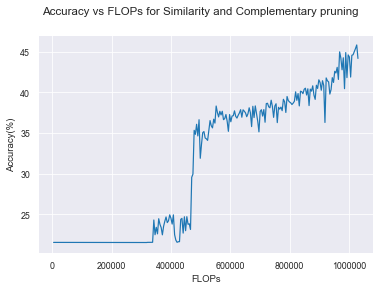

In [89]:
sns.set_style("darkgrid")
sns.set_context("paper")
fig = plt.figure()
plt.plot(flops_sim_comp, test_accs)

plt.suptitle('Accuracy vs FLOPs for Similarity and Complementary pruning')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy(%)')
fig.savefig('similarandcomp_flops.png', dpi=300, bbox_inches='tight', pad_inches = 0)


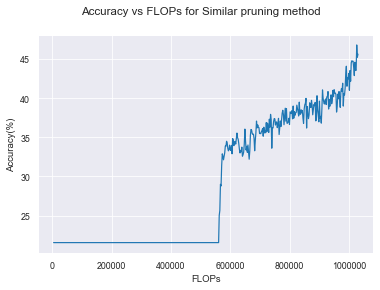

In [88]:
fig = plt.figure()
plt.plot(flops_sim, test_accs_small_only)
plt.suptitle('Accuracy vs FLOPs for Similar pruning method')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy(%)')
fig.savefig('justsimilar_flop.png', dpi=300, bbox_inches='tight', pad_inches = 0)

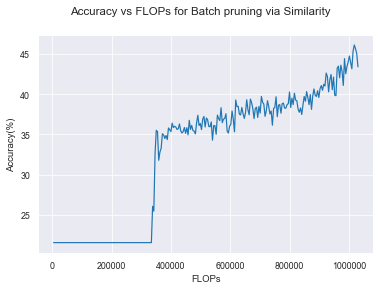

In [87]:
fig = plt.figure()
plt.plot(flops_2_sim, test_accs_3)
plt.suptitle('Accuracy vs FLOPs for Batch pruning via Similarity')
plt.xlabel('FLOPs')
plt.ylabel('Accuracy(%)')
fig.savefig('batchpruning2_flop.png', dpi=300, bbox_inches='tight', pad_inches = 0)